# Project Group
Junrui Ding

Ran Zhao

Yue Wang

# Project Introduction

In some cultures, people always think about males when we talk about smoking. Is this just a stereotypical impression?

We assume that as gender equality is improved for the past two decades, the actual gap of smoking between male and female is shrinking.

Furthermore, there might be certain factors related to higher rate of smoking in female but not well recognized. Verifying the connection between them can provide better guidance for medical and social support services to evaluate the health risks of certain female groups.

**Usage:**

Put these folders files in notebook

- share-of-men-who-are-smoking.csv
- share-of-women-who-are-smoking.csv
- hdr-data.json

From the left table of contents, go to Part 2 MongoDB - Data preparation and insert your own MongoDB url

# Part 1 SQL

## SQL data preparation script

Citations:



> World Health Organization - Global Health Observatory (2024) – processed by Our World in Data. “Share of female adults who smoke or use tobacco (age-standardized)” [dataset]. World Health Organization, “Global Health Observatory” [original data].
Source: World Health Organization - Global Health Observatory (2024) – processed by Our World In Data
https://ourworldindata.org/grapher/share-of-women-who-are-smoking

> World Health Organization - Global Health Observatory (2024) – processed by Our World in Data. “Share of male adults who smoke or use tobacco (age-standardized)” [dataset]. World Health Organization, “Global Health Observatory” [original data].
Source: World Health Organization - Global Health Observatory (2024) – processed by Our World In Data
https://ourworldindata.org/grapher/share-of-men-who-are-smoking



> "Gender Inequality Index." The Human Development Report. Retrieved from https://hdr.undp.org/data-center/documentation-and-downloads




In [61]:
import csv
import json
import sqlite3
import os

## SQL Helper functions
This script was initially tested in VS code, so the processes are being defined as functions.

Please refer to the comments for the details.

In [62]:
def csv_to_json(csv_file, json_file, gender):
    # This function is used to turn the smoking data csv into format of
    # [{"Entity": region_name, "Code": regoin_code, "Year": 1995, "value": 0.23}]

    # there are different column names in male/female json for smoking rate
    column_names = {
        'male': 'Share of male adults who smoke or use tobacco (age-standardized)',
        'female': 'Share of female adults who smoke or use tobacco (age-standardized)'
    }
    column_name = column_names.get(gender)

    # Read CSV and convert to json list
    data = []
    with open(csv_file, 'r', encoding='utf-8') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            # Convert year to integer
            row['Year'] = int(row['Year'])
            # Extract the smoking rate and rename to 'value'
            if column_name in row:
                row['value'] = float(row[column_name])
                # Remove the original long column name
                del row[column_name]
            else:
                raise Exception("gender is wrong!")
            data.append(row)

    # Write to JSON file
    with open(json_file, 'w', encoding='utf-8') as file:
        json.dump(data, file, indent=2, ensure_ascii=False)
    return data

def read_json(input):
    # hepler function to read json into dict
    with open(input, 'r') as file:
        data = json.load(file)

    return data


def create_fresh_db(db_path='project3.db'):
    # Get a connection object for further usage
    # Delete existing database file if it exists
    if os.path.exists(db_path):
        os.remove(db_path)
    conn = sqlite3.connect(db_path)
    return conn

def create_sql_schema(conn):
    cursor = conn.cursor()

    # create table to represent regions
    # As both smoking data and GII are using ISO standard region code
    # It is more reliable to use code as the primary key
    # also easy to enumerate and filter countries, continents, other types of regions later
    cursor.execute('''
        CREATE TABLE regions (
                   name TEXT NOT NULL,
                   IsoCode TEXT PRIMARY KEY
        )
    ''')

    # store the smoking rate data
    # composite key constraint to ensure no duplicated records appear
    # There should not be a record in the same year for same region and the same gender
    cursor.execute('''
        CREATE TABLE smoking_rates (
            IsoCode TEXT NOT NULL,
            rate REAL NOT NULL,
            year INTEGER NOT NULL,
            gender TEXT CHECK (gender IN ('male', 'female')),
            PRIMARY KEY (IsoCode, year, gender),
            FOREIGN KEY (IsoCode) REFERENCES regions (IsoCode)
        )
    ''')

    # store the indicator code
    cursor.execute('''
        CREATE TABLE GII_indicators (
            indicatorCode TEXT PRIMARY KEY,
            name TEXT NOT NULL
        )
    ''')

    # store the GII data, each GII indicator will be saved as one tuple
    # Primary key combination to ensure no duplicated record
    # on same year for the same region on the same indicator
    cursor.execute('''
        CREATE TABLE GII_data (
            IsoCode TEXT,
            year INTEGER NOT NULL,
            indicatorCode TEXT,
            value REAL NOT NULL,
            PRIMARY KEY (IsoCode, year, indicatorCode),
            FOREIGN KEY (IsoCode) REFERENCES regions (IsoCode),
            FOREIGN KEY (indicatorCode) REFERENCES GII_indicators (indicatorCode)
        )
    ''')

    conn.commit()

def insert_regions(conn, female_smoking, male_smoking, GII_data):
    # aggregate and save regions from all the input data
    regions_data = {}
    # In the smoking rate data, there are some regions without code
    # they represent Continents, income groups
    # set those regions with code same as their names to fill the blank
    for item in female_smoking:
        regions_data[item["Entity"] if item["Code"] == "" else item["Code"]] = item["Entity"]

    for item in male_smoking:
        regions_data[item["Entity"] if item["Code"] == "" else item["Code"]] = item["Entity"]

    # In GII data no need to process region code because all records have code
    #  (or else it will violate the primary key constraint later if multiple regions with empty code)
    for item in GII_data:
        regions_data[item["countryIsoCode"]] = item["country"]

    regions_tuples = list(regions_data.items())

    cursor = conn.cursor()

    cursor.executemany('INSERT INTO regions (IsoCode, name) VALUES (?, ?)', regions_tuples)
    conn.commit()

def insert_smoking_rate(conn, data, gender):
    # insert smoking rate, with the gender marked
    records = []
    # In the smoking rate data, there are some regions without code
    # set those regions with code same as their own to filling the blank
    for item in data:
        records.append((item["Entity"] if item["Code"] == "" else item["Code"], item["Year"], \
                        item["value"], gender))


    cursor = conn.cursor()
    cursor.executemany('INSERT INTO smoking_rates (IsoCode, year, rate, gender) VALUES (?, ?, ?, ?)', records)
    conn.commit()

def insert_GII_indicators(conn, data):
    # insert meta data of indicators
    # aggregate from the original GII data
    indicators = {}
    for item in data:
        indicators[item["indicatorCode"]] = item["indicator"]

    indicator_tuples = list(indicators.items())

    cursor = conn.cursor()
    cursor.executemany('INSERT INTO GII_indicators (indicatorCode, name) VALUES (?, ?)', indicator_tuples)
    conn.commit()

def insert_GII_data(conn, data):
    records = []
    # In GII data no need to process region code because all records have code
    #  (or else it will violate the primary key constraint later if multiple regions with empty code)
    for item in data:
        records.append((item["countryIsoCode"], item["indicatorCode"], item["year"], item["value"]))

        cursor = conn.cursor()
    cursor.executemany('INSERT INTO GII_data (IsoCode, indicatorCode, year, value) VALUES (?, ?, ?, ?)', records)
    conn.commit()

## SQL Data ingestion section

The only cleaning was done is for empty region code in the smoking rate dataset

In [63]:
# convert csv into json files
csv_to_json("share-of-men-who-are-smoking.csv", "share-of-men-who-are-smoking.json", "male")
csv_to_json("share-of-women-who-are-smoking.csv", "share-of-women-who-are-smoking.json", "female")

[{'Entity': 'Afghanistan', 'Code': 'AFG', 'Year': 2000, 'value': 19.7},
 {'Entity': 'Afghanistan', 'Code': 'AFG', 'Year': 2005, 'value': 15.3},
 {'Entity': 'Afghanistan', 'Code': 'AFG', 'Year': 2007, 'value': 13.9},
 {'Entity': 'Afghanistan', 'Code': 'AFG', 'Year': 2010, 'value': 12.0},
 {'Entity': 'Afghanistan', 'Code': 'AFG', 'Year': 2015, 'value': 9.4},
 {'Entity': 'Afghanistan', 'Code': 'AFG', 'Year': 2020, 'value': 7.4},
 {'Entity': 'Afghanistan', 'Code': 'AFG', 'Year': 2021, 'value': 7.1},
 {'Entity': 'Afghanistan', 'Code': 'AFG', 'Year': 2022, 'value': 6.8},
 {'Entity': 'Africa', 'Code': '', 'Year': 2000, 'value': 6.3354735},
 {'Entity': 'Africa', 'Code': '', 'Year': 2005, 'value': 4.8637614},
 {'Entity': 'Africa', 'Code': '', 'Year': 2007, 'value': 4.403307},
 {'Entity': 'Africa', 'Code': '', 'Year': 2010, 'value': 3.8077662},
 {'Entity': 'Africa', 'Code': '', 'Year': 2015, 'value': 3.0007427},
 {'Entity': 'Africa', 'Code': '', 'Year': 2020, 'value': 2.402833},
 {'Entity': 'Afr

In [64]:
# read json records as dictionaries
female_smoking = read_json("share-of-women-who-are-smoking.json")
male_smoking = read_json("share-of-men-who-are-smoking.json")
GII_data = read_json("hdr-data.json")

In [65]:
# get databse connection
conn = create_fresh_db()
# create schema
create_sql_schema(conn)
# insert region records from all the data
insert_regions(conn, female_smoking, male_smoking, GII_data)
# insert smoking records and append the gender marker
insert_smoking_rate(conn, female_smoking, "female")
insert_smoking_rate(conn, male_smoking, "male")

insert_GII_indicators(conn, GII_data)
insert_GII_data(conn, GII_data)
conn.close()

## Data sanity check
 As the data was retrieved from a already cleaned source and the schema ensured uniquess and NOT NULL constraints, this section will only check there are enough regions overlap, there should be more than 100 joined records to provide sufficient amount of data

This is the helper function section for testing data

In [66]:
def create_fresh_db(db_path='project3.db'):
    conn = sqlite3.connect(db_path)
    return conn

def read_common_regions(conn):
    cursor = conn.cursor()
    cursor.execute('''
    SELECT DISTINCT r.IsoCode, r.name
    FROM regions r
    JOIN smoking_rates s ON r.IsoCode = s.IsoCode
    JOIN GII_data g ON r.IsoCode = g.IsoCode
    ORDER BY r.name
''')


    results = cursor.fetchall()
    print("{} regions appeared both in smoking rates and GII".format(len(results)))
    print("=======================================================")

    # Regions with smoking data only (not in GII)
    cursor.execute('''
        SELECT DISTINCT r.IsoCode, r.name
        FROM smoking_rates s JOIN regions r ON r.IsoCode = s.IsoCode
        WHERE s.IsoCode NOT IN (SELECT DISTINCT IsoCode FROM GII_data)
    ''')
    results = cursor.fetchall()
    print("{} regions only in smoking data".format(len(results)))
    for iso_code, name in results:
        print(f"{iso_code}: {name}")
    print("=======================================================")

    # Regions with GII data only (not in smoking)
    cursor.execute('''
        SELECT DISTINCT r.IsoCode, r.name
        FROM GII_data g JOIN regions r ON r.IsoCode = g.IsoCode
        WHERE g.IsoCode NOT IN (SELECT DISTINCT IsoCode FROM smoking_rates)
    ''')
    results = cursor.fetchall()
    print("{} regions only in GII data".format(len(results)))
    for iso_code, name in results:
        print(f"{iso_code}: {name}")
    print("=======================================================")

def check_empty_region_code(conn):
    cursor = conn.cursor()
    cursor.execute('''
        SELECT COUNT(*) as null_count
        FROM regions
        WHERE IsoCode = "";
    ''')
    result = cursor.fetchone()[0]
    print("{} regions have empty code".format(result))

Run this section to get the check results. The main target is to check there are enough common regions(countries) in both GII and smoking rate data

Insights:
1. In smoking data, the special regions represent continents, sub areas in continents, the whole world, in come groups
2. In GII data, the special regions are small regions(countries), human development groups, and sub areas around the world

So we assume that if we extract the data with same IsoCode from them, they should mainly represent countries and the insight of correlation between them can only be gained in the level of countries.

In [67]:
conn = create_fresh_db()
# for regions that are not shared between GII and smoking data, they are:
# 1. Continents 2. UN regions(aggregated multiple conturies) 3. Human development Index groups 4. small regions
# We will ignore them and assume the 164 regions shared regions can represent majority of the data
read_common_regions(conn)
# check if anyone of the region code is empty, this should be zero
check_empty_region_code(conn)
# no need to check if any value is null such constraint was applied in the SQL schema

164 regions appeared both in smoking rates and GII
12 regions only in smoking data
Africa: Africa
Asia: Asia
COK: Cook Islands
Europe: Europe
High-income countries: High-income countries
Low-income countries: Low-income countries
Lower-middle-income countries: Lower-middle-income countries
North America: North America
OWID_WRL: World
Oceania: Oceania
South America: South America
Upper-middle-income countries: Upper-middle-income countries
42 regions only in GII data
AGO: Angola
ATG: Antigua and Barbuda
CAF: Central African Republic
DJI: Djibouti
DMA: Dominica
ERI: Eritrea
FSM: Micronesia (Federated States of)
GAB: Gabon
GIN: Guinea
GNQ: Equatorial Guinea
GRD: Grenada
HKG: Hong Kong, China (SAR)
KNA: Saint Kitts and Nevis
LBY: Libya
LIE: Liechtenstein
MCO: Monaco
MKD: North Macedonia
MOZ: Mozambique
NIC: Nicaragua
PSE: Palestine, State of
SDN: Sudan
SMR: San Marino
SOM: Somalia
SSD: South Sudan
SUR: Suriname
SYR: Syrian Arab Republic
TJK: Tajikistan
TTO: Trinidad and Tobago
VCT: Saint V

## Data distribution (frequency)

Check the sampling frequency for the data, how often they are collected?

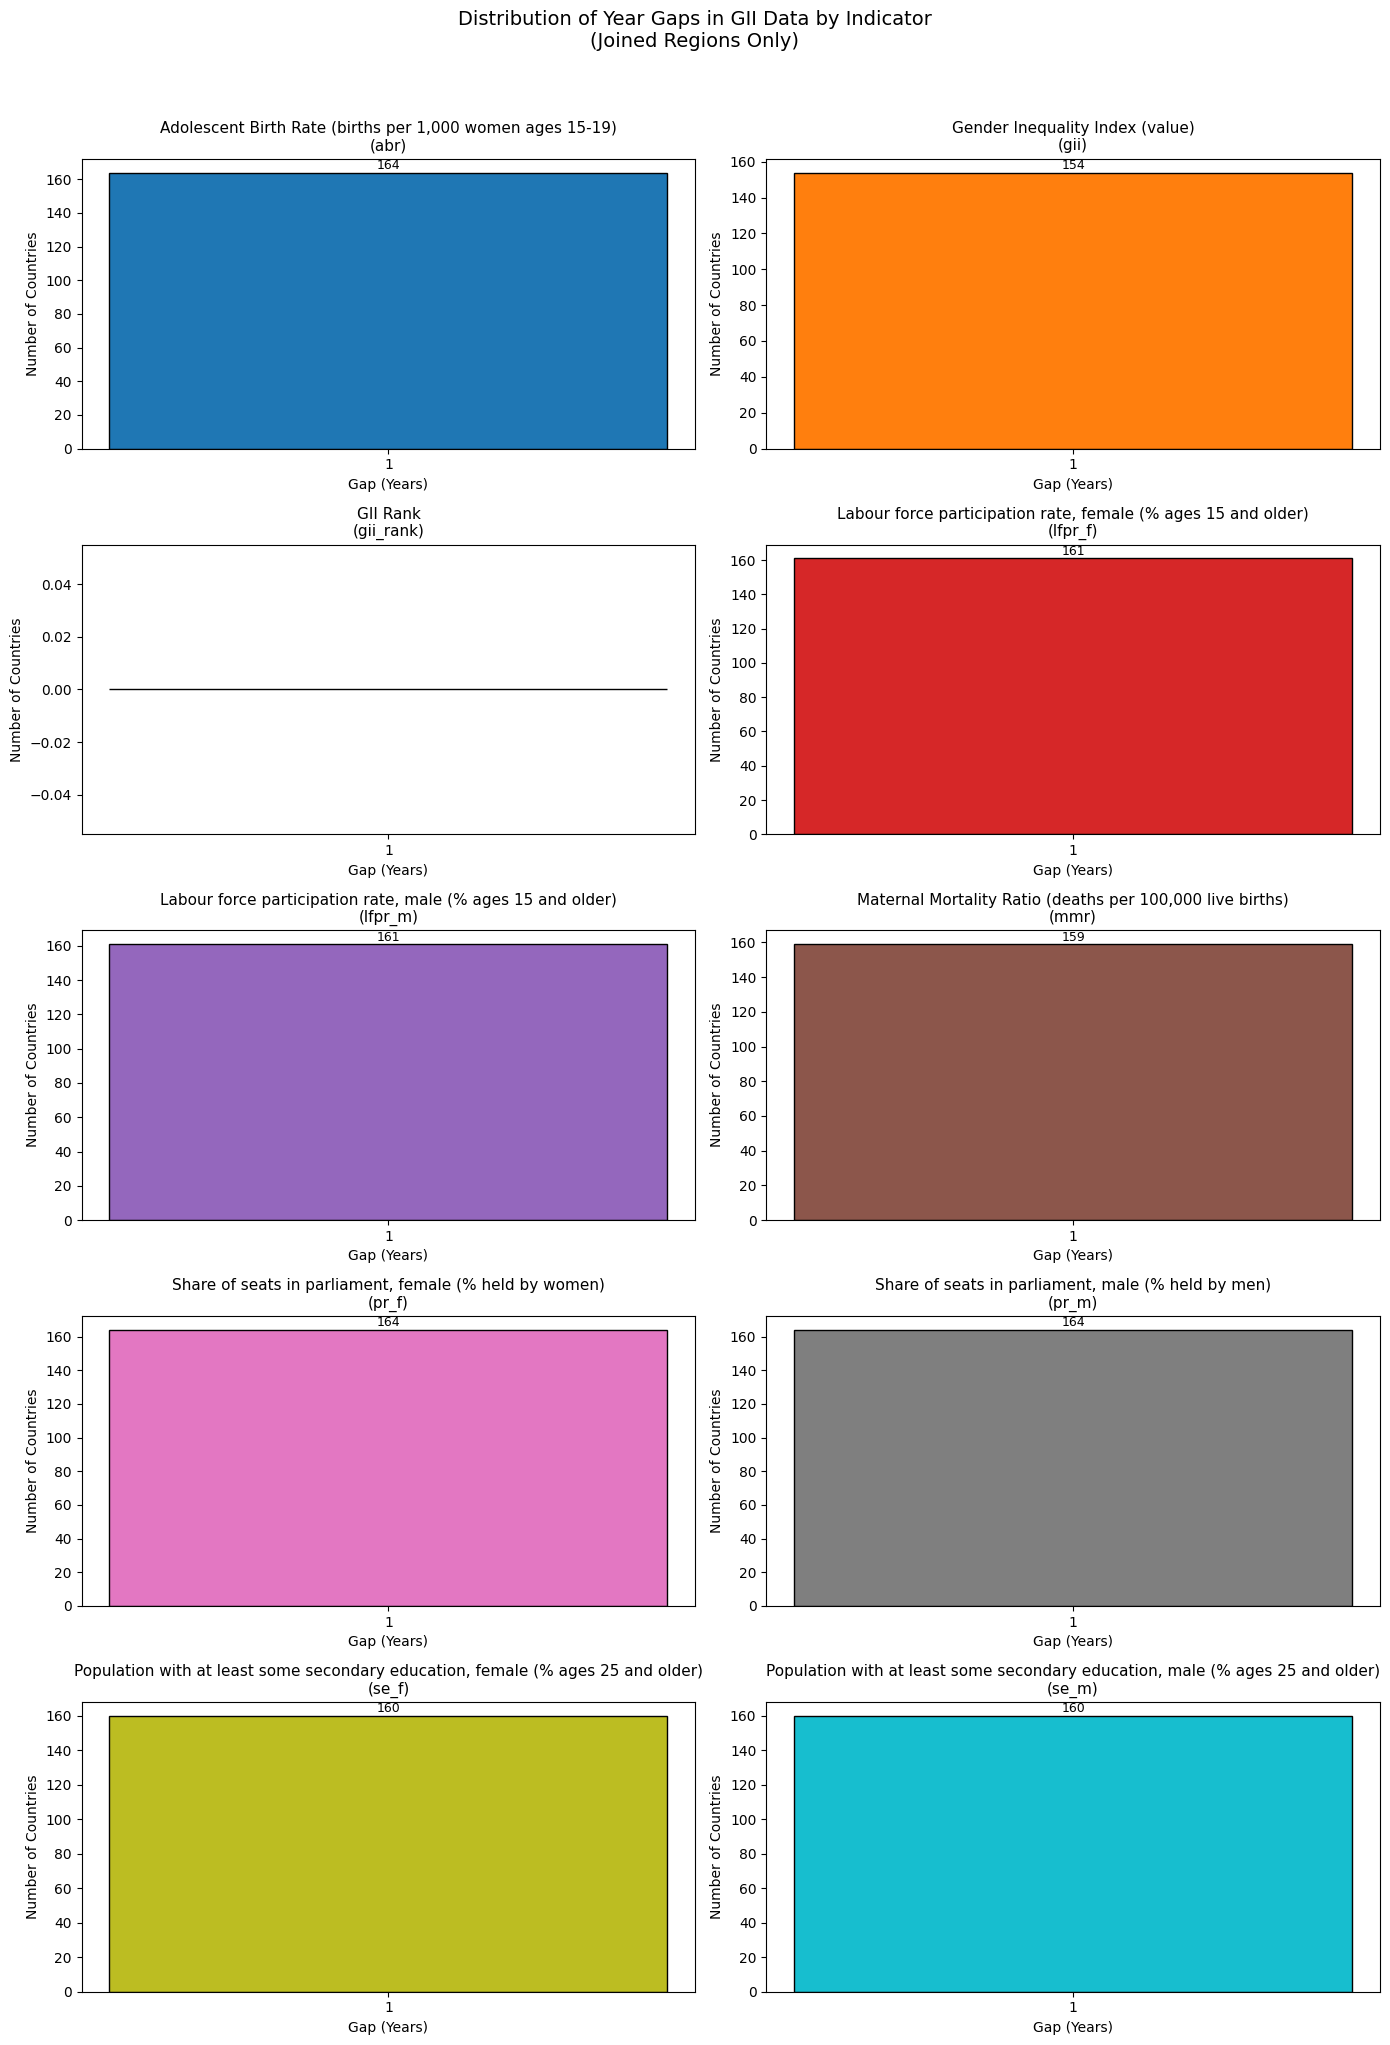

In [68]:
import matplotlib.pyplot as plt
from collections import Counter

def analyze_gii_year_gaps(conn):
  # draw the data frequency for each of GII indicators
  cursor = conn.cursor()

  # Get all data in one query with indicator names, already sorted
  cursor.execute('''
      SELECT g.IsoCode, g.indicatorCode, i.name, g.year
      FROM GII_data g
      JOIN GII_indicators i ON g.indicatorCode = i.indicatorCode
      WHERE g.IsoCode IN (SELECT DISTINCT IsoCode FROM smoking_rates)
      ORDER BY g.IsoCode, g.indicatorCode, g.year
  ''')
  results = cursor.fetchall()

  # Group years by region and indicator, also collect indicator names
  region_indicator_years = {}
  indicator_names = {}

  for iso_code, indicator_code, indicator_name, year in results:
      key = (iso_code, indicator_code)
      if key not in region_indicator_years:
          region_indicator_years[key] = []
      region_indicator_years[key].append(year)
      indicator_names[indicator_code] = indicator_name

  # Calculate the most common gap for each region-indicator combination
  gap_counts_by_indicator = {code: Counter() for code in indicator_names.keys()}

  for (iso_code, indicator_code), years in region_indicator_years.items():
      if len(years) < 2:
          continue

      gaps = [years[i+1] - years[i] for i in range(len(years) - 1)]
      most_common_gap = Counter(gaps).most_common(1)[0][0]
      gap_counts_by_indicator[indicator_code][most_common_gap] += 1

  # Get all unique gaps across all indicators
  all_gaps = sorted(set(
      gap for counts in gap_counts_by_indicator.values() for gap in counts.keys()
  ))

  # Create subplots - one for each indicator
  indicators = list(indicator_names.items())
  n_indicators = len(indicators)
  n_cols = 2
  n_rows = (n_indicators + 1) // 2

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
  axes = axes.flatten() if n_indicators > 1 else [axes]

  colors = plt.cm.tab10.colors

  for idx, (indicator_code, indicator_name) in enumerate(indicators):
      ax = axes[idx]
      gap_counts = gap_counts_by_indicator[indicator_code]

      counts = [gap_counts.get(g, 0) for g in all_gaps]

      bars = ax.bar(all_gaps, counts, color=colors[idx % len(colors)], edgecolor='black')

      for bar in bars:
          height = bar.get_height()
          if height > 0:
              ax.text(bar.get_x() + bar.get_width()/2, height + 0.3,
                      str(int(height)), ha='center', va='bottom', fontsize=9)

      ax.set_xlabel('Gap (Years)', fontsize=10)
      ax.set_ylabel('Number of Countries', fontsize=10)
      ax.set_title(f'{indicator_name}\n({indicator_code})', fontsize=11)
      ax.set_xticks(all_gaps)

  # Hide any unused subplots
  for idx in range(len(indicators), len(axes)):
      axes[idx].set_visible(False)

  fig.suptitle('Distribution of Year Gaps in GII Data by Indicator\n(Joined Regions Only)', fontsize=14, y=1.02)
  plt.tight_layout()
  plt.show()

  return gap_counts_by_indicator

# Run the analysis
gap_counts_by_indicator = analyze_gii_year_gaps(conn)

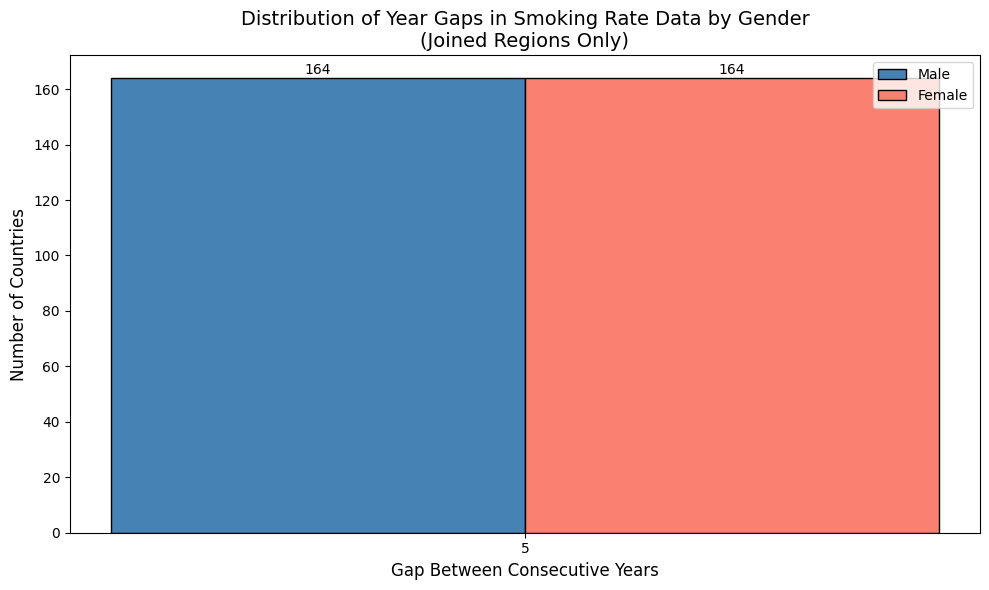

In [69]:
import matplotlib.pyplot as plt
from collections import Counter

def analyze_smoking_year_gaps(conn):
    cursor = conn.cursor()

    # Get distinct years per region and gender (for joined regions only), already sorted
    cursor.execute('''
        SELECT s.IsoCode, s.gender, s.year
        FROM smoking_rates s
        WHERE s.IsoCode IN (SELECT DISTINCT IsoCode FROM GII_data)
        ORDER BY s.IsoCode, s.gender, s.year
    ''')
    results = cursor.fetchall()

    # Group years by region and gender
    region_gender_years = {}
    for iso_code, gender, year in results:
        key = (iso_code, gender)
        if key not in region_gender_years:
            region_gender_years[key] = []
        region_gender_years[key].append(year)

    # Calculate the most common gap for each region-gender combination
    gap_counts = {'male': Counter(), 'female': Counter()}

    for (iso_code, gender), years in region_gender_years.items():
        if len(years) < 2:
            continue

        gaps = [years[i+1] - years[i] for i in range(len(years) - 1)]
        most_common_gap = Counter(gaps).most_common(1)[0][0]
        gap_counts[gender][most_common_gap] += 1

    # Prepare data for plotting
    all_gaps = sorted(set(gap_counts['male'].keys()) | set(gap_counts['female'].keys()))
    male_counts = [gap_counts['male'].get(g, 0) for g in all_gaps]
    female_counts = [gap_counts['female'].get(g, 0) for g in all_gaps]

    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 6))

    x = range(len(all_gaps))
    width = 0.35

    bars_male = ax.bar([i - width/2 for i in x], male_counts, width, label='Male', color='steelblue', edgecolor='black')
    bars_female = ax.bar([i + width/2 for i in x], female_counts, width, label='Female', color='salmon', edgecolor='black')

    # Add count labels on top of each bar
    for bar in bars_male + bars_female:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=10)

    ax.set_xlabel('Gap Between Consecutive Years', fontsize=12)
    ax.set_ylabel('Number of Countries', fontsize=12)
    ax.set_title('Distribution of Year Gaps in Smoking Rate Data by Gender\n(Joined Regions Only)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(all_gaps)
    ax.legend()
    plt.tight_layout()
    plt.show()

    return gap_counts

# Run the analysis
gap_counts = analyze_smoking_year_gaps(conn)

## Graphs
Note: the graphs drew in both SQL and Mondodb sections are exactly the same, so we will attach the same analyses under each graph in both sections for easier review.

###Graph 1-4
Before examining how GII relates to smoking behavior, we first use smoking data alone to understand the basic structure of global gender differences in smoking. These four graphs establish the essential patterns as the baseline for later linking smoking datasets to GII dataset—how male and female smoking rates differ across countries, regions, and over time.

###Graph 1: Male vs Female smoking prevalence

This graph looks at how male and female smoking prevalence compare in two years—2000 and 2022—so we can see how the gender gap in smoking has shifted over the past two decades. Each blue point represents a country,we also have markers for continent-level groups, income-level groups, and the global average (“World”). The diagonal line shows where the two rates would be equal, so if a point sits above the line, it means male smoking rate is higher than female smoking rate in that country or group.

1. Selecting Male–Female Smoking Data for the Target Years (2000 & 2022)

In [70]:
import sqlite3
import matplotlib.pyplot as plt

def get_prevalence_and_gap_for_year_sql(conn, year):
    """
    Query SQLite to get female_smoking, male_smoking and smoking_gap
    for all regions in a given year.

    All data management for this step (filter by year, join male/female,
    compute gap) is done inside SQL using CTEs.
    """
    # This query get the smoking rate for male/female and their gaps for a certain year in all countries.
    # We need to do the query for both 2000 and 2022, so we use a placeholder in the query: WHERE m.year = ?
    # The final output of this query would be like:
    # {'isoCode': 'AFG', 'region': 'Afghanistan', 'year': 2022, 'male_smoking': 38.7, 'female_smoking': 6.8, 'smoking_gap': 31.900000000000002}
    query = """
    -- CTE for male smoking rates
    WITH male AS (
        SELECT IsoCode, year, rate AS male_rate
        FROM smoking_rates
        WHERE gender = 'male'
    ),
    -- CTE for female smoking rates
    female AS (
        SELECT IsoCode, year, rate AS female_rate
        FROM smoking_rates
        WHERE gender = 'female'
    )
    SELECT
        r.IsoCode,                -- country/region code
        r.name      AS region,    -- country/region name
        m.year,
        m.male_rate,
        f.female_rate,
        (m.male_rate - f.female_rate) AS smoking_gap
    FROM male m
    JOIN female f
        ON m.IsoCode = f.IsoCode
       AND m.year   = f.year
    JOIN regions r
        ON r.IsoCode = m.IsoCode
    WHERE m.year = ?
    """

    cur = conn.cursor()
    cur.execute(query, (year,))
    rows = cur.fetchall()

    # Convert rows into a list of dicts, similar to MongoDB documents
    docs = []
    for iso, region, yr, male_rate, female_rate, gap in rows:
        docs.append({
            "isoCode": iso,
            "region": region,
            "year": yr,
            "male_smoking": male_rate,
            "female_smoking": female_rate,
            "smoking_gap": gap
        })
    return docs

# Example: open DB and load data for 2000 and 2022
conn = sqlite3.connect("project3.db")

docs_2000 = get_prevalence_and_gap_for_year_sql(conn, 2000)
docs_2022 = get_prevalence_and_gap_for_year_sql(conn, 2022)

print(len(docs_2000), len(docs_2022))
print(docs_2022[0])

176 176
{'isoCode': 'AFG', 'region': 'Afghanistan', 'year': 2022, 'male_smoking': 38.7, 'female_smoking': 6.8, 'smoking_gap': 31.900000000000002}


2. Classifying Regions into Types (Country / Continent / World / Income Group)

In [71]:
def is_country_iso(iso):
    """
    Return True if isoCode looks like a country code:
    exactly 3 uppercase alphabetic characters, e.g. 'USA', 'AUS'.
    This is deduced by looking at the regions table
    """
    return len(iso) == 3 and iso.isalpha() and iso.isupper()


def classify_region(doc):
    """
    Classify each document into one of four categories:
    - 'country'
    - 'continent'
    - 'world'
    - 'income'

    The classification logic is based on the isoCode and region name.
    """
    # In GII actually there are a group of regions like south Asia: ZZI.SA
    # They are ignored in the following analysis as we mainly focus on the level of countries
    iso = doc["isoCode"]
    name = doc["region"]

    # World aggregate
    if name == "World":
        return "world"

    # Continent names used in the dataset (deduced by looking at regions table)
    continents = {
        "Africa", "Asia", "Europe", "Oceania",
        "North America", "South America"
    }
    if name in continents:
        return "continent"

    # Income group names used in the dataset (deduced by looking at regions table)
    income_groups = {
        "Low-income countries",
        "Lower-middle-income countries",
        "Upper-middle-income countries",
        "High-income countries"
    }
    if name in income_groups:
        return "income"

    # Default: country-level (3-letter ISO code)
    if is_country_iso(iso):
        return "country"

    # Fallback: treat as 'other'
    return "other"


def get_color_for_category(cat):
    """
    Map each category to a specific color for plotting.
    """
    if cat == "country":
        return "tab:blue"
    if cat == "continent":
        return "tab:orange"
    if cat == "world":
        return "black"
    if cat == "income":
        return "tab:green"
    return "tab:gray"

def short_income_label(name):
    """
    Make income-group labels shorter for plotting.
    We make the labels shorter so that there will be no overlaps between labels and the graph won't be a mess.
    """
    mapping = {
        "High-income countries":           "High income",
        "Low-income countries":            "Low income",
        "Upper-middle-income countries":   "Upper-middle",
        "Lower-middle-income countries":   "Lower-middle",
    }
    return mapping.get(name, name)

def group_docs_by_category(docs, value_keys):
    """
    Group documents by their region category (country / continent / world / income / other)
    so that we can plot them with different colors, markers, and labels.

    Parameters
    ----------
    docs : list of dict
        Each dict represents a row from the smoking dataset (one region in one year).
        Every document contains fields like:
            - region
            - isoCode
            - female_smoking
            - male_smoking
            ... (more indicators depending on the query)

    value_keys : list of str
        The numeric fields we want to extract for plotting.
        For example: ["female_smoking", "male_smoking"].
        These values will be grouped by category.

    Returns
    -------
    dict
        A nested dictionary with this structure:

        {
            'country': {
                'female_smoking': [...],
                'male_smoking': [...],
                'labels': [...]
            },
            'continent': { ... },
            'world': { ... },
            'income': { ... },
            'other': { ... }
        }

        - Each top-level key is a category determined by classify_region()
        - For each category, value_keys are stored as lists of numeric values
        - "labels" stores region names so we can annotate points later if needed

    Notes
    -----
    - This function lets us easily plot different region types using different colors.
    - We skip any document that has missing values for the selected value_keys.
      (Our cleaned dataset shouldn't normally contain None, but the check is kept just in case.)
    """

    result = {}
    for d in docs:
        cat = classify_region(d)

        # Initialize storage for this category when we see it the first time
        if cat not in result:
            result[cat] = {k: [] for k in value_keys}
            result[cat]["labels"] = []


        # Add the numeric values and region label
        for k in value_keys:
            result[cat][k].append(d[k])
        result[cat]["labels"].append(d["region"])

    return result


cats_2000 = group_docs_by_category(
    docs_2000,
    value_keys=["female_smoking", "male_smoking"]
)

cats_2022 = group_docs_by_category(
    docs_2022,
    value_keys=["female_smoking", "male_smoking"]
)

 3. Selecting Male–Female Smoking Data for the Target Years (2000 & 2022)

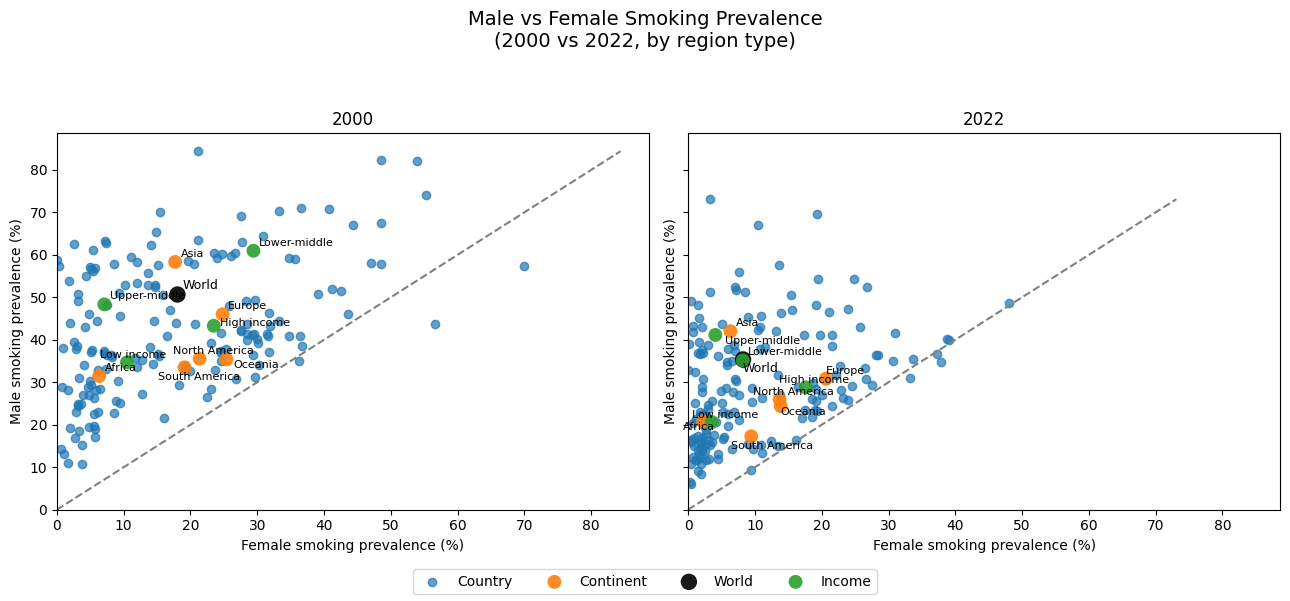

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True)

category_order = ["country", "continent", "world", "income"]

def plot_one_year(ax, cats, year_label, add_legend_labels, panel_side):
    """
    Plot one scatter panel for a given year.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to draw on.

    cats : dict
        Output of group_docs_by_category(). Contains grouped values
        for different categories: country / continent / world / income.

    year_label : str
        Title text for this panel ("2000" or "2022").

    add_legend_labels : bool
        If True, this panel will contribute labels to the global legend.

    panel_side : {"left", "right"}
        Which panel this is, used for fine-tuning text offsets so labels
        don't overlap too much in crowded areas.
    """

    max_val = 0.0

    # 1. Plot all country-level points first (background layer)
    if "country" in cats:
        data = cats["country"]
        x = data["female_smoking"]
        y = data["male_smoking"]

        color = get_color_for_category("country")
        label = "Country" if add_legend_labels else None

        ax.scatter(x, y, alpha=0.7, color=color, label=label)

        if x and y:
            max_val = max(max_val, max(max(x), max(y)))


    # 2. Plot continent / world / income groups as big points
    #    and add text labels next to them.
    # ---------------------------------------------------------
    # We don't want the labels in the graph to be overlapping each other,
    # so I manually adjusted the positions of those labels.
    # key = (panel_side, category, short_text)

    offset_overrides = {
        ("left",  "continent", "North America"): (-4, 1),
        ("left",  "continent", "South America"): (-4, -3),
        ("left",  "income",    "Low income"):   (-4, 1),
        ("left",  "income",    "High income"):   (1, 0),
         ("left", "continent", "Oceania"):       (1, -2),
        ("right", "continent", "North America"): (-4, 1),
        ("right", "continent", "Oceania"):       (0, -2),
        ("right", "world",     "World"):         (0, -3),
        ("right", "income",    "Upper-middle"):  (1.5, -2),
        ("right", "continent",  "Africa"):  (-3, -2),
        ("right", "income",  "Low income"):  (-3, 1),
        ("right", "continent",  "South America"):  (-3, -3),
	      ("right",  "income",    "High income"):   (-4, 1),
        ("right",  "continent",   "Europe"):   (0, 1)
    }


    for cat in ["continent", "world", "income"]:
        if cat not in cats:
            continue

        data = cats[cat]
        xs = data["female_smoking"]
        ys = data["male_smoking"]
        labels = data["labels"]

        color = get_color_for_category(cat)
        marker_size = 140 if cat == "world" else 100  # make World largest

        for i, (x, y, name) in enumerate(zip(xs, ys, labels)):
            # Legend label only on the first point of each category

            # There are many continents like Asia, Europe, etc that are classified by us into the category of Continent.
            # we don't want there to be one legend label for each, we only want one legend label Continent for all those continents.
            # Also we have left panel and right panel in the same graph. So we set the value of add_legend_labels to true for left panel, but false for right panel.
            leg_label = cat.capitalize() if (add_legend_labels and i == 0) else None

            # Big solid marker, no white halo
            ax.scatter(
                x, y,
                s=marker_size,
                color=color,
                edgecolors="none",
                alpha=0.9,
                label=leg_label,
            )

            # Short label text
            if cat == "income":
                text = short_income_label(name)
            elif cat == "world":
                text = "World"
            else:
                text = name

            # Default offset (slightly up and right)
            dx, dy = 0.8, 1.2

            # Apply manual offset override if we have one
            key = (panel_side, cat, text)
            if key in offset_overrides:
                dx, dy = offset_overrides[key]


            if cat == "world":
                ax.text(
                    x + dx,
                    y + dy,
                    text,
                    fontsize=9,
                )
            else:
                ax.text(
                    x + dx,
                    y + dy,
                    text,
                    fontsize=8,
                )

        # we need a global max_val(max of individual countries, continents, world, income, all 4 categories) to draw the entire graph.
        if xs and ys:
            max_val = max(max_val, max(max(xs), max(ys)))

    # 3. Reference line y = x
    ax.plot([0, max_val], [0, max_val], "--", color="gray")

    # 4. Titles and axis labels
    ax.set_title(year_label)
    ax.set_xlabel("Female smoking prevalence (%)")
    ax.set_ylabel("Male smoking prevalence (%)")

    return max_val


# ------------------ LEFT PANEL (2000) ------------------
max_val_2000 = plot_one_year(
    axes[0],
    cats_2000,
    "2000",
    add_legend_labels=True,
    panel_side="left"
)

# ------------------ RIGHT PANEL (2022) ------------------
max_val_2022 = plot_one_year(
    axes[1],
    cats_2022,
    "2022",
    add_legend_labels=False,
    panel_side="right"
)

# ------------------ Sync axes across panels ------------------
global_max = max(max_val_2000, max_val_2022)
for ax in axes:
    ax.set_xlim(0, global_max * 1.05)
    ax.set_ylim(0, global_max * 1.05)

# Build a single legend from the left subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4)

fig.suptitle(
    "Male vs Female Smoking Prevalence\n(2000 vs 2022, by region type)",
    fontsize=14
)

plt.tight_layout(rect=[0, 0.05, 1, 0.93])
plt.show()

####Analysis:
In both years, male smoking prevalence is consistently higher than female prevalence for almost all region categories. In 2000, the gender gap is generally wide, especially among low-income, upper-income, Africa and Asian regions. This shows both development level and cultural norms can discourage female smoking.

By 2022, both male and female rates decline, but the drop is much larger for men, leading to a visible shrinking of the smoking gap in most regions. We can clearly see most of the points are shifting towards both left and the diagonal line, which indicates the overall decline in smoking rates of both genders and a gradual decreasing difference in smoking rates between genders.


### Graph 2: Country-level distribution of smoking gap
Smoking gap is defined as the difference between male and female smoking prevalence (male − female).
This histogram compares the distribution of the gender smoking gap (male − female) across countries in 2000 and 2022.
It helps us see how the gap shifts over time, whether countries are converging toward smaller or larger gender differences or remains the same.
By overlaying the two distributions, we can visually assess how the global smoking patterns have evolved over the past two decades.

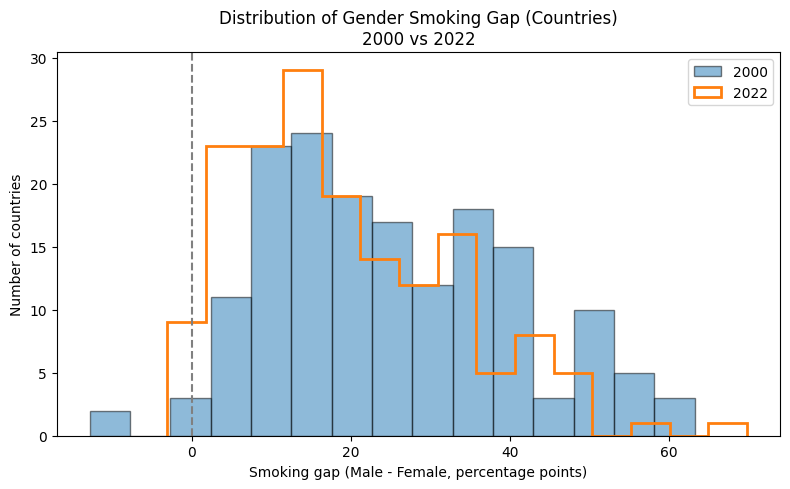

In [73]:
gaps_2000 = group_docs_by_category(
    docs_2000,
    value_keys=["smoking_gap"]
)

gaps_2022 = group_docs_by_category(
    docs_2022,
    value_keys=["smoking_gap"]
)


# Extract country-level gaps (only the smoking_gap values)
country_gaps_2000 = gaps_2000["country"]["smoking_gap"]
country_gaps_2022 = gaps_2022["country"]["smoking_gap"]

plt.figure(figsize=(8, 5))

# We use the same bin settings for both years for a fair comparison.
all_country_gaps = country_gaps_2000 + country_gaps_2022
bins = 15

# Histogram for 2000
plt.hist(
    country_gaps_2000,
    bins=bins,
    alpha=0.5,
    edgecolor="black",
    label="2000"
)

# Histogram outline for 2022 (so they do not completely overlap)
plt.hist(
    country_gaps_2022,
    bins=bins,
    histtype="step",
    linewidth=2,
    label="2022"
)

plt.axvline(0, linestyle="--", color="gray")

plt.xlabel("Smoking gap (Male - Female, percentage points)")
plt.ylabel("Number of countries")
plt.title("Distribution of Gender Smoking Gap (Countries)\n2000 vs 2022")
plt.legend()
plt.tight_layout()
plt.show()

####Analysis:
The distribution shows clear improvement over time. In 2000, the smoking gap is heavily right-skewed: many countries have large gender differences in smoking rate, with gaps exceeding 20–30 percentage points. By 2022, the distribution tightens and shifts toward zero, with fewer outliers. Many countries fall within the 0–10 range, and several have reached 0. The fast shrinking may be a outcome of global health policies, cultural changes, and reduced male smoking rates.


###Graph 3: Income-level and continent-level distribution of smoking gap

The smoking datasets themselves already include continent and income-group classifications. Since these categories are available, it is natural to explore how the gender smoking gap is distributed across different parts of the world. This helps us understand the global structure of the gap.

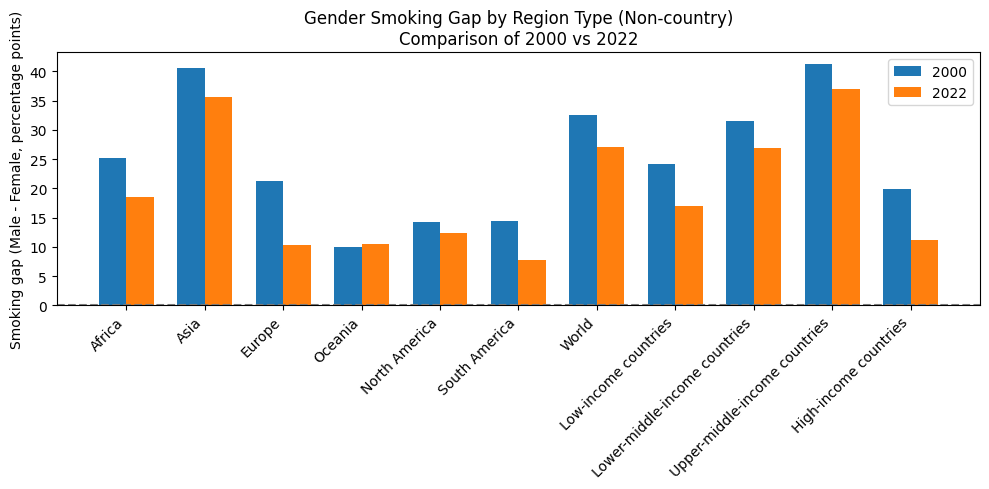

In [74]:
import numpy as np

# Desired plotting order for non-country regionsß
continent_order = [
    "Africa", "Asia", "Europe", "Oceania",
    "North America", "South America"
]

income_order = [
    "Low-income countries",
    "Lower-middle-income countries",
    "Upper-middle-income countries",
    "High-income countries"
]

world_name = "World"

# Final x-axis order: continents → world → income groups
x_region_order = continent_order + [world_name] + income_order


# 1. Build mappings:  region_name → smoking_gap
#    for 2000 and 2022, excluding the "country" category
non_country_map_2000 = {}
non_country_map_2022 = {}

# For 2000
for cat, data in gaps_2000.items():
    if cat == "country":
        continue  # skip country-level values
    gaps_list   = data.get("smoking_gap", [])
    labels_list = data.get("labels", [])
    for name, gap in zip(labels_list, gaps_list):
        non_country_map_2000[name] = gap

# For 2022
for cat, data in gaps_2022.items():
    if cat == "country":
        continue
    gaps_list   = data.get("smoking_gap", [])
    labels_list = data.get("labels", [])
    for name, gap in zip(labels_list, gaps_list):
        non_country_map_2022[name] = gap


# 2. Build aligned lists following the desired x-axis order
regions_for_plot = []
gaps2000_for_plot = []
gaps2022_for_plot = []

for region_name in x_region_order:
    # Only include regions present in at least one year
    if (region_name in non_country_map_2000) or (region_name in non_country_map_2022):
        regions_for_plot.append(region_name)
        gaps2000_for_plot.append(non_country_map_2000.get(region_name, 0.0))
        gaps2022_for_plot.append(non_country_map_2022.get(region_name, 0.0))


# 3. Draw the bar chart
if regions_for_plot:
    x = np.arange(len(regions_for_plot))
    bar_width = 0.35

    plt.figure(figsize=(10, 5))

    # Bars for year 2000 (shifted slightly left)
    plt.bar(x - bar_width/2, gaps2000_for_plot, width=bar_width, label="2000")

    # Bars for year 2022 (shifted slightly right)
    plt.bar(x + bar_width/2, gaps2022_for_plot, width=bar_width, label="2022")

    plt.axhline(0, linestyle="--", color="gray")

    plt.xticks(x, regions_for_plot, rotation=45, ha="right")
    plt.ylabel("Smoking gap (Male - Female, percentage points)")
    plt.title("Gender Smoking Gap by Region Type (Non-country)\nComparison of 2000 vs 2022")
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("No non-country gaps available for plotting.")

####Analysis:
In this graph, we present the distribution of smoking gap among different region categories: Continents, world, regions grouped by income level, in both 2000 and 2022.

The gender smoking gap remains substantial across all regions, but most regions show a noticeable decline from 2000 to 2022. Asia and upper-middle-income countries continue to show the largest gaps, indicating strong gendered patterns in smoking behavior. Asia countries and upper-middle-income countries have a large degree of overlap, which helps explain the result. High-income countries and Europe show the sharpest reductions, the reason might be the more effective tobacco control policies and shifts in social norms. Overall, the global pattern suggests gradual convergence.


### Graph 4: World smoking prevalence over time
This graph shows how male and female smoking prevalence has changed globally from 2000 to 2022.
Using the “World” aggregate, we extract the values for both genders over the 10-year period and plot their trends on the same chart.

The goal is to observe whether global smoking rates are decreasing over time, and whether the gender gap is narrowing.

Number of records: 16
Example record: {'year': 2000, 'gender': 'female', 'avg_rate': 18.053535}


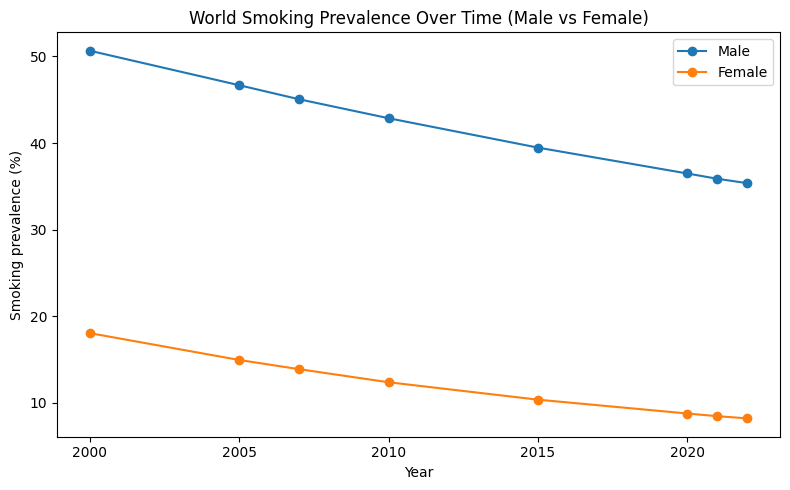

In [75]:
def get_world_trend_sql(conn):
    """
    Query SQLite to get the time series of male and female smoking prevalence
    for the 'World' aggregate across all available years.

    All data management (filtering on World, grouping by year/gender) is done
    inside SQL.
    """
    query = """
    SELECT
        s.year,
        s.gender,
        s.rate
    FROM smoking_rates AS s
    JOIN regions AS r
        ON r.IsoCode = s.IsoCode
    WHERE r.name = 'World'          -- the 'World' aggregate row in regions
    GROUP BY s.year, s.gender       -- one value per (year, gender)
    ORDER BY s.year, s.gender;
    """

    cur = conn.cursor()
    cur.execute(query)
    rows = cur.fetchall()

    # Convert rows to a list of dicts, similar to MongoDB documents
    world_trend = []
    for year, gender, avg_rate in rows:
        world_trend.append({
            "year": year,
            "gender": gender,
            "avg_rate": avg_rate
        })

    return world_trend


# ---- Query from SQLite ----
conn = sqlite3.connect("project3.db")
world_trend_docs = get_world_trend_sql(conn)
print("Number of records:", len(world_trend_docs))
print("Example record:", world_trend_docs[0])

# ---- Split into male / female series ----
years_male = []
rates_male = []
years_female = []
rates_female = []

for d in world_trend_docs:
    y = d["year"]
    g = d["gender"]
    r = d["avg_rate"]
    if g == "male":
        years_male.append(y)
        rates_male.append(r)
    elif g == "female":
        years_female.append(y)
        rates_female.append(r)

# Sort each series by year (safe even if SQL already sorted)
male_series = sorted(zip(years_male, rates_male), key=lambda x: x[0])
female_series = sorted(zip(years_female, rates_female), key=lambda x: x[0])

years_male = [y for y, r in male_series]
rates_male = [r for y, r in male_series]

years_female = [y for y, r in female_series]
rates_female = [r for y, r in female_series]

# ---- Optionally restrict to 2000–2022 ----
min_year, max_year = 2000, 2022
years_male_filtered = []
rates_male_filtered = []
years_female_filtered = []
rates_female_filtered = []

for y, r in zip(years_male, rates_male):
    if min_year <= y <= max_year:
        years_male_filtered.append(y)
        rates_male_filtered.append(r)

for y, r in zip(years_female, rates_female):
    if min_year <= y <= max_year:
        years_female_filtered.append(y)
        rates_female_filtered.append(r)

# ---- Plot the time trend ----
plt.figure(figsize=(8, 5))

plt.plot(years_male_filtered, rates_male_filtered, marker="o", label="Male")
plt.plot(years_female_filtered, rates_female_filtered, marker="o", label="Female")

plt.xlabel("Year")
plt.ylabel("Smoking prevalence (%)")
plt.title("World Smoking Prevalence Over Time (Male vs Female)")
plt.legend()
plt.tight_layout()
plt.show()

####Analysis:
As mentioned above, the global smoking prevalence of both genders is decreasingly steadily. In this graph, we specifically focus on the world smoking prevalence over a period from 2000 to 2020. Now we can clearly see global smoking prevalence of both genders is decreasingly, and male smoking rate decreases slightly faster. And the smoking gap is also decreasing steadily.

### Graph 5-7
All of these graphs focus only on the GII table because here we want to understand the global patterns and long-term trends of gender inequality itself, before relating it to smoking behavior.
These visualizations give us the context needed to later connect GII with smoking gaps.

In [76]:
# Names for non-country aggregates in the GII dataset
DEV_LEVEL_NAMES = {
    "Very High Human Development",
    "High Human Development",
    "Medium Human Development",
    "Low Human Development"
}

REGION_NAMES = {
    "Arab States",
    "East Asia And The Pacific",
    "Europe And Central Asia",
    "Latin America And The Caribbean",
    "South Asia",
    "Sub-Saharan Africa"
}

WORLD_NAME = "World"

In [77]:
import sqlite3

def get_gii_docs_for_year_sql(conn, year):
    """
    Query SQLite GII_data to obtain a clean dataset for a single year.

    For the selected year and indicatorCode == 'gii', this query:
      1) filters by year and indicatorCode,
      2) joins regions to get the human-readable region name,
      3) returns rows of the form:
         { isoCode, region, year, gii }.
    """
    query = """
    SELECT
        g.IsoCode                 AS isoCode,
        r.name                    AS region,
        CAST(g.year AS INTEGER)   AS year,
        g.value                   AS gii
    FROM GII_data AS g
    JOIN regions AS r
        ON r.IsoCode = g.IsoCode
    WHERE g.indicatorCode = 'gii'
      AND CAST(g.year AS INTEGER) = ?
    """

    cur = conn.cursor()
    cur.execute(query, (year,))
    rows = cur.fetchall()

    docs = []
    for iso, region, yr, gii_val in rows:
        docs.append({
            "isoCode": iso,
            "region": region,
            "year":   yr,
            "gii":    gii_val
        })
    return docs

conn = sqlite3.connect("project3.db")
docs_gii_2000 = get_gii_docs_for_year_sql(conn, 2000)
docs_gii_2022 = get_gii_docs_for_year_sql(conn, 2022)

print("Docs 2000:", len(docs_gii_2000))
print("Docs 2022:", len(docs_gii_2022))
print("Example doc:", docs_gii_2022[0])

Docs 2000: 135
Docs 2022: 183
Example doc: {'isoCode': 'AFG', 'region': 'Afghanistan', 'year': 2022, 'gii': 0.665}


In [78]:
def get_gii_trend_for_names_sql(conn, names):
    """
    Query SQLite to get GII time series for a list of aggregate names.

    Parameters
    ----------
    conn  : SQLite connection.
    names : list of strings, e.g. ['World', 'Arab States', 'South Asia', ...]

    Steps
    -----
    1) Filter indicatorCode == 'gii' and region name IN (names).
    2) Cast 'year' to integer.
    3) Group by (name, year) and aggregate GII (AVG in case of duplicates).
    4) Return docs of the form { name, year, gii }.
    """
    if not names:
        return []

    placeholders = ",".join("?" * len(names))  # ?, ?, ?, ...
    query = f"""
    SELECT
        r.name                     AS name,
        CAST(g.year AS INTEGER)    AS year,
        AVG(g.value)               AS gii
    FROM GII_data AS g
    JOIN regions AS r
        ON r.IsoCode = g.IsoCode
    WHERE g.indicatorCode = 'gii'
      AND r.name IN ({placeholders})
    GROUP BY r.name, CAST(g.year AS INTEGER)
    ORDER BY r.name, CAST(g.year AS INTEGER);
    """

    cur = conn.cursor()
    cur.execute(query, names)
    rows = cur.fetchall()

    docs = []
    for name, year, gii_val in rows:
        docs.append({
            "name": name,
            "year": year,
            "gii":  gii_val
        })
    return docs

In [79]:
def build_series_by_name(docs):
    """
    Turn a list of docs {name, year, gii} into a dict:
        { name: {"years": [...], "gii": [...]} }
    with years sorted in ascending order.
    """
    by_name = {}
    for d in docs:
        nm  = d["name"]
        yr  = d["year"]
        val = d["gii"]
        if nm not in by_name:
            by_name[nm] = {"years": [], "gii": []}
        by_name[nm]["years"].append(yr)
        by_name[nm]["gii"].append(val)

    # sort each series by year
    for nm, series in by_name.items():
        pairs = sorted(zip(series["years"], series["gii"]), key=lambda x: x[0])
        series["years"] = [y for y, v in pairs]
        series["gii"]   = [v for y, v in pairs]

    return by_name

names = ["World", "High-income countries", "Low-income countries"]

gii_trend_docs = get_gii_trend_for_names_sql(conn, names)
series_by_name = build_series_by_name(gii_trend_docs)



### Graph 5: Country-level GII distribution (boxplot)
We draw this boxplot to see how the overall distribution of GII has shifted over time.
It helps us quickly check whether gender inequality has gone down and whether countries have become more similar or more spread out.

Countries 2000: 125
Countries 2022: 172


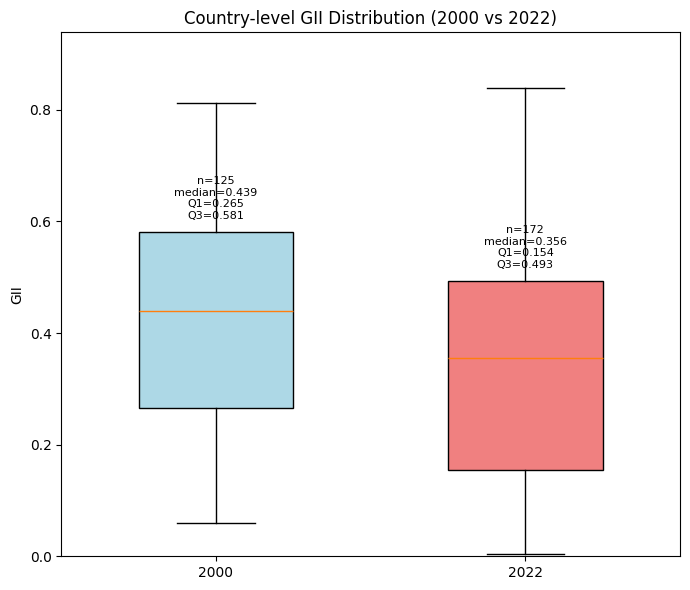

In [80]:
import matplotlib.pyplot as plt
import numpy as np

def collect_country_gii(docs):
    """
    Extract GII values for country-level units only.
    """
    return [d["gii"] for d in docs if is_country_iso(d["isoCode"])]

gii_country_2000 = collect_country_gii(docs_gii_2000)
gii_country_2022 = collect_country_gii(docs_gii_2022)

print("Countries 2000:", len(gii_country_2000))
print("Countries 2022:", len(gii_country_2022))

# ----- Draw boxplot -----
fig, ax = plt.subplots(figsize=(7, 6))

box_data = [gii_country_2000, gii_country_2022]
positions = [0, 1]
labels = ["2000", "2022"]

bp = ax.boxplot(
    box_data,
    positions=positions,
    widths=0.5,
    patch_artist=True,
    showfliers=False  # hide outliers for cleaner appearance
)

colors = ["lightblue", "lightcoral"]
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)

# ----- Annotate key statistics for each box -----
for pos, data in zip(positions, box_data):
    if not data:
        continue
    arr = np.array(data)
    n = len(arr)
    median = np.median(arr)
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)

    # Text annotation slightly above the box
    text = f"n={n}\nmedian={median:.3f}\nQ1={q1:.3f}\nQ3={q3:.3f}"
    ax.text(
        pos,            # x
        q3 + 0.02,      # y (slightly above the upper quartile)
        text,
        ha="center",
        va="bottom",
        fontsize=8
    )

# General formatting
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_ylabel("GII")
ax.set_title("Country-level GII Distribution (2000 vs 2022)")

all_vals = gii_country_2000 + gii_country_2022
if all_vals:
    y_max = max(all_vals)
    ax.set_ylim(0, y_max + 0.1)

plt.tight_layout()
plt.show()

####Analysis:
This graph compares the distribution of the Gender Inequality Index (GII) across countries in 2000 and 2022 using boxplots.
The sample size (n) indicates how many countries had available GII data—125 in 2000 and 172 in 2022—reflecting expanded global coverage in recent years, which is a sign of more and more countries starting to take the gender equality more seriously.

The median represents shows the typical level of gender inequality. It declines from 0.439 in 2000 to 0.356 in 2022, signalling meaningful worldwide progress.

Q1 (the 25th percentile) and Q3 (the 75th percentile) help describe the spread of countries. Both Q1 and Q3 decreases, meaning both the most gender-equal countries and the more unequal countries have become more equal.
Overall, the downward shift of median, Q1, and Q3 shows global reductions in gender inequality over the two decades, though great differences remain among countries.

### Graph 6: Country-level GII distribution (histogram)
This histogram lets us compare how many countries fall into different GII ranges in both 2000 and 2022. And we can compare the GII distribution in two years in order to see the trend, whether the entire global distribution is moving toward lower inequality.


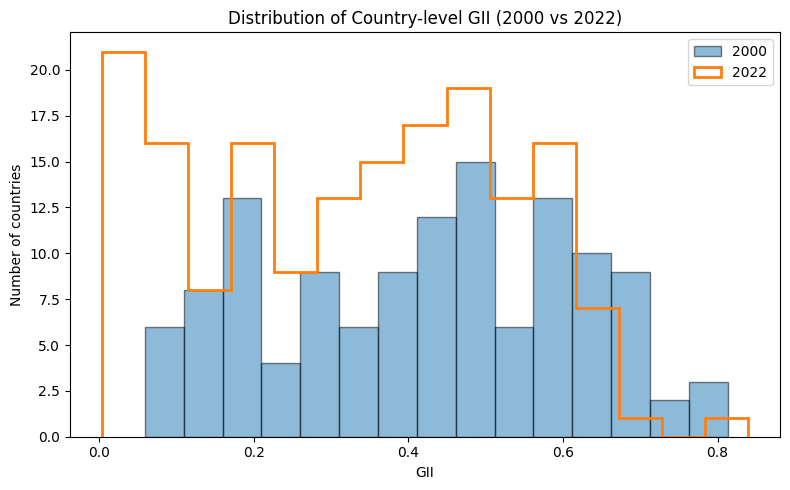

In [81]:
import matplotlib.pyplot as plt

# Reuse gii_country_2000 and gii_country_2022
plt.figure(figsize=(8, 5))

all_vals = gii_country_2000 + gii_country_2022
if all_vals:
    # Use the same bins for both years for a fair comparison
    bins = 15  # you can tune this number

    # Filled histogram for 2000
    plt.hist(
        gii_country_2000,
        bins=bins,
        alpha=0.5,
        edgecolor="black",
        label="2000"
    )

    # Outline histogram for 2022
    plt.hist(
        gii_country_2022,
        bins=bins,
        histtype="step",
        linewidth=2,
        label="2022"
    )

    plt.xlabel("GII")
    plt.ylabel("Number of countries")
    plt.title("Distribution of Country-level GII (2000 vs 2022)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No country-level GII data available.")

####Analysis:
The blue bars represent the distribution of GII in 2000, wihle the orange curve represents the distribution of GII in 2022.
We can clearly see a substantial leftward shift, which indicates the global movement towards lower gender inequality. Notably, in 2000, there were no countries has a GII lower than 0.05. But in 2022, there appear many countries whose GII fall in the range (0, 0.1). Also, in 2022, there were quite a few countries whose GII fall in the high end, but in 2000, there is a sharp decrease.
Overall, this graph shows broad improvement in gender equality across countries over the two decades.



###Graph 7: GII time trends by region
We plot GII trends for major world regions to see whether different parts of the world improve at similar or different speeds.
This shows long-term regional patterns that cannot be seen from single-year comparisons.

A small note: the “regions” in the GII dataset aren’t grouped exactly the same way as the continents in our smoking dataset. But they still represent meaningful large-scale areas, so the trends are still useful for comparing how gender inequality changes across different parts of the world.

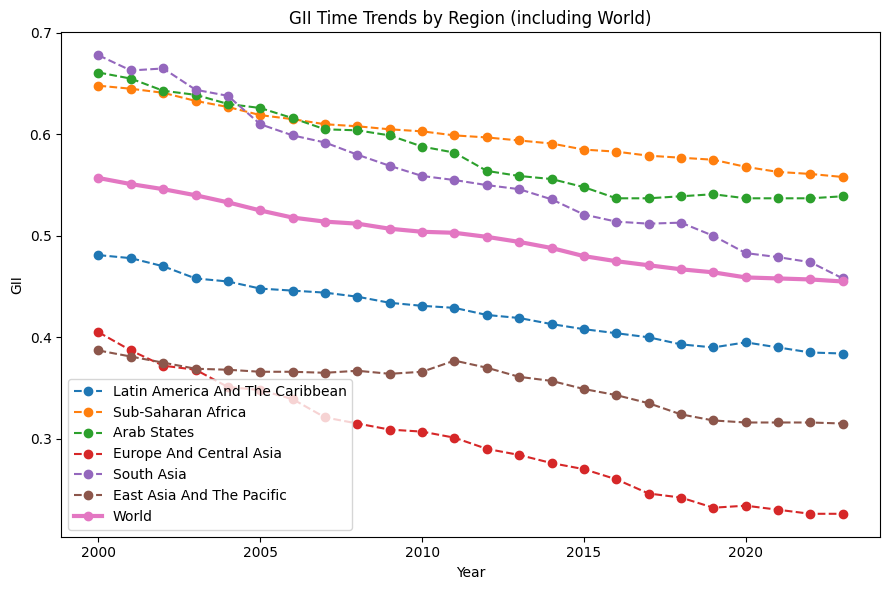

In [82]:
import matplotlib.pyplot as plt

# Build the list of names: regions + World
region_names_with_world = list(REGION_NAMES) + [WORLD_NAME]

# Query MongoDB for their time series
docs_regions = get_gii_trend_for_names_sql(conn, region_names_with_world)
series_regions = build_series_by_name(docs_regions)

plt.figure(figsize=(9, 6))

for name in region_names_with_world:
    if name not in series_regions:
        continue
    s = series_regions[name]
    years = s["years"]
    values = s["gii"]

    # Use thicker solid line for World; dashed for regions
    if name == WORLD_NAME:
        plt.plot(
            years, values,
            marker="o",
            linewidth=3,
            label=name
        )
    else:
        plt.plot(
            years, values,
            marker="o",
            linestyle="--",
            label=name
        )

plt.xlabel("Year")
plt.ylabel("GII")
plt.title("GII Time Trends by Region (including World)")
plt.legend()
plt.tight_layout()
plt.show()

####Analysis:
All regions show a clear downward trend in GII over the past two decades, indicating global movement toward gender equality.
South Asia starts with the highest inequality levels, it is consistently improving, showing the fastest rate of decline.
Europe and Central Asia consistently maintain the lowest GII values and continue to improve at a very fast rate.
The rest regions decline at a similar rate.
The World aggregate line also moves downward, confirming that improvements are global.



### Graphs 8-12
This section constructs the core analysis to help us examine how gender inequality relates to smoking behaviors. We must join GII_data and smoking_rates datasets at the country-year
level in SQL.

We retain the following variables in the joined dataset:

    Smoking-related variables:
        • female_smoking  - female smoking prevalence (%)
        • male_smoking    - male smoking prevalence (%)
        • smoking_gap     - male_smoking - female_smoking (our primary target)

    Gender inequality indicators:
        • gii      - Gender Inequality Index (0-1 scale)
        • abr      - adolescent birth rate (per 1,000 females aged 15-19)
        • se_f     - female secondary education attainment (% ages 25+)
        • lfpr_f   - female labor force participation (% ages 15+)
        • pr_f     - proportion of parliamentary seats held by women (%)
      We include female indicators because we assume female plays an key role in the smoking gap.


### Graph 8: GII vs Smoking Gap (Scatter + Regression), 2000 and 2022

This graph addresses our central research question:

**Does gender inequality correlate with the gender smoking gap?**

Our hypothesis is that countries with higher gender inequality (higher GII values)
tend to exhibit a larger male–female smoking difference  
→ **expected regression slope > 0**.

To observe how this relationship has evolved, we compare two benchmark years:

**2000** (the earliest year with both GII and smoking data) and  
**2022** (the most recent year with both GII and smoking data).

Comparing the regression slopes for these two years allows us to assess whether the influence of gender inequality on smoking differences has strengthened, weakened, or remained stable over the past two decades.

In [83]:
def build_joined_docs_for_year_sql(conn, year):
    """
    Build a joined dataset of GII data and smoking data for a single year (SQLite version).

    The output merges, for each country / region:
        • smoking_rates  (from smoking_rates + regions tables):
            - female_smoking : female smoking prevalence (%)
            - male_smoking   : male smoking prevalence (%)
            - smoking_gap    : male_smoking − female_smoking

        • GII_data  (from GII_data table, pivoted by indicatorCode):
            - gii    : Gender Inequality Index
            - abr    : Adolescent Birth Rate
                       (births per 1,000 women ages 15–19)
            - se_f   : Population with at least some secondary education, female
                       (% of women ages 25 and older)
            - lfpr_f : Labour force participation rate, female
                       (% of women ages 15 and older)
            - pr_f   : Share of seats in parliament, female
                       (% of seats held by women)

    Why we do this join
    -------------------
    For our later graphs (e.g., GII vs smoking gap, indicators vs female smoking),
    we need both:
        • smoking outcomes (female / male prevalence, gap), and
        • gender-inequality–related indicators (GII and its components)
    on the same country and year.

    Doing this join once in SQL gives us a clean merged dataset where each row
    already contains all relevant fields we need for later plotting, so the plotting
    code can stay simple.

    Design considerations
    ---------------------
    • smoking_rates.year is stored as INTEGER.
      GII_data.year is stored as TEXT → we CAST(GII_data.year AS INTEGER)
      so they can be joined on the same numeric year.
    • We only keep female-side indicators (se_f, lfpr_f, pr_f) and do NOT
      compute female/male ratios. This is because:
        - ratios could be unstable when male values are very small or missing.
        - for our research questions we mainly care about how female outcomes
          co-move with smoking, not the exact F/M ratio of each indicator.
    """

    sql = """
    WITH smoking_by_country AS (
        -- Aggregate smoking rates by country and year, and attach the region name.
        SELECT
            s.isoCode,
            r.name AS region,
            s.year,
            MAX(CASE WHEN s.gender = 'female' THEN s.rate END) AS female_smoking,
            MAX(CASE WHEN s.gender = 'male'   THEN s.rate END) AS male_smoking
        FROM smoking_rates AS s
        JOIN regions AS r
            ON r.IsoCode = s.isoCode
        WHERE s.year = ?
        GROUP BY s.isoCode, r.name, s.year
    ),
    gii_pivot AS (
        -- Pivot GII_data so that each indicator becomes a column.
        -- GII_data.year is TEXT, so we CAST it to INTEGER (year_int).
        SELECT
            isoCode,
            CAST(year AS INTEGER) AS year_int,

            MAX(CASE WHEN indicatorCode = 'gii'    THEN CAST(value AS DOUBLE) END) AS gii,
            MAX(CASE WHEN indicatorCode = 'abr'    THEN CAST(value AS DOUBLE) END) AS abr,
            MAX(CASE WHEN indicatorCode = 'se_f'   THEN CAST(value AS DOUBLE) END) AS se_f,
            MAX(CASE WHEN indicatorCode = 'lfpr_f' THEN CAST(value AS DOUBLE) END) AS lfpr_f,
            MAX(CASE WHEN indicatorCode = 'pr_f'   THEN CAST(value AS DOUBLE) END) AS pr_f
        FROM GII_data
        GROUP BY isoCode, CAST(year AS INTEGER)
    ),
    joined AS (
        -- Inner join: keep only rows that have BOTH smoking data and GII indicators.
        SELECT
            s.isoCode,
            s.region,
            s.year,
            s.female_smoking,
            s.male_smoking,
            (s.male_smoking - s.female_smoking) AS smoking_gap,

            g.gii,
            g.abr,
            g.se_f,
            g.lfpr_f,
            g.pr_f
        FROM smoking_by_country AS s
        JOIN gii_pivot AS g
          ON g.isoCode = s.isoCode
         AND g.year_int = s.year
    )
    SELECT *
    FROM joined;
    """

    cur = conn.cursor()
    cur.execute(sql, (int(year),))
    rows = cur.fetchall()

    docs = []
    for row in rows:
        (
            isoCode,
            region,
            year,
            female_smoking,
            male_smoking,
            smoking_gap,
            gii,
            abr,
            se_f,
            lfpr_f,
            pr_f,
        ) = row

        docs.append({
            "isoCode": isoCode,
            "region": region,
            "year": year,
            "female_smoking": female_smoking,
            "male_smoking": male_smoking,
            "smoking_gap": smoking_gap,
            "gii": gii,
            "abr": abr,
            "se_f": se_f,
            "lfpr_f": lfpr_f,
            "pr_f": pr_f,
        })

    return docs

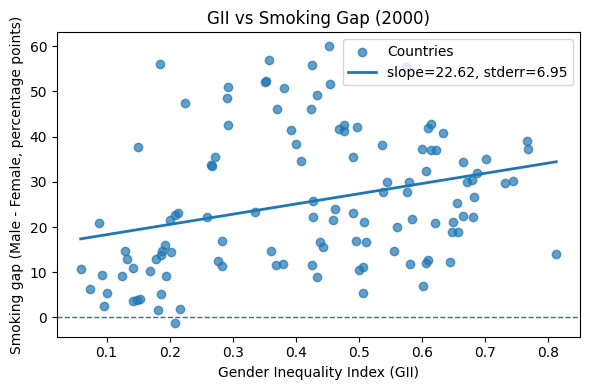

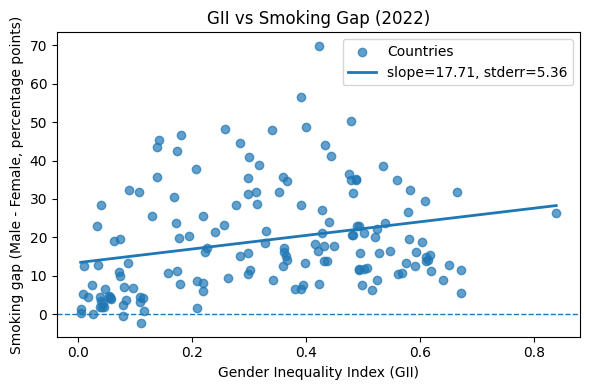

In [84]:
# 2) Extract (x, y) for plotting GII vs smoking gap

def build_gii_vs_smoking_gap_dataset(docs):
    """
    Extract (gii, smoking_gap) pairs from the joined docs.

    We use:
        x = gii
        y = smoking_gap  (male_smoking - female_smoking)

    Rows with missing gii or smoking_gap are skipped as a safety check to implement the principle of defensive programming,
    although the joined dataset itself is complete.
    """
    gii_vals = []
    gap_vals = []

    for d in docs:
        gii = d.get("gii")
        gap = d.get("smoking_gap")

        if gii is not None and gap is not None:
            gii_vals.append(float(gii))
            gap_vals.append(float(gap))

    return gii_vals, gap_vals


# 3) Scatter plot + regression line

def plot_gii_vs_smoking_gap_sql(docs, year, title_prefix="GII vs Smoking Gap"):
    """
    Draw a scatter plot and a simple linear regression line for:
        x = GII
        y = smoking_gap  (male_smoking - female_smoking)

    The input docs are produced by build_joined_docs_for_year_sql().
    """
    gii_vals, gap_vals = build_gii_vs_smoking_gap_dataset(docs)

    if len(gii_vals) == 0:
        print(f"[{year}] No valid data points to plot.")
        return

    x = np.array(gii_vals)
    y = np.array(gap_vals)

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.7, label="Countries")
    plt.axhline(0, linestyle="--", linewidth=1)

    # coeffs[0] = slope, coeffs[1] = intercept
    # cov[0,0] = variance of the slope  →  sqrt
    coeffs, cov = np.polyfit(x, y, 1, cov=True)
    slope = coeffs[0]
    intercept = coeffs[1]
    slope_stderr = np.sqrt(cov[0, 0])

    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept

    plt.plot(
        x_line,
        y_line,
        linewidth=2,
        label=f"slope={slope:.2f}, stderr={slope_stderr:.2f}"
    )

    plt.xlabel("Gender Inequality Index (GII)")
    plt.ylabel("Smoking gap (Male - Female, percentage points)")
    plt.title(f"{title_prefix} ({year})")
    plt.legend()
    plt.tight_layout()
    plt.show()


conn = sqlite3.connect("project3.db")

docs_2000 = build_joined_docs_for_year_sql(conn, 2000)
plot_gii_vs_smoking_gap_sql(docs_2000, 2000)

docs_2022 = build_joined_docs_for_year_sql(conn, 2022)
plot_gii_vs_smoking_gap_sql(docs_2022, 2022)

#### Analysis:
**1. GII has a positive relationship with GII.**

This means that countries with higher gender inequality tend to have larger smoking gap where men smoke significantly more than women.

**2. From 2000 to 2022, the positive association weakened (from 22.6 to 17.7).**

This suggests that the smoking gap has become less sensitive to differences in GII.

**3. The points in 2022 is more concentrated at lower GII values, reflecting global improvements in gender equality.**

### Graph 9: GII vs female/male smoking rate 2000 and 2022
Having observed in Graph 8 that countries with higher gender inequality tend to exhibit larger smoking gaps—and that this association has weakened from 2000 to 2022.

So, we want to examine which side of the gap is contributing to this pattern.
Specifically, we ask:

**Does gender inequality correlate with female smoking and male smoking separately?**

Because the smoking gap is defined as (male – female), decomposing the gap into its two components allows us to identify whether the relationship with GII is primarily driven by higher male prevalence, lower female prevalence, or both.

By comparing the regression slopes for 2000 and 2022, we can assess whether the
influence of gender inequality on smoking behavior has changed differently for women and men over the past two decades.


In [85]:
import numpy as np
import matplotlib.pyplot as plt

# Helper: extract (GII, rate) pairs

def build_gii_vs_rate_dataset(docs, rate_field):
    """
    Extract (gii, rate) pairs from joined docs.

    Parameters
    ----------
    docs : list of dict
        Output of build_joined_docs_for_year_sql.
    rate_field : str
        Either 'female_smoking' or 'male_smoking'.

    Returns
    -------
    gii_vals : list[float]
    rate_vals : list[float]
    """
    gii_vals = []
    rate_vals = []

    for d in docs:
        gii = d.get("gii")
        rate = d.get(rate_field)

        if gii is not None and rate is not None:
            gii_vals.append(float(gii))
            rate_vals.append(float(rate))

    return gii_vals, rate_vals


# Helper: plot one scatter + regression

def plot_gii_vs_rate_sql(docs, year, rate_field, rate_label,
                         title_prefix="GII vs smoking rate"):
    """
    Draw a scatter plot and regression line for:
        x = GII
        y = (female or male smoking rate)
    using the SQL-generated docs.

    Parameters
    ----------
    docs : list of dict
        Output of build_joined_docs_for_year_sql.
    year : int
        Year to show in the title.
    rate_field : str
        'female_smoking' or 'male_smoking'.
    rate_label : str
        Text for y-axis label, e.g. 'Female smoking prevalence (%)'.
    title_prefix : str
        Prefix for the figure title.
    """
    gii_vals, rate_vals = build_gii_vs_rate_dataset(docs, rate_field)

    if len(gii_vals) == 0:
        print(f"[{year}] No valid data points to plot for {rate_field}.")
        return

    x = np.array(gii_vals)
    y = np.array(rate_vals)

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.7, label="Countries")
    plt.axhline(0, linestyle="--", linewidth=1)

    # Regression line
    # coeffs[0] = slope, coeffs[1] = intercept
    # cov[0,0] = variance of the slope  →  sqrt
    coeffs, cov = np.polyfit(x, y, 1, cov=True)
    slope = coeffs[0]
    intercept = coeffs[1]
    slope_stderr = np.sqrt(cov[0, 0])

    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept

    plt.plot(
        x_line,
        y_line,
        linewidth=2,
        label=f"slope={slope:.2f}, stderr={slope_stderr:.2f}"
    )

    plt.xlabel("Gender Inequality Index (GII)")
    plt.ylabel(rate_label)
    plt.title(f"{title_prefix} ({year})")
    plt.legend()
    plt.tight_layout()
    plt.show()

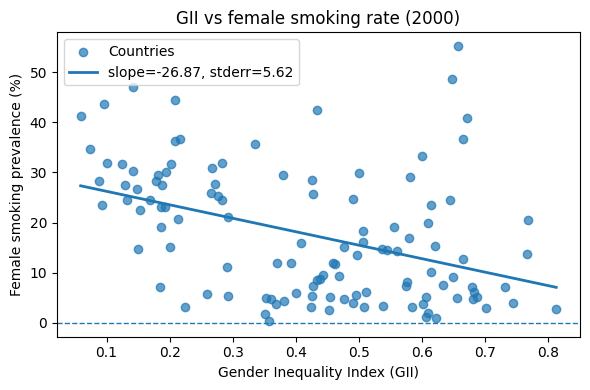

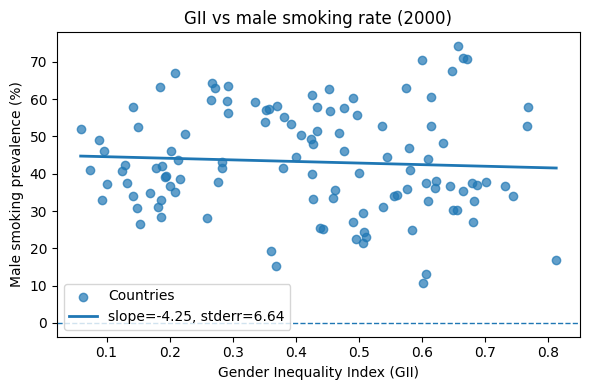

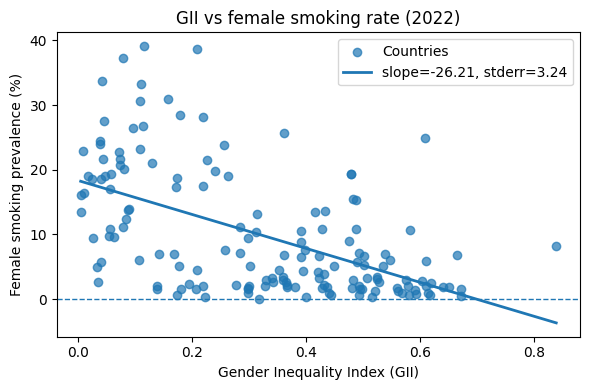

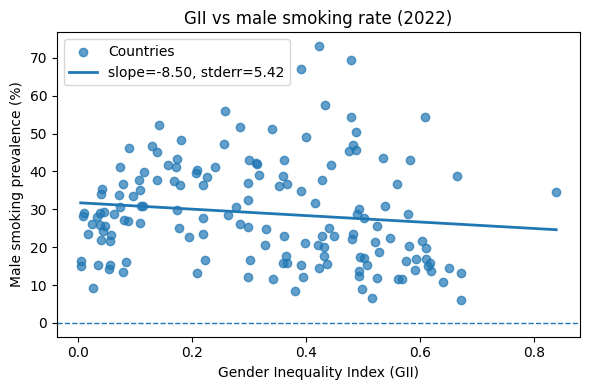

In [86]:
import sqlite3

conn = sqlite3.connect("project3.db")

# Build joined docs for the two years
docs_2000 = build_joined_docs_for_year_sql(conn, 2000)
docs_2022 = build_joined_docs_for_year_sql(conn, 2022)

# 1) 2000, GII vs female smoking
plot_gii_vs_rate_sql(
    docs_2000,
    year=2000,
    rate_field="female_smoking",
    rate_label="Female smoking prevalence (%)",
    title_prefix="GII vs female smoking rate"
)

# 2) 2000, GII vs male smoking
plot_gii_vs_rate_sql(
    docs_2000,
    year=2000,
    rate_field="male_smoking",
    rate_label="Male smoking prevalence (%)",
    title_prefix="GII vs male smoking rate"
)

# 3) 2022, GII vs female smoking
plot_gii_vs_rate_sql(
    docs_2022,
    year=2022,
    rate_field="female_smoking",
    rate_label="Female smoking prevalence (%)",
    title_prefix="GII vs female smoking rate"
)

# 4) 2022, GII vs male smoking
plot_gii_vs_rate_sql(
    docs_2022,
    year=2022,
    rate_field="male_smoking",
    rate_label="Male smoking prevalence (%)",
    title_prefix="GII vs male smoking rate"
)

#### Analysis:

**1. Female smoking is strongly and consistently negatively associated with GII.**

In both 2000 and 2022, countries with higher gender inequality tend to have much lower female smoking rates, with slopes around -27 in both years.
This relationship is strong, stable, and statistically precise (smaller stderr in 2022).

**2. Male smoking shows only a weak negative association with GII.**

For men, slopes are close to zero (about -4.25 in 2000 and -8.50 in 2022), and the relationship is much noisier.
This suggests that gender inequality has much less influence on male smoking behavior than on female smoking.

**3. Comparing 2000 and 2022 reveals that the female-GII relationship remains strong, while the male-GII relationship stays weak.**

This asymmetry implies that the positive slope we observed earlier for the smoking gap (Graph 8) is driven almost entirely by women:
**as inequality rises, women smoke significantly less, while men smoke only slightly less.**

### Graph 10: Correlation over time (2000-2022)
While the slope analysis shows how strongly changes in GII translate into changes in smoking outcomes, correlation helps answer a related but distinct question:

**How stable is the linear association between gender inequality and smoking behavior over time?**

For each year from 2000 to 2022, we compute the Pearson correlation coefficient between GII and three outcomes—smoking gap, female smoking, and male smoking.
Plotting these correlations as time series allows us to observe whether the strength of the GII–smoking relationship has remained consistent, grown stronger, or weakened across the last two decades.


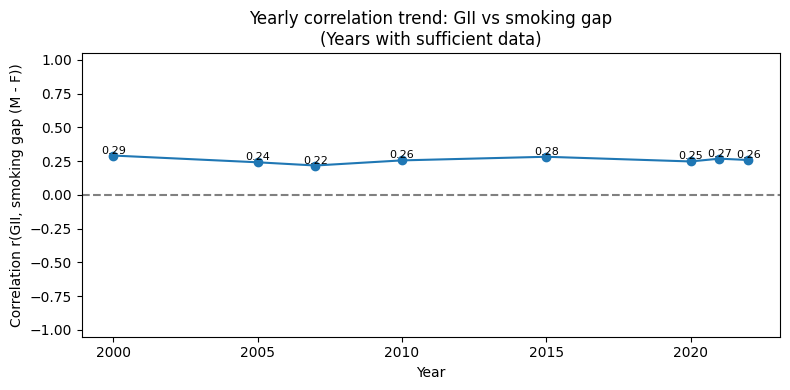

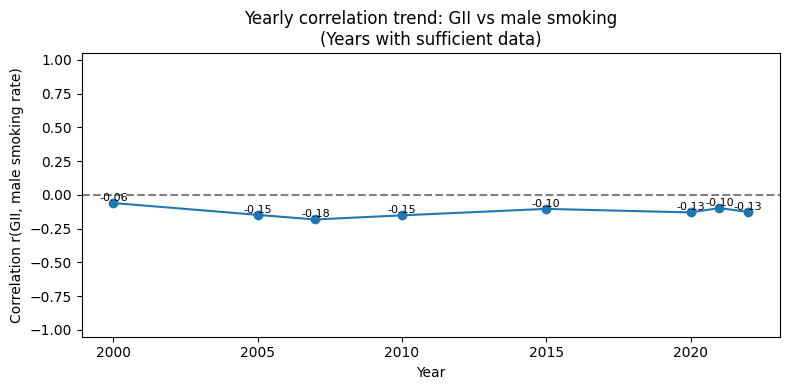

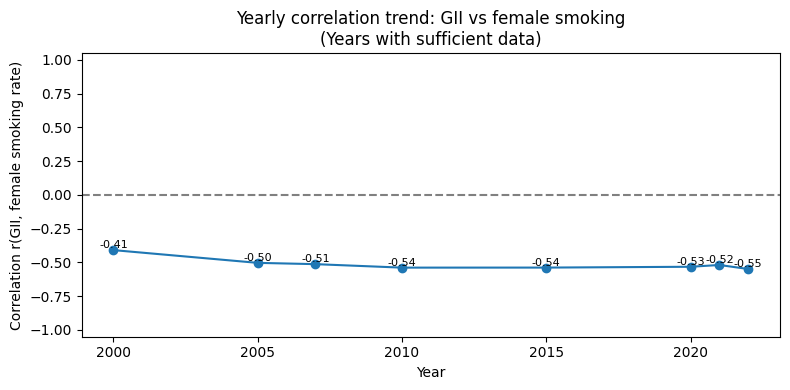

In [87]:
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

def plot_yearly_correlation_trend_sql(conn,
                                      start_year,
                                      end_year,
                                      target_field,
                                      target_label,
                                      title_prefix):
    """
    SQL version of yearly correlation trend.

    For each year in [start_year, end_year]:
        1. Use build_joined_docs_for_year_sql(conn, year) to get joined docs
           (smoking + GII) for that year.
        2. Extract all valid (GII, target_field) pairs.
        3. Run linear regression: target_field ~ GII
           and record the Pearson correlation coefficient r.
    Finally, plot r vs year as a time-series line (r in [-1, 1]).
    """

    years = []
    rs = []

    for year in range(start_year, end_year + 1):
        docs = build_joined_docs_for_year_sql(conn, year)

        x_vals = []
        y_vals = []
        for d in docs:
            gii = d.get("gii")
            tgt = d.get(target_field)
            if gii is not None and tgt is not None:
                x_vals.append(float(gii))
                y_vals.append(float(tgt))

        # need at least a few points to make correlation meaningful
        if len(x_vals) < 5:
            continue

        # linregress returns rvalue in addition to slope
        result = linregress(x_vals, y_vals)
        r = result.rvalue   # Pearson correlation coefficient

        years.append(year)
        rs.append(r)

    if not years:
        print(f"No valid years for {target_field} (correlation).")
        return

    # Plot correlation over time
    plt.figure(figsize=(8, 4))
    plt.plot(years, rs, marker="o")
    plt.axhline(0, linestyle="--", color="gray")

    # optional: annotate each point
    for yr, r in zip(years, rs):
        plt.text(yr, r, f"{r:.2f}", fontsize=8,
                 ha="center", va="bottom")

    plt.xlabel("Year")
    plt.ylabel(f"Correlation r(GII, {target_label})")
    plt.ylim(-1.05, 1.05)  # r is always in [-1, 1]
    plt.title(f"{title_prefix}\n(Years with sufficient data)")
    plt.tight_layout()
    plt.show()

conn = sqlite3.connect("project3.db")

plot_yearly_correlation_trend_sql(
    conn,
    2000, 2022,
    "smoking_gap",
    "smoking gap (M - F)",
    "Yearly correlation trend: GII vs smoking gap"
)

plot_yearly_correlation_trend_sql(
    conn,
    2000, 2022,
    "male_smoking",
    "male smoking rate",
    "Yearly correlation trend: GII vs male smoking"
)

plot_yearly_correlation_trend_sql(
    conn,
    2000, 2022,
    "female_smoking",
    "female smoking rate",
    "Yearly correlation trend: GII vs female smoking"
)

#### Analysis
Across all three correlation trends, the values remain fairly stable over time, showing no major upward or downward shift. This means the relationship between GII and smoking behaviors has been persistent rather than evolving dramatically.

More specifically:
1. **GII vs smoking gap stays positive and moderate (0.22-0.29)**, meaning higher gender inequality is consistently associated with a larger difference between male and female smoking.
2. **GII vs male smoking stays near zero,** indicating almost no relationship; male smoking patterns seem unaffected by changes in gender inequality.
3. **GII vs female smoking remains strongly negative (around -0.50),** showing a stable pattern where lower gender inequality is linked to higher female smoking levels.

Therefore, we can see female smoking is more sensitive to social conditions than male smoking. In societies with greater gender equality, women have more autonomy and social visibility, which may lead to lifestyle patterns—including smoking—that are closer to men's.

This may suggest some targeted anti-smoking programs for women in gender-equal societies.


### Graph 11: GII indicators vs female smoking
After observing in Graph 9 that the **negative association between GII and smoking is driven mostly by women**, we next want to examine why gender inequality might relate so strongly to female smoking.

To do this, we choose several GII key components that capture different dimensions of women's social and economic status:
- **Adolescent Birth Rate (abr)**:
births per 1,000 women ages 15-19
- **Female secondary education (se_f)**: Population with at least some secondary education, female (% ages 25 and older)
- **Female labour-force participation (lfpr_f)**: Labour force participation rate, female (% ages 15 and older)
- **Female parliamentary representation (pr_f)**: Share of seats in parliament, female (% held by women)

We assume these indicators might have distinct mechanisms on gender inequality and then influence women's smoking behaviors.

To evaluate how each dimension relates to female smoking, we plot:

**indicator value (x) vs. female smoking prevalence (y) for both 2000 and 2022.**


plot_indicator_vs_target is a helper function we could reuse to draw graphs later.

In [88]:
import numpy as np
import matplotlib.pyplot as plt

def plot_indicator_vs_target(docs, year,
                             indicator_field, indicator_label,
                             target_field, target_label,
                             title_prefix):
    """
    Plot indicator (x) vs target smoking measure (y).
    Used for abr, se_f, lfpr_f, pr_f vs female_smoking.
    """

    xs = []
    ys = []

    for d in docs:
        x = d.get(indicator_field)
        y = d.get(target_field)

        if x is not None and y is not None:
            xs.append(float(x))
            ys.append(float(y))

    xs = np.array(xs)
    ys = np.array(ys)

    plt.figure(figsize=(6, 4))
    plt.scatter(xs, ys, alpha=0.7, label="Countries")
    plt.axhline(0, linestyle="--", linewidth=1)

    # linear regression
    # coeffs[0] = slope, coeffs[1] = intercept
    # cov[0,0] = variance of the slope  →  sqrt
    coeffs, cov = np.polyfit(xs, ys, 1, cov=True)
    slope = coeffs[0]
    intercept = coeffs[1]
    slope_stderr = np.sqrt(cov[0, 0])

    x_line = np.linspace(xs.min(), xs.max(), 100)
    y_line = slope * x_line + intercept

    plt.plot(
        x_line,
        y_line,
        linewidth=2,
        label=f"slope={slope:.2f}, stderr={slope_stderr:.2f}"
    )

    plt.xlabel(indicator_label)
    plt.ylabel(target_label)
    plt.title(f"{title_prefix} ({year})")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [89]:
indicator_list = [
    ("abr", ["Adolescent Birth Rate", "Adolescent Birth Rate (births per 1,000 women ages 15-19)"]),
    ("se_f", ["Female secondary education", "Population with some secondary education, female (% ages 25 and older)"]),
    ("lfpr_f", ["Female labour force participation", "Labour force participation rate, female (% ages 15 and older)"]),
    ("pr_f",  ["Female parliament participation", "Share of seats in parliament, female (% held by women)"])
]

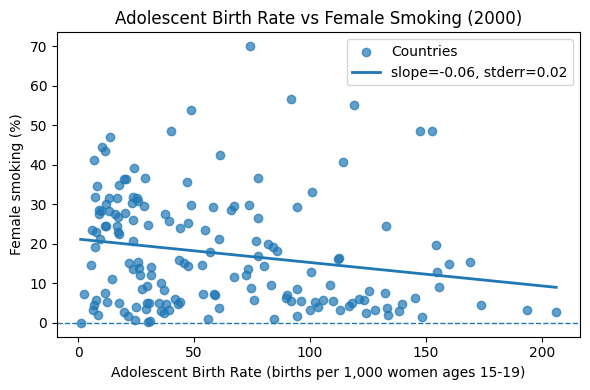

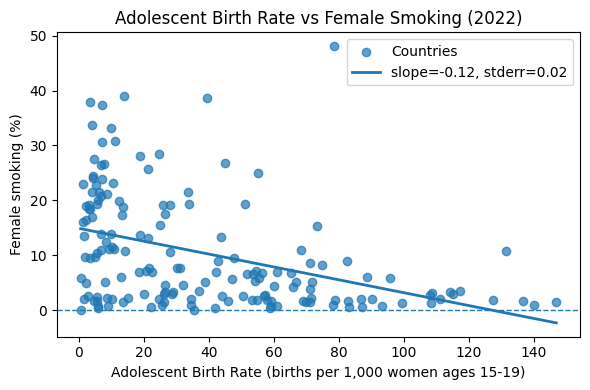

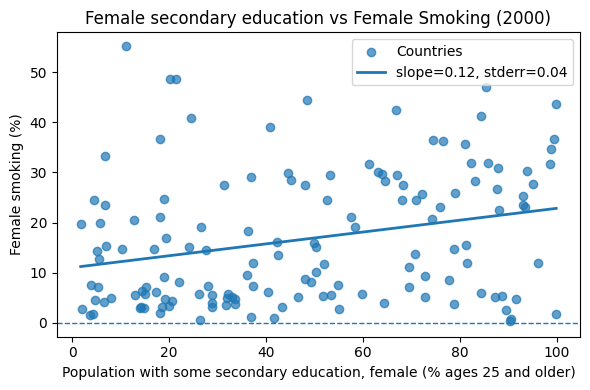

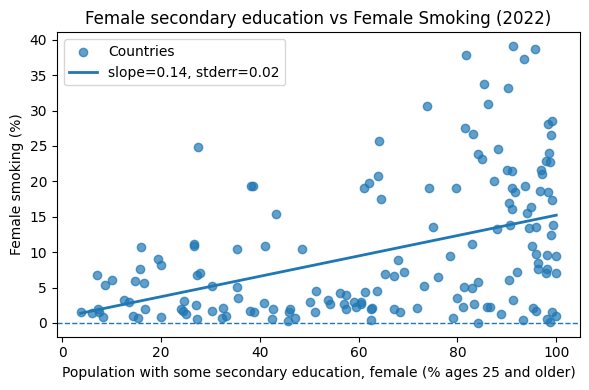

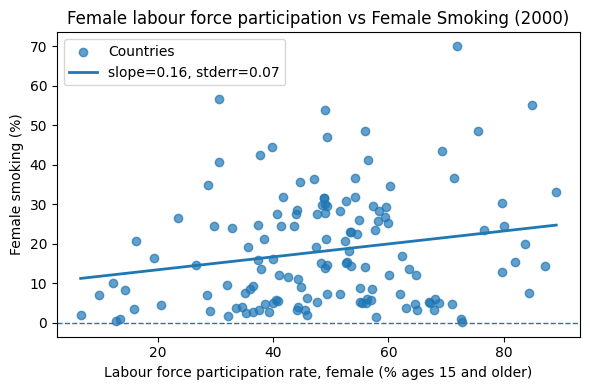

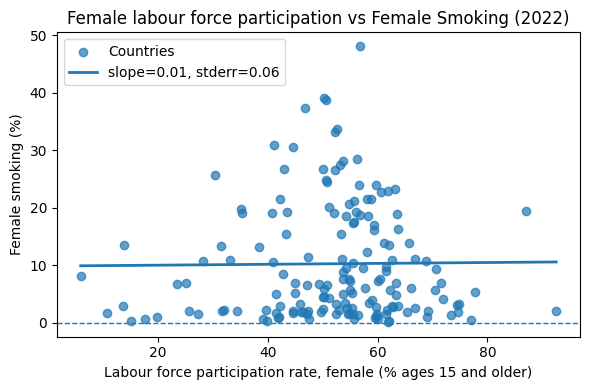

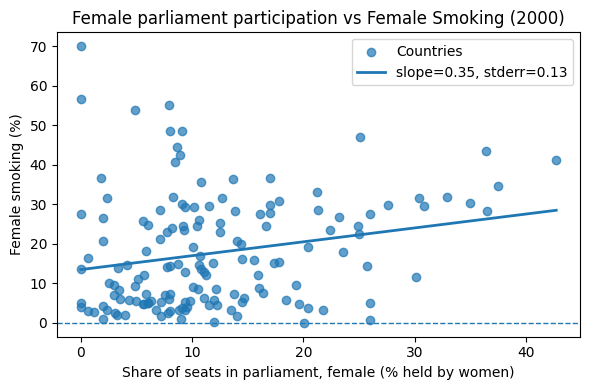

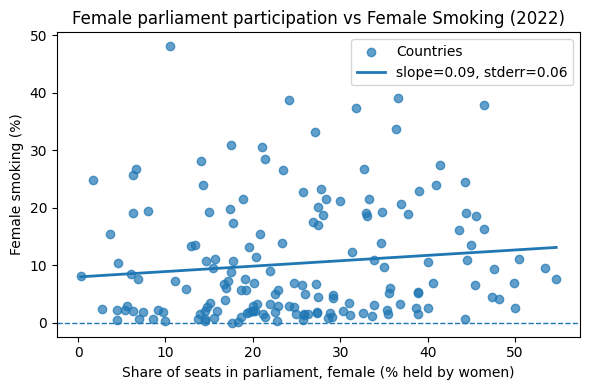

In [90]:
for indicator, label in indicator_list:
    # 2000
    plot_indicator_vs_target(
        docs_2000, 2000,
        indicator_field=indicator,
        indicator_label=label[1],
        target_field="female_smoking",
        target_label="Female smoking (%)",
        title_prefix=f"{label[0]} vs Female Smoking"
    )

    # 2022
    plot_indicator_vs_target(
        docs_2022, 2022,
        indicator_field=indicator,
        indicator_label=label[1],
        target_field="female_smoking",
        target_label="Female smoking (%)",
        title_prefix=f"{label[0]} vs Female Smoking"
    )

#### Analysis:
**1. adolescent birth rate and female smoking:**

In both 2000 and 2022, adolescent birth rate shows a negative relationship with female smoking. **Countries with high abr — usually more traditional and less gender-equal — have very low female smoking rates, while countries with low abr show a much wider range and, on average, higher female smoking prevalence.**

The stronger negative slope in 2022 suggests that as societies improve women's rights and reduce adolescent births, female smoking becomes more common and more variable. This supports our idea that the stereotype “smoking is a male behavior” is shaped by gender inequality, not biology.

Practically, the results show that countries reducing abr should include gender-sensitive anti-smoking policies, especially for young women, while high-equality countries should design health campaigns that specifically address female smoking patterns.

**2. female secondary education and female smoking:**

The comparison between 2000 and 2022 shows that the exact slope difference is not the key insight. **What matters is that female smoking becomes more structured and more varied in countries with high female education, while female smoking rate in countries with low education goes nearly zero.** This suggests that as women gain education and autonomy, their smoking behavior is no longer tightly restricted by traditional norms, leading to a wider range of choices.

This challenges the stereotype that smoking is mainly associated with “low-education girls.” Our data shows that highly educated women also smoke, possibly influenced by social freedom, workplace stress, and cultural norms. For public health, this means anti-smoking campaigns must not overlook educated women and should include targeted interventions that address the pressures and environments they face.

**3. female labour force participation and female smoking:**

The scatter plots show that the relationship between female labour force participation and female smoking is not linear. Instead, both years display a triangle-shaped pattern: **the highest female smoking rate range appear in countries with mid-level participation (40-60%)**, suggesting that smoking becomes more common in societies undergoing gender-norm transitions. It indicates that tobacco-control efforts should also focus on those in emerging or transitional labour markets where smoking may become a marker of autonomy or modern identity.

**4. female parliament participation and female smoking:**

**Female political representation has very little relationship with female smoking, especially in recent years.** In 2000, the slope is mildly positive, but the points are widely scattered and the pattern is weak. By 2022, the slope becomes almost flat, showing no meaningful association at all.

This suggests that female smoking is not strongly influenced by how many women hold seats in parliament. As global smoking rates decline and health messaging becomes widespread, political empowerment no longer predicts whether women smoke. In practice, this means anti-smoking interventions should focus more on social norms, stress, cultural restrictions, and economic factors, rather than on political representation.



###Graph 12: GII indicators vs smoking gap (male - female)

After examining GII indicator's relationship with female smoking, we also want to look at their relationships with man and women's smoking gap. This motivates our next analysis:

**How does GII indicators relate to the gender smoking gap?**

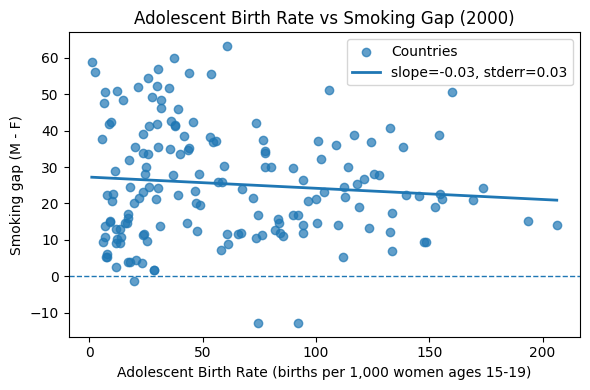

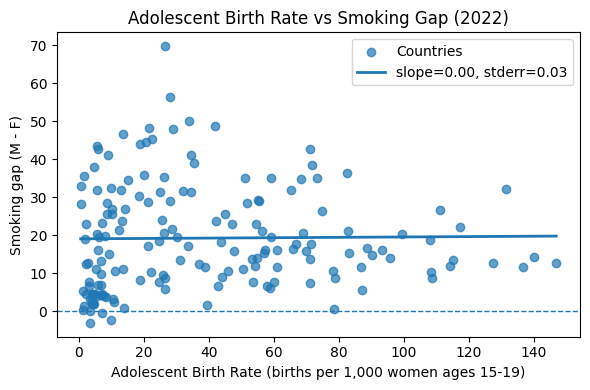

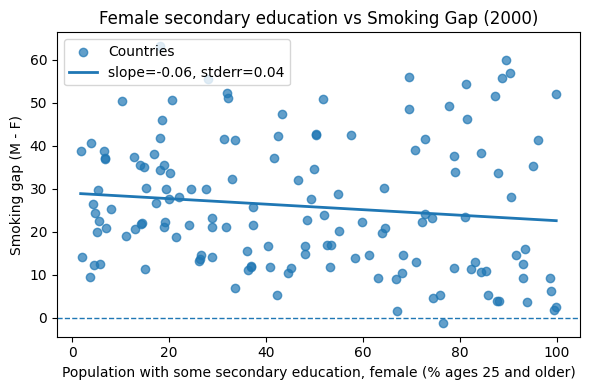

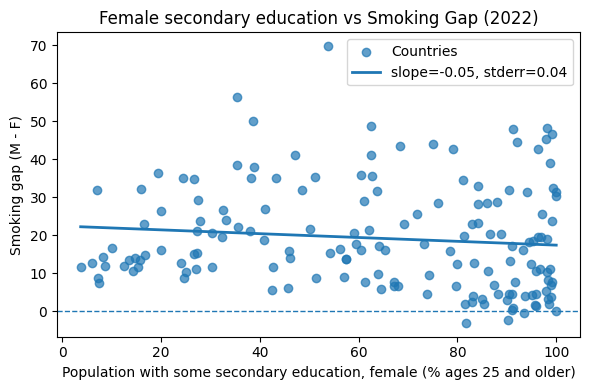

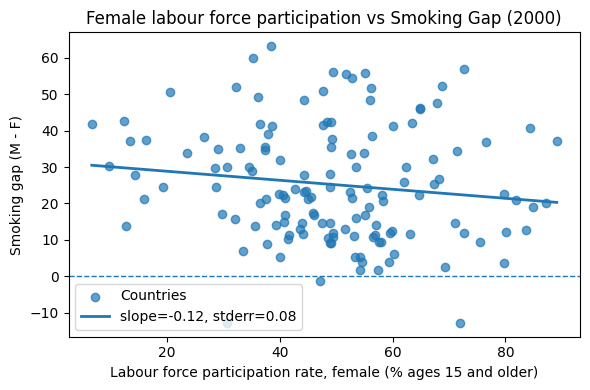

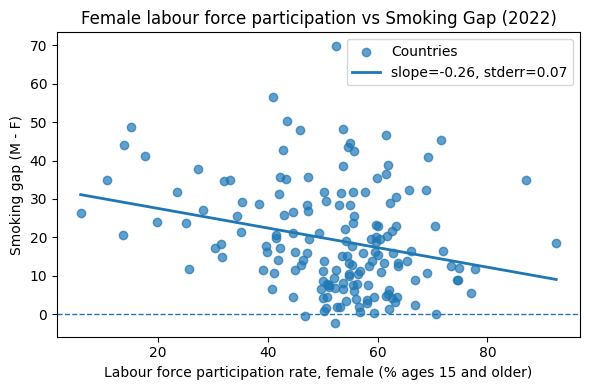

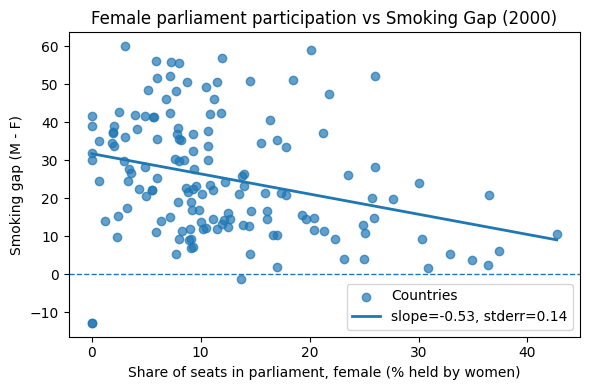

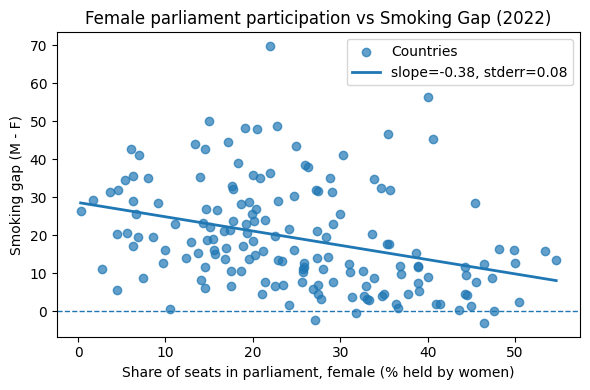

In [91]:
for indicator, label in indicator_list:
    # 2000
    plot_indicator_vs_target(
        docs_2000, 2000,
        indicator_field=indicator,
        indicator_label=label[1],
        target_field="smoking_gap",
        target_label="Smoking gap (M - F)",
        title_prefix=f"{label[0]} vs Smoking Gap"
    )

    # 2022
    plot_indicator_vs_target(
        docs_2022, 2022,
        indicator_field=indicator,
        indicator_label=label[1],
        target_field="smoking_gap",
        target_label="Smoking gap (M - F)",
        title_prefix=f"{label[0]} vs Smoking Gap"
    )

#### Analysis
Across all four indicators, the slopes are very small and mostly negative, and the scatter plots do not show strong or stable patterns. This tells us that individual GII indicators do not meaningfully predict the gender smoking gap, even though some of them strongly relate to female smoking alone.

**1. Adolescent Birth Rate (ABR) → almost no relationship**

Both years show slopes near zero.
High-ABR countries have low female autonomy, but male smoking remains high everywhere, so the gap stays large regardless of ABR.

This means that smoking gap is not driven by teenage reproductive inequality; it reflects broader gender norms that affect male and female smoking differently.

**2. Female secondary education → weak negative relationship**

Higher female education is weakly associated with a slightly smaller smoking gap, because female smoking increases a little while male smoking remains stable.

But the effect is tiny, and the cloud is extremely scattered.

This means that education may change female smoking more than male smoking, but the gap itself is controlled by other social forces (masculinity norms, cultural stigma toward female smoking).

**3. Female labour force participation → modest negative slope, but weak overall**

Countries with higher female workforce participation tend to have slightly smaller smoking gaps — again because female smoking rises a bit while male smoking barely changes.

But the relationship is inconsistent across countries.

This means that labour participation may increase women's autonomy and exposure to smoking environments, but it still does not reshape the gendered nature of smoking at the population level.

**4. Female parliament participation → largest negative slope, but still weak**

This is the only indicator showing a somewhat clearer negative slope:
more women in parliament → smaller smoking gap.

But even here the explanatory power is low, and the scatter remains wide.This means that political empowerment may reflect deeper gender-equality improvements that gradually narrow gender differences in smoking, but the effect is far from strong or direct.

### Graph 13: GII indicators vs Female smoking rate correlation
To verify which indcators have better influence on female smoking rate.
To accomendate the frequency difference, smoking rate is interpolated linearly between the 5 years gap.

Correlation is calculated using Pearson correlation coefficient.

We found these significant correlations: (correlation coeffecients aroudn 0.5)
1. Higher secondary eduaction actually lead more smoking rate, which is around the middle school time. Maybe institutes focusing on teenage health still need to pay attention to female teenage smokers?
2. Adolesence bith rate is negatively related to female smoking rate. This is a subsequent result of low GII in certain areas. If female safety is not well protected, we may not need to pay a lot of attention to their smoking risks.

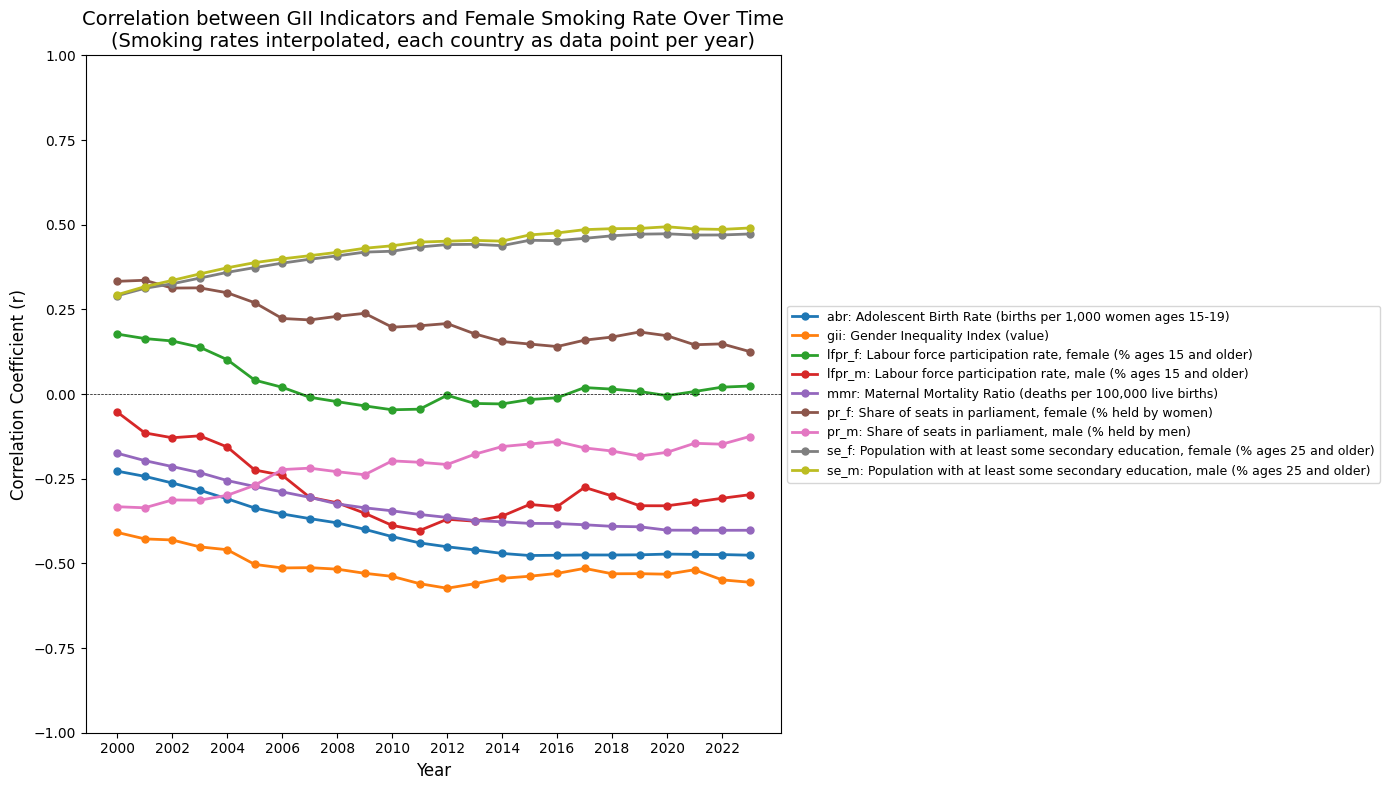

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

def get_gii_countries_sql(conn):
  # only get the countries with the GII indicator value, as it is the smallest subgroup with all the other indicators
  """Find countries that have GII indicator (indicatorCode='gii') and smoking data"""
  cursor = conn.cursor()
  cursor.execute('''
      SELECT DISTINCT g.IsoCode
      FROM GII_data g
      WHERE g.indicatorCode = 'gii'
      AND g.IsoCode IN (SELECT DISTINCT IsoCode FROM smoking_rates)
  ''')
  return [row[0] for row in cursor.fetchall()]


def get_correlation_data_sql(conn):
    """Get GII indicators and female smoking rates by country and year"""
    cursor = conn.cursor()
    gii_countries = get_gii_countries_sql(conn)
    placeholders = ','.join(['?' for _ in gii_countries])

    # Get GII data (excluding rank indicators, this is not a valid indicator to check)
    cursor.execute(f'''
        SELECT g.IsoCode, g.indicatorCode, i.name, g.year, g.value
        FROM GII_data g
        JOIN GII_indicators i ON g.indicatorCode = i.indicatorCode
        WHERE g.IsoCode IN ({placeholders})
        AND g.indicatorCode != 'gii_rank'
        ORDER BY g.year, g.indicatorCode, g.IsoCode
    ''', gii_countries)
    gii_results = cursor.fetchall()

    # Get female smoking data
    cursor.execute(f'''
        SELECT IsoCode, year, rate
        FROM smoking_rates
        WHERE IsoCode IN ({placeholders})
        AND gender = 'female'
        ORDER BY IsoCode, year
    ''', gii_countries)
    smoking_results = cursor.fetchall()

    return gii_results, smoking_results


def draw_correlation_plot(gii_results, smoking_results):
    """Draw line graph showing correlation over time for each GII indicator"""

    # Organize smoking data by country
    smoking_by_country = {}
    for iso, year, rate in smoking_results:
        if iso not in smoking_by_country:
            smoking_by_country[iso] = {'years': [], 'rates': []}
        smoking_by_country[iso]['years'].append(year)
        smoking_by_country[iso]['rates'].append(rate)

    # Create interpolation functions for each country
    smoking_interp = {}
    for iso, data in smoking_by_country.items():
        if len(data['years']) >= 2:
            smoking_interp[iso] = interp1d(
                data['years'], data['rates'],
                kind='linear', fill_value='extrapolate'
            )

    # Organize GII data by (indicator, year) -> list of (country, value)
    indicator_names = {}
    gii_by_indicator_year = {}

    for iso, indicator_code, indicator_name, year, value in gii_results:
        indicator_names[indicator_code] = indicator_name
        key = (indicator_code, year)
        if key not in gii_by_indicator_year:
            gii_by_indicator_year[key] = []
        gii_by_indicator_year[key].append((iso, value, year))

    # Calculate correlation for each indicator and year
    correlations_by_indicator = {code: {'years': [], 'corrs': []} for code in indicator_names.keys()}

    for (indicator_code, year), country_values in gii_by_indicator_year.items():
        gii_values = []
        smoking_values = []

        for iso, value, yr in country_values:
            if iso in smoking_interp:
                interpolated_smoking = float(smoking_interp[iso](yr))
                gii_values.append(value)
                smoking_values.append(interpolated_smoking)

        if len(gii_values) > 2:
            corr = np.corrcoef(gii_values, smoking_values)[0, 1]
            correlations_by_indicator[indicator_code]['years'].append(year)
            correlations_by_indicator[indicator_code]['corrs'].append(corr)

    # Sort by year for each indicator
    for code in correlations_by_indicator:
        data = correlations_by_indicator[code]
        sorted_pairs = sorted(zip(data['years'], data['corrs']))
        data['years'] = [p[0] for p in sorted_pairs]
        data['corrs'] = [p[1] for p in sorted_pairs]

    # Draw line graph
    fig, ax = plt.subplots(figsize=(14, 8))

    colors = plt.cm.tab10.colors

    for idx, (indicator_code, indicator_name) in enumerate(indicator_names.items()):
        data = correlations_by_indicator[indicator_code]
        ax.plot(data['years'], data['corrs'],
                color=colors[idx % len(colors)],
                marker='o', markersize=5, linewidth=2,
                label=f'{indicator_code}: {indicator_name}')

    ax.axhline(y=0, color='black', linewidth=0.5, linestyle='--')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Correlation Coefficient (r)', fontsize=12)
    ax.set_title('Correlation between GII Indicators and Female Smoking Rate Over Time\n(Smoking rates interpolated, each country as data point per year)', fontsize=14)
    ax.set_ylim(-1, 1)

    all_years = set()
    for data in correlations_by_indicator.values():
        all_years.update(data['years'])
    all_years = sorted(all_years)
    ax.set_xticks(all_years[::2])  # Show every 2nd year
    ax.set_xticklabels([int(y) for y in all_years[::2]])

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
    plt.tight_layout()
    plt.show()

    return correlations_by_indicator, indicator_names

    return correlations_by_indicator, indicator_names


# Run the analysis
gii_results, smoking_results = get_correlation_data_sql(conn)
correlations_by_indicator, indicator_names = draw_correlation_plot(gii_results, smoking_results)

# Part 2 MongoDB

MongoDB data preparation script

Citations:



> World Health Organization - Global Health Observatory (2024) – processed by Our World in Data. “Share of female adults who smoke or use tobacco (age-standardized)” [dataset]. World Health Organization, “Global Health Observatory” [original data].
Source: World Health Organization - Global Health Observatory (2024) – processed by Our World In Data


> World Health Organization - Global Health Observatory (2024) – processed by Our World in Data. “Share of male adults who smoke or use tobacco (age-standardized)” [dataset]. World Health Organization, “Global Health Observatory” [original data].
Source: World Health Organization - Global Health Observatory (2024) – processed by Our World In Data





> "Gender Inequality Index." The Human Development Report. Retrieved from https://hdr.undp.org/data-center/documentation-and-downloads




Put these folders files in notebook

- share-of-men-who-are-smoking.csv
- share-of-women-who-are-smoking.csv
- hdr-data.json

In [93]:
!pip install pymongo

In [94]:
import json
import os
import csv
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

## Data preparation
As the script was originally developed in VS code, most processes are written as functions

helper function section

In [95]:
def csv_to_json(csv_file, json_file, gender):
    # This function is used to turn the smoking data csv into format of
    # [{"Entity": region_name, "Code": regoin_code, "Year": 1995, "value": 0.23}]
    # dynamically getting the smoking rate according to the gender
    column_names = {
        'male': 'Share of male adults who smoke or use tobacco (age-standardized)',
        'female': 'Share of female adults who smoke or use tobacco (age-standardized)'
    }
    column_name = column_names.get(gender)

    # Read CSV and convert to json list
    data = []
    with open(csv_file, 'r', encoding='utf-8') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            # Convert year to integer
            row['Year'] = int(row['Year'])
            # Extract the smoking rate and rename to 'value'
            if column_name in row:
                row['value'] = float(row[column_name])
                # Remove the original long column name
                del row[column_name]
            else:
                raise Exception("gender is wrong!")
            data.append(row)

    # Write to JSON file
    with open(json_file, 'w', encoding='utf-8') as file:
        json.dump(data, file, indent=2, ensure_ascii=False)
    return data

def read_json(input):
    # hepler function to read json into dict
    with open(input, 'r') as file:
        data = json.load(file)

    return data

In [96]:
def create_smoking_collection(database, female_smoking, male_smoking):
    smoking_docs = []
    for gender, data in [('female', female_smoking), ('male', male_smoking)]:
        for item in data:
            # some regions do not have code, use their names to fill in
            region_code = item['Code'] if item['Code'] else item['Entity']
            smoking_docs.append({
                '_id': f"{region_code}_{item['Year']}_{gender}",  # Composite key to ensure no duplicate records
                'isoCode': region_code,
                'region': item['Entity'],
                'year': item['Year'],
                'gender': gender,
                'rate': item['value']
            })

    smoking_collection = database["smoking_rates"]
    smoking_collection.delete_many({})
    smoking_collection.insert_many(smoking_docs)

def creating_GII_collection(database, GII_data):
    gii_docs = []
    for item in GII_data:
        # GII_data does not have empty IsoCode so there is no data cleaning
        #  (or else it will violate the composite key constraint later if multiple regions with empty code)
        gii_docs.append({
            '_id': f"{item['countryIsoCode']}_{item['year']}_{item['indicatorCode']}", # Composite key to ensure no duplicate records
            'isoCode': item['countryIsoCode'],
            'region': item['country'],
            'year': item['year'],
            'indicator': item['indicator'],
            'indicatorCode': item['indicatorCode'],
            'value': item['value']
        })

    GII_collection = database["GII_data"]
    GII_collection.delete_many({})
    GII_collection.insert_many(gii_docs)

In [97]:
# Please enter your own uri

def create_connection():
    # create mongoDB connection, please enter your own uri
    uri = ""

    client = MongoClient(uri, server_api=ServerApi('1'))

    print('Connection status:',client.admin.command('ping'))

    return client

## Data ingestion section

In [98]:
csv_to_json("share-of-men-who-are-smoking.csv", "share-of-men-who-are-smoking.json", "male")
csv_to_json("share-of-women-who-are-smoking.csv", "share-of-women-who-are-smoking.json", "female")

female_smoking = read_json("share-of-women-who-are-smoking.json")
male_smoking = read_json("share-of-men-who-are-smoking.json")
GII_data = read_json("hdr-data.json")

client = create_connection()

database = client["CS5200-project3"]
# insert data, only two collections to comform to the document based nature of MongoDB
print("inserting smoking rates")
create_smoking_collection(database, female_smoking, male_smoking)
print("inserting GII, it will take around half minute")
creating_GII_collection(database, GII_data)

Connection status: {'ok': 1}
inserting smoking rates
inserting GII, it will take around half minute


## Data sanity section
as MongoDB can only use _id to apply compiste key constraint, we need to check if there are empty fields discretely.
As we already gained insight about how many related data samples are, we focus more on rigorously check for empty fields and make sure they do not exist.

helper functions for checking data sanity

In [99]:
def check_empty_codes(database):
  # Check smoking collection
  smoking_empty = database["smoking_rates"].find({
      '$or': [
          {'isoCode': None},
          {'isoCode': ''},
          {'isoCode': {'$exists': False}}
      ]
  })

  # Check GII collection
  gii_empty = database["GII_data"].find({
      '$or': [
          {'isoCode': None},
          {'isoCode': ''},
          {'isoCode': {'$exists': False}}
      ]
  })

  smoking_list = list(smoking_empty)
  gii_list = list(gii_empty)

  print(f"Smoking collection - empty codes: {len(smoking_list)}")
  print(f"GII collection - empty codes: {len(gii_list)}")


def check_region_name_consistency(database):
  """Check if the same isoCode has different region names"""

  pipeline = [
      # Get all unique isoCode/region combinations from smoking
      {
          # scrape only the region code and name
          '$group': {
              '_id': {
                  'isoCode': '$isoCode',
                  'region': '$region'
              }
          }
      },
      {
          # group them as sets under the code, and add up the occurrences
          '$group': {
              '_id': '$_id.isoCode',
              'countries_in_smoking': {'$addToSet': '$_id.region'},
              'region_count': {'$sum': 1}
          }
      },
      {
          # get those codes with more than one occurrences with region name
          '$match': {
              'region_count': {'$gt': 1}
          }
      }
  ]

  print("=== INCONSISTENCIES IN SMOKING COLLECTION ===")
  smoking_issues = list(database["smoking_rates"].aggregate(pipeline))
  for issue in smoking_issues:
      print(f"Code '{issue['_id']}' has multiple names: {issue['countries_in_smoking']}")

  # Same for GII
  print("\n=== INCONSISTENCIES IN GII COLLECTION ===")
  gii_issues = list(database["GII_data"].gii.aggregate(pipeline))
  for issue in gii_issues:
      print(f"Code '{issue['_id']}' has multiple names: {issue['countries_in_gii']}")

  return smoking_issues, gii_issues

def get_shared_countries(database):
  """Find countries present in both datasets"""
  # start searching from the smoking_data
  pipeline = [
      # group by
      {
          '$group': {
              '_id': '$isoCode',
              'region': {'$first': '$region'}
          }
      },
      {
          '$lookup': {
              'from': 'GII_data',
              'localField': '_id',
              'foreignField': 'isoCode',
              'as': 'has_gii'
          }
      },
      {
          '$match': {
              'has_gii': {'$ne': []}
          }
      },
      {
          '$project': {
              'isoCode': '$_id',
              'region': 1,
              '_id': 0
          }
      }
  ]
  result = list(database["smoking_rates"].aggregate(pipeline))
  print("\n=== {} shared regions from both collections ===".format(len(result)))
  return [doc['isoCode'] for doc in result]

def check_empty_missing_fields(collection, field_name):
  # Count different types of issues
  missing = collection.count_documents({field_name: {'$exists': False}})
  null_values = collection.count_documents({field_name: None})
  empty_strings = collection.count_documents({field_name: ''})
  whitespace_only = collection.count_documents({field_name: {'$regex': '^\\s+$'}})

  print("documents with missing {} : {}".format(field_name, missing))
  print("documents with null_values {} : {}".format(field_name, null_values))
  print("documents with empty_strings {} : {}".format(field_name, empty_strings))
  print("documents with whitespace_only {} : {}".format(field_name, whitespace_only))

Run this to perform data sanity check

In [100]:
print("start checking data sanity")
# there should be no empty "" region code records
# all region code should only correspond to one region name
check_empty_codes(database)
check_region_name_consistency(database)

get_shared_countries(database)

smoking_fields = ("year", "rate")
GII_fields = ("indicator", 'year', 'value')
for field in smoking_fields:
    check_empty_missing_fields(database["smoking_rates"], field)

for field in GII_fields:
    check_empty_missing_fields(database["GII_data"], field)

start checking data sanity
Smoking collection - empty codes: 0
GII collection - empty codes: 0
=== INCONSISTENCIES IN SMOKING COLLECTION ===

=== INCONSISTENCIES IN GII COLLECTION ===

=== 164 shared regions from both collections ===
documents with missing year : 0
documents with null_values year : 0
documents with empty_strings year : 0
documents with whitespace_only year : 0
documents with missing rate : 0
documents with null_values rate : 0
documents with empty_strings rate : 0
documents with whitespace_only rate : 0
documents with missing indicator : 0
documents with null_values indicator : 0
documents with empty_strings indicator : 0
documents with whitespace_only indicator : 0
documents with missing year : 0
documents with null_values year : 0
documents with empty_strings year : 0
documents with whitespace_only year : 0
documents with missing value : 0
documents with null_values value : 0
documents with empty_strings value : 0
documents with whitespace_only value : 0


## Data frequency
How often are they collected?


=== 164 shared regions from both collections ===


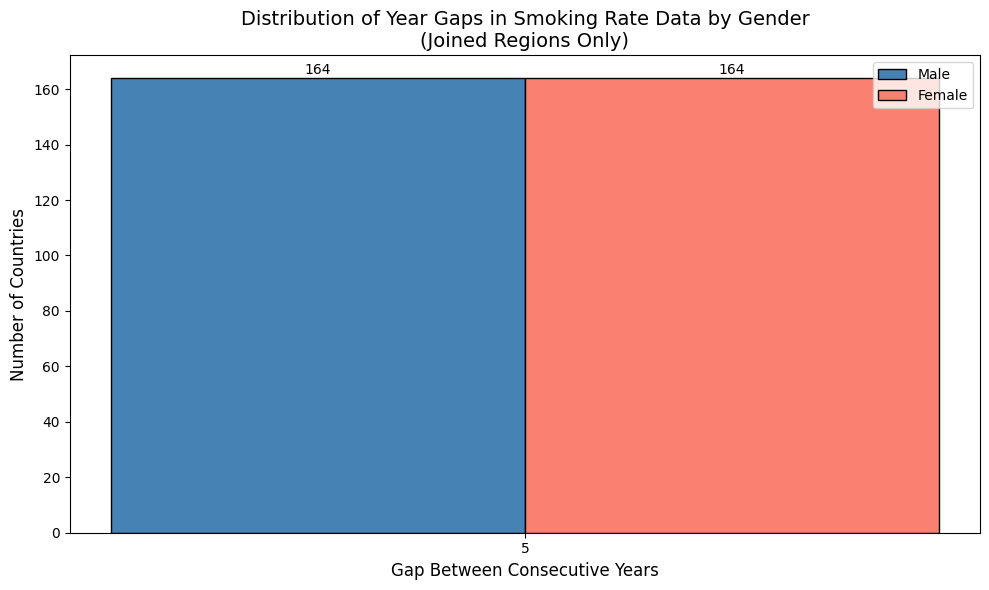

In [101]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

def analyze_smoking_year_gaps_mongo(database):
  joined_iso_codes = get_shared_countries(database)

  # Get smoking data for joined regions, sorted
  results = database["smoking_rates"].aggregate([
      {'$match': {'isoCode': {'$in': joined_iso_codes}}},
      {'$project': {'isoCode': 1, 'gender': 1, 'year': 1, '_id': 0}},
      {'$sort': {'isoCode': 1, 'gender': 1, 'year': 1}}
  ])

  # Group years by region and gender
  region_gender_years = {}
  for doc in results:
      key = (doc['isoCode'], doc['gender'])
      if key not in region_gender_years:
          region_gender_years[key] = []
      region_gender_years[key].append(doc['year'])

  # Calculate the most common gap for each region-gender combination
  gap_counts = {'male': Counter(), 'female': Counter()}

  for (iso_code, gender), years in region_gender_years.items():
      if len(years) < 2:
          continue

      gaps = [years[i+1] - years[i] for i in range(len(years) - 1)]
      most_common_gap = Counter(gaps).most_common(1)[0][0]
      gap_counts[gender][most_common_gap] += 1

  # Prepare data for plotting
  all_gaps = sorted(set(gap_counts['male'].keys()) | set(gap_counts['female'].keys()))
  male_counts = [gap_counts['male'].get(g, 0) for g in all_gaps]
  female_counts = [gap_counts['female'].get(g, 0) for g in all_gaps]

  # Create grouped bar chart
  fig, ax = plt.subplots(figsize=(10, 6))

  x = range(len(all_gaps))
  width = 0.35

  bars_male = ax.bar([i - width/2 for i in x], male_counts, width, label='Male', color='steelblue', edgecolor='black')
  bars_female = ax.bar([i + width/2 for i in x], female_counts, width, label='Female', color='salmon', edgecolor='black')

  for bar in bars_male + bars_female:
      height = bar.get_height()
      if height > 0:
          ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=10)

  ax.set_xlabel('Gap Between Consecutive Years', fontsize=12)
  ax.set_ylabel('Number of Countries', fontsize=12)
  ax.set_title('Distribution of Year Gaps in Smoking Rate Data by Gender\n(Joined Regions Only)', fontsize=14)
  ax.set_xticks(x)
  ax.set_xticklabels(all_gaps)
  ax.legend()
  plt.tight_layout()
  plt.show()

  return gap_counts

gap_counts_smoking = analyze_smoking_year_gaps_mongo(database)


=== 164 shared regions from both collections ===


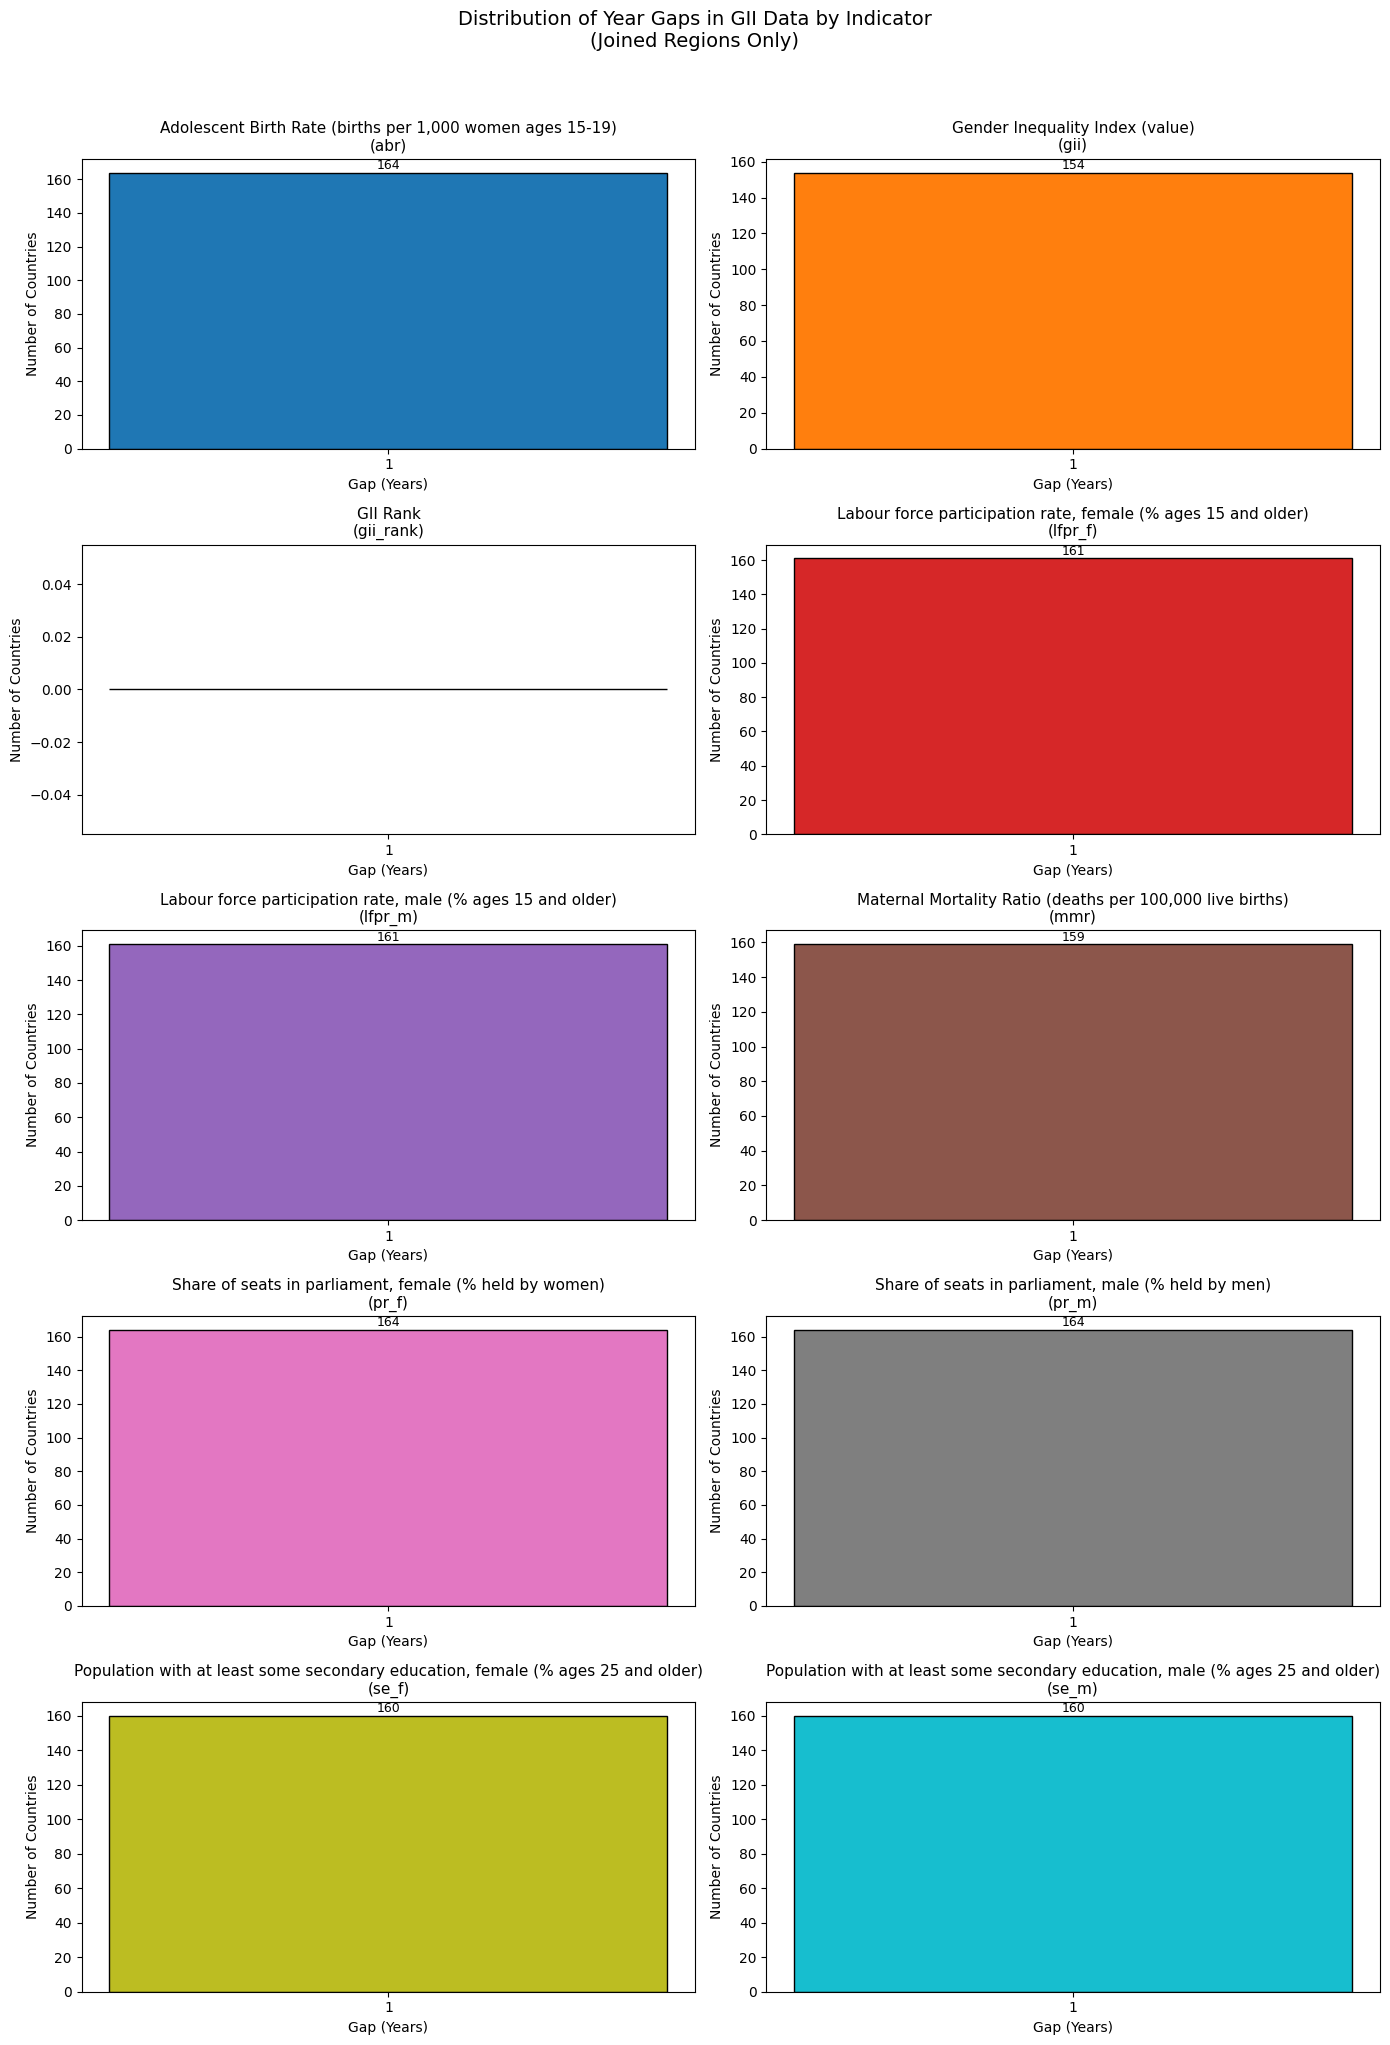

In [102]:
def analyze_gii_year_gaps_mongo(database):
  joined_iso_codes = get_shared_countries(database)

  # Get GII data for joined regions, sorted
  results = database["GII_data"].aggregate([
      {'$match': {'isoCode': {'$in': joined_iso_codes}}},
      {'$project': {'isoCode': 1, 'indicatorCode': 1, 'indicator': 1, 'year': 1, '_id': 0}},
      {'$sort': {'isoCode': 1, 'indicatorCode': 1, 'year': 1}}
  ])

  # Group years by region and indicator, also collect indicator names
  region_indicator_years = {}
  indicator_names = {}

  for doc in results:
      key = (doc['isoCode'], doc['indicatorCode'])
      if key not in region_indicator_years:
          region_indicator_years[key] = []
      region_indicator_years[key].append(doc['year'])
      indicator_names[doc['indicatorCode']] = doc['indicator']

  # Calculate the most common gap for each region-indicator combination
  gap_counts_by_indicator = {code: Counter() for code in indicator_names.keys()}

  for (iso_code, indicator_code), years in region_indicator_years.items():
      if len(years) < 2:
          continue

      gaps = [int(years[i+1]) - int(years[i]) for i in range(len(years) - 1)]
      most_common_gap = Counter(gaps).most_common(1)[0][0]
      gap_counts_by_indicator[indicator_code][most_common_gap] += 1

  # Get all unique gaps across all indicators
  all_gaps = sorted(set(
      gap for counts in gap_counts_by_indicator.values() for gap in counts.keys()
  ))

  # Create subplots - one for each indicator
  indicators = list(indicator_names.items())
  n_indicators = len(indicators)
  n_cols = 2
  n_rows = (n_indicators + 1) // 2

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
  axes = axes.flatten() if n_indicators > 1 else [axes]

  colors = plt.cm.tab10.colors

  for idx, (indicator_code, indicator_name) in enumerate(indicators):
      ax = axes[idx]
      gap_counts = gap_counts_by_indicator[indicator_code]

      counts = [gap_counts.get(g, 0) for g in all_gaps]

      bars = ax.bar(all_gaps, counts, color=colors[idx % len(colors)], edgecolor='black')

      for bar in bars:
          height = bar.get_height()
          if height > 0:
              ax.text(bar.get_x() + bar.get_width()/2, height + 0.3,
                      str(int(height)), ha='center', va='bottom', fontsize=9)

      ax.set_xlabel('Gap (Years)', fontsize=10)
      ax.set_ylabel('Number of Countries', fontsize=10)
      ax.set_title(f'{indicator_name}\n({indicator_code})', fontsize=11)
      ax.set_xticks(all_gaps)

  # Hide any unused subplots
  for idx in range(len(indicators), len(axes)):
      axes[idx].set_visible(False)

  fig.suptitle('Distribution of Year Gaps in GII Data by Indicator\n(Joined Regions Only)', fontsize=14, y=1.02)
  plt.tight_layout()
  plt.show()

  return gap_counts_by_indicator

gap_counts_gii = analyze_gii_year_gaps_mongo(database)

## Graphs
Note: the graphs drew in both SQL and Mondodb sections are exactly the same, so we will attach the same analyses under each graph in both sections for easier review.

###Graph 1-4
Before examining how GII relates to smoking behavior, we first use smoking data alone to understand the basic structure of global gender differences in smoking. These four graphs establish the essential patterns as the baseline for later linking smoking datasets to GII dataset—how male and female smoking rates differ across countries, regions, and over time.

###Graph 1: Male vs Female smoking prevalence

This graph looks at how male and female smoking prevalence compare in two years—2000 and 2022—so we can see how the gender gap in smoking has shifted over the past two decades. Each blue point represents a country,we also have markers for continent-level groups, income-level groups, and the global average (“World”). The diagonal line shows where the two rates would be equal, so if a point sits above the line, it means male smoking rate is higher than female smoking rate in that country or group.

1. Selecting Male–Female Smoking Data for the Target Years (2000 & 2022)

In [103]:
import matplotlib.pyplot as plt

def get_prevalence_and_gap_for_year_mongo(database, year):
    """
    Retrieve female_smoking, male_smoking, and smoking_gap for all countries/regions
    in a given year.

    Our dataset guarantees that each (isoCode, year, gender) combination corresponds
    to exactly ONE document. MongoDB requires every computed field inside a $group stage
    to be produced by an accumulator operator (e.g., $max, $first, $sum, ...).

    Here we use $max, but not to compute a mathematical maximum. Instead, we rely on
    $max to select the only non-null value produced by the $cond expression for the
    matching gender. In each group (one female doc + one male doc), $cond returns:
        - rate for the matching gender
        - null for the non-matching gender
    Thus $max simply picks the single valid rate value.
    """
    pipeline = [
        # 1. match year
        {"$match": {"year": year}},

        # 2. group by isoCode and region
        {
            "$group": {
                "_id": {
                    "isoCode": "$isoCode",
                    "region": "$region"
                },

                # female_smoking = rate (for female doc), null otherwise
                # $max returns the only non-null value in the group.
                "female_smoking": {
                    "$max": {
                        "$cond": [
                            {"$eq": ["$gender", "female"]},
                            "$rate",
                            None
                        ]
                    }
                },

                # male_smoking = rate (for male doc), null otherwise
                "male_smoking": {
                    "$max": {
                        "$cond": [
                            {"$eq": ["$gender", "male"]},
                            "$rate",
                            None
                        ]
                    }
                }
            }
        },

        # 3. select needed fields and compute smoking gap
        {
            "$project": {
                "_id": 0,
                "isoCode": "$_id.isoCode",
                "region": "$_id.region",
                "female_smoking": 1,
                "male_smoking": 1,
                "smoking_gap": {
                    "$subtract": ["$male_smoking", "$female_smoking"]
                }
            }
        }
    ]

    return list(database["smoking_rates"].aggregate(pipeline))


# Example: load data for 2000 and 2022
docs_2000_mongo = get_prevalence_and_gap_for_year_mongo(database, 2000)
docs_2022_mongo = get_prevalence_and_gap_for_year_mongo(database, 2022)
print(len(docs_2000_mongo), len(docs_2022_mongo))
print(docs_2022_mongo[0])

176 176
{'female_smoking': 6.0, 'male_smoking': 22.5, 'isoCode': 'BFA', 'region': 'Burkina Faso', 'smoking_gap': 16.5}


2. Classifying Regions into Types (Country / Continent / World / Income Group)

In [104]:
def is_country_iso(iso):
    """
    Return True if isoCode has exactly 3 uppercase alphabetic characters, e.g. 'AUS'.
    """
    return len(iso) == 3 and iso.isalpha() and iso.isupper()


def classify_region(doc):
    """
    Classify each document into one of four categories:
    - 'country'
    - 'continent'
    - 'world'
    - 'income'
    """
    iso = doc["isoCode"]
    name = doc["region"]

    # World
    if name == "World":
        return "world"

    # continent names
    continents = {
        "Africa", "Asia", "Europe", "Oceania",
        "North America", "South America"
    }
    if name in continents:
        return "continent"

    # income group names
    income_groups = {
        "Low-income countries",
        "Lower-middle-income countries",
        "Upper-middle-income countries",
        "High-income countries"
    }
    if name in income_groups:
        return "income"

    # country
    if is_country_iso(iso):
        return "country"

    # Fallback: treat as 'other' non-country region
    return "other"

def get_color_for_category(cat):
    """
    Map each category to a specific color for plotting.
    """
    if cat == "country":
        return "tab:blue"
    if cat == "continent":
        return "tab:orange"
    if cat == "world":
        return "black"
    if cat == "income":
        return "tab:green"
    return "tab:gray"

def short_income_label(name):
    """
    Make income-group labels shorter for plotting.
    We make the labels shorter so that there will be no overlaps between labels and the graph won't be a mess.
    """
    mapping = {
        "High-income countries":           "High income",
        "Low-income countries":            "Low income",
        "Upper-middle-income countries":   "Upper-middle",
        "Lower-middle-income countries":   "Lower-middle",
    }
    return mapping.get(name, name)


def group_docs_by_category(docs, value_keys):
    """
    Group documents by their region category (country / continent / world / income / other)
    so that we can plot them with different colors, markers, and labels.

    Parameters
    ----------
    docs : list of dict
        Each dict represents a row from the smoking dataset (one region in one year).
        Every document contains fields like:
            - region
            - isoCode
            - female_smoking
            - male_smoking
            ... (more indicators depending on the query)

    value_keys : list of str
        The numeric fields we want to extract for plotting.
        For example: ["female_smoking", "male_smoking"].
        These values will be grouped by category.

    Returns
    -------
    dict
        A nested dictionary with this structure:

        {
            'country': {
                'female_smoking': [...],
                'male_smoking': [...],
                'labels': [...]
            },
            'continent': { ... },
            'world': { ... },
            'income': { ... },
            'other': { ... }
        }

        - Each top-level key is a category determined by classify_region()
        - For each category, value_keys are stored as lists of numeric values
        - "labels" stores region names so we can annotate points later if needed

    Notes
    -----
    - This function lets us easily plot different region types using different colors.
    - We skip any document that has missing values for the selected value_keys.
      (Our cleaned dataset shouldn't normally contain None, but the check is kept just in case.)
    """
    result = {}
    for d in docs:
        cat = classify_region(d)
        if cat not in result:
            # Initialize containers for all requested value keys + labels
            result[cat] = {k: [] for k in value_keys}
            result[cat]["labels"] = []

        for k in value_keys:
            result[cat][k].append(d[k])
        result[cat]["labels"].append(d["region"])

    return result

cats_2000_mongo = group_docs_by_category(
    docs_2000_mongo,
    value_keys=["female_smoking", "male_smoking"]
)

cats_2022_mongo = group_docs_by_category(
    docs_2022_mongo,
    value_keys=["female_smoking", "male_smoking"]
)

 3. Selecting Male–Female Smoking Data for the Target Years (2000 & 2022)

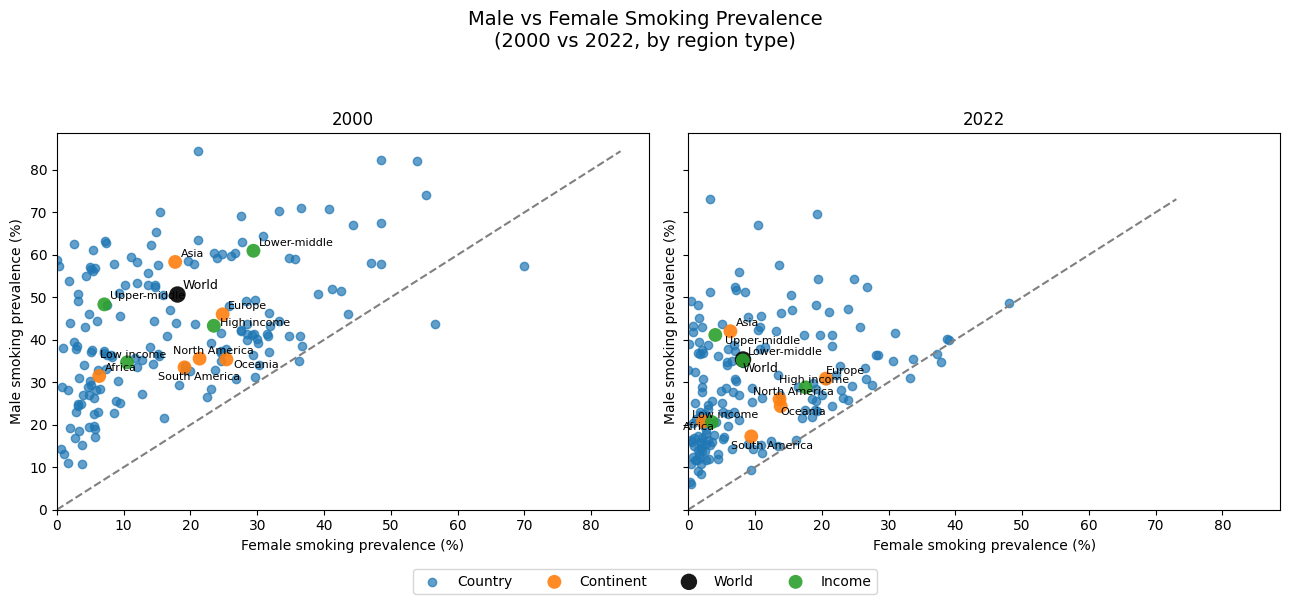

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True)

category_order = ["country", "continent", "world", "income"]


def plot_one_year(ax, cats, year_label, add_legend_labels, panel_side):
    """
    Plot one scatter panel for a given year.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to draw on.

    cats : dict
        Output of group_docs_by_category(). Contains grouped values
        for country / continent / world / income.

    year_label : str
        Title text for this panel ("2000" or "2022").

    add_legend_labels : bool
        If True, this panel will contribute labels to the global legend.

    panel_side : {"left", "right"}
        Which panel this is, used for fine-tuning text offsets so labels
        don't overlap too much in crowded areas.
    """

    max_val = 0.0

    # 1. Plot all country-level points first (background layer)
    if "country" in cats:
        data = cats["country"]
        x = data["female_smoking"]
        y = data["male_smoking"]

        color = get_color_for_category("country")
        label = "Country" if add_legend_labels else None

        ax.scatter(x, y, alpha=0.7, color=color, label=label)

        if x and y:
            max_val = max(max_val, max(max(x), max(y)))

    # 2. Plot continent / world / income groups as big points
    #    and add text labels next to them.
    # ---------------------------------------------------------
    # We don't want the labels in the graph to be overlapping each other,
    # so I manually adjusted the positions of those labels.
    # key = (panel_side, category, short_text)

    offset_overrides = {
        ("left",  "continent", "North America"): (-4, 1),
        ("left",  "continent", "South America"): (-4, -3),
        ("left",  "income",    "Low income"):   (-4, 1),
        ("left",  "income",    "High income"):   (1, 0),
         ("left", "continent", "Oceania"):       (1, -2),
        ("right", "continent", "North America"): (-4, 1),
        ("right", "continent", "Oceania"):       (0, -2),
        ("right", "world",     "World"):         (0, -3),
        ("right", "income",    "Upper-middle"):  (1.5, -2),
        ("right", "continent",  "Africa"):  (-3, -2),
        ("right", "income",  "Low income"):  (-3, 1),
        ("right", "continent",  "South America"):  (-3, -3),
	      ("right",  "income",    "High income"):   (-4, 1),
        ("right",  "continent",   "Europe"):   (0, 1)
    }

    for cat in ["continent", "world", "income"]:
        if cat not in cats:
            continue

        data = cats[cat]
        xs = data["female_smoking"]
        ys = data["male_smoking"]
        labels = data["labels"]

        color = get_color_for_category(cat)
        marker_size = 140 if cat == "world" else 100  # make World largest

        for i, (x, y, name) in enumerate(zip(xs, ys, labels)):
            # Legend label only on the first point of each category

            # There are many continents like Asia, Europe, etc that are classified by us into the category of Continent.
            # we don't want there to be one legend label for each, we only want one legend label Continent for all those continents.
            # Also we have left panel and right panel in the same graph. So we set the value of add_legend_labels to true for left panel, but false for right panel.
            leg_label = cat.capitalize() if (add_legend_labels and i == 0) else None

            # Big solid marker, no white halo
            ax.scatter(
                x, y,
                s=marker_size,
                color=color,
                edgecolors="none",
                alpha=0.9,
                label=leg_label,
            )

            # Short label text
            if cat == "income":
                text = short_income_label(name)
            elif cat == "world":
                text = "World"
            else:
                text = name

            # Default offset (slightly up and right)
            dx, dy = 0.8, 1.2

            # Apply manual offset override if we have one
            key = (panel_side, cat, text)
            if key in offset_overrides:
                dx, dy = offset_overrides[key]


            if cat == "world":
                ax.text(
                    x + dx,
                    y + dy,
                    text,
                    fontsize=9,
                )
            else:
                ax.text(
                    x + dx,
                    y + dy,
                    text,
                    fontsize=8,
                )

        # we need a global max_val(max of individual countries, continents, world, income, all 4 categories) to draw the entire graph.
        if xs and ys:
            max_val = max(max_val, max(max(xs), max(ys)))

    # 3. Reference line y = x
    ax.plot([0, max_val], [0, max_val], "--", color="gray")

    # 4. Titles and axis labels
    ax.set_title(year_label)
    ax.set_xlabel("Female smoking prevalence (%)")
    ax.set_ylabel("Male smoking prevalence (%)")

    return max_val


# ------------------ LEFT PANEL (2000) ------------------
max_val_2000 = plot_one_year(
    axes[0],
    cats_2000_mongo,
    "2000",
    add_legend_labels=True,
    panel_side="left"
)

# ------------------ RIGHT PANEL (2022) ------------------
max_val_2022 = plot_one_year(
    axes[1],
    cats_2022_mongo,
    "2022",
    add_legend_labels=False,
    panel_side="right"
)

# ------------------ Sync axes across panels ------------------
global_max = max(max_val_2000, max_val_2022)
for ax in axes:
    ax.set_xlim(0, global_max * 1.05)
    ax.set_ylim(0, global_max * 1.05)

# Build a single legend from the left subplot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4)

fig.suptitle(
    "Male vs Female Smoking Prevalence\n(2000 vs 2022, by region type)",
    fontsize=14
)

plt.tight_layout(rect=[0, 0.05, 1, 0.93])
plt.show()

####Analysis:
In both years, male smoking prevalence is consistently higher than female prevalence for almost all region categories. In 2000, the gender gap is generally wide, especially among low-income, upper-income, Africa and Asian regions. This shows both development level and cultural norms can discourage female smoking.

By 2022, both male and female rates decline, but the drop is much larger for men, leading to a visible shrinking of the smoking gap in most regions. We can clearly see most of the points are shifting towards both left and the diagonal line, which indicates the overall decline in smoking rates of both genders and a gradual decreasing difference in smoking rates between genders.


### Graph 2: Country-level distribution of smoking gap
Smoking gap is defined as the difference between male and female smoking prevalence (male − female).
This histogram compares the distribution of the gender smoking gap (male − female) across countries in 2000 and 2022.
It helps us see how the gap shifts over time, whether countries are converging toward smaller or larger gender differences or remains the same.
By overlaying the two distributions, we can visually assess how the global smoking patterns have evolved over the past two decades.

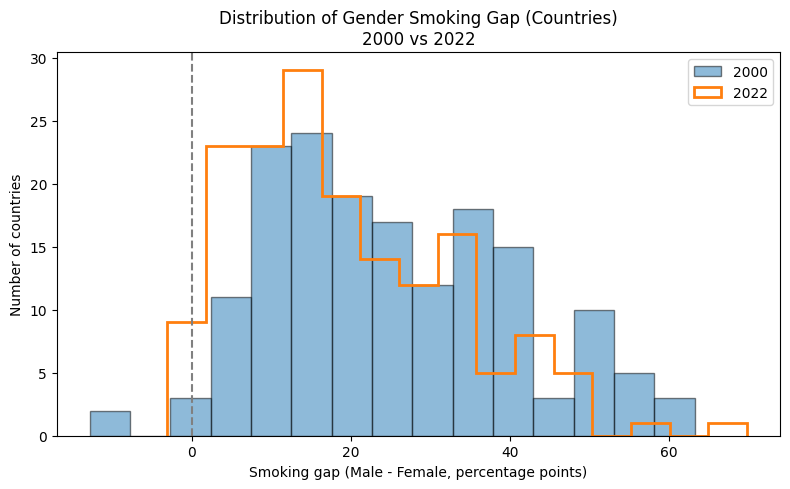

In [106]:
# 1. Group documents by category, but this time only keep "smoking_gap"
gaps_2000_mongo = group_docs_by_category(
    docs_2000_mongo,
    value_keys=["smoking_gap"]
)

gaps_2022_mongo = group_docs_by_category(
    docs_2022_mongo,
    value_keys=["smoking_gap"]
)

# 2. Extract country-level gaps (only the smoking_gap values)
country_gaps_2000_mongo = gaps_2000_mongo.get("country", {}).get("smoking_gap", [])
country_gaps_2022_mongo = gaps_2022_mongo.get("country", {}).get("smoking_gap", [])

# 3. Plot the overlaid histograms for 2000 vs 2022
plt.figure(figsize=(8, 5))

# We use the same bin settings for both years for a fair comparison
all_country_gaps_mongo = country_gaps_2000_mongo + country_gaps_2022_mongo
if all_country_gaps_mongo:
    bins = 15

    # Histogram for 2000 (filled)
    plt.hist(
        country_gaps_2000_mongo,
        bins=bins,
        alpha=0.5,
        edgecolor="black",
        label="2000"
    )

    # Histogram outline for 2022 (step only, so they do not completely overlap)
    plt.hist(
        country_gaps_2022_mongo,
        bins=bins,
        histtype="step",
        linewidth=2,
        label="2022"
    )

    plt.axvline(0, linestyle="--", color="gray")

    plt.xlabel("Smoking gap (Male - Female, percentage points)")
    plt.ylabel("Number of countries")
    plt.title("Distribution of Gender Smoking Gap (Countries)\n2000 vs 2022")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No country-level gaps available.")

####Analysis:
The distribution shows clear improvement over time. In 2000, the smoking gap is heavily right-skewed: many countries have large gender differences in smoking rate, with gaps exceeding 20–30 percentage points. By 2022, the distribution tightens and shifts toward zero, with fewer outliers. Many countries fall within the 0–10 range, and several have reached 0. The fast shrinking may be a outcome of global health policies, cultural changes, and reduced male smoking rates.


###Graph 3: Income-level and continent-level distribution of smoking gap

The smoking datasets themselves already include continent and income-group classifications. Since these categories are available, it is natural to explore how the gender smoking gap is distributed across different parts of the world. This helps us understand the global structure of the gap.

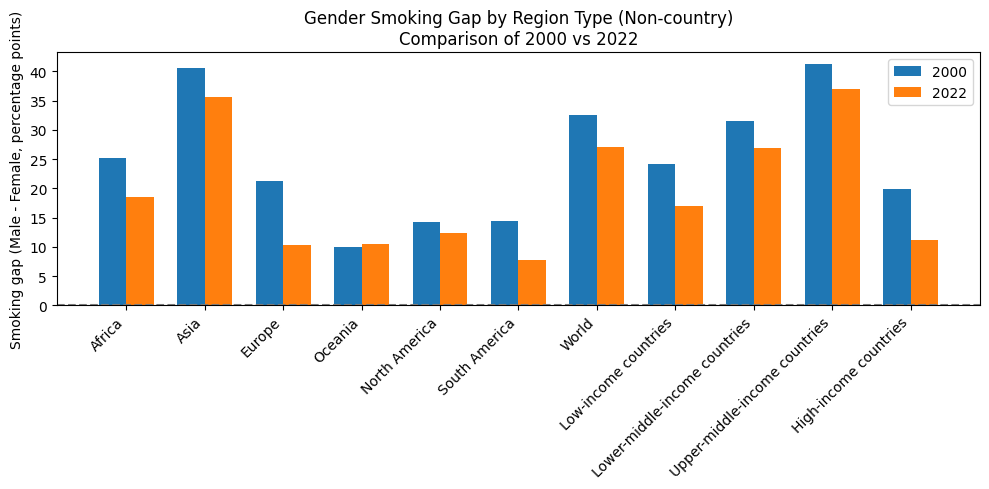

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define desired plotting order for non-country regions
continent_order = [
    "Africa", "Asia", "Europe", "Oceania",
    "North America", "South America"
]

income_order = [
    "Low-income countries",
    "Lower-middle-income countries",
    "Upper-middle-income countries",
    "High-income countries"
]

world_name = "World"

x_region_order = continent_order + [world_name] + income_order

# 2. Build mappings: region_name → smoking_gap
# excludes the "country" category
non_country_map_2000 = {}
non_country_map_2022 = {}

# 2000
for cat, data in gaps_2000_mongo.items():
    if cat == "country":
        continue  # skip country-level values
    gaps_list   = data.get("smoking_gap", [])
    labels_list = data.get("labels", [])
    for name, gap in zip(labels_list, gaps_list):
        non_country_map_2000[name] = gap

# 2022
for cat, data in gaps_2022_mongo.items():
    if cat == "country":
        continue
    gaps_list   = data.get("smoking_gap", [])
    labels_list = data.get("labels", [])
    for name, gap in zip(labels_list, gaps_list):
        non_country_map_2022[name] = gap


# 3. Build aligned lists
regions_for_plot = []
gaps2000_for_plot = []
gaps2022_for_plot = []

for region_name in x_region_order:
    # Only include regions present in at least one year
    if (region_name in non_country_map_2000) or (region_name in non_country_map_2022):
        regions_for_plot.append(region_name)
        gaps2000_for_plot.append(non_country_map_2000.get(region_name, 0.0))
        gaps2022_for_plot.append(non_country_map_2022.get(region_name, 0.0))


# 4. Draw the bar chart
if regions_for_plot:
    x = np.arange(len(regions_for_plot))
    bar_width = 0.35

    plt.figure(figsize=(10, 5))

    # Bars for year 2000 (shifted slightly left)
    plt.bar(
        x - bar_width/2,
        gaps2000_for_plot,
        width=bar_width,
        label="2000"
    )

    # Bars for year 2022 (shifted slightly right)
    plt.bar(
        x + bar_width/2,
        gaps2022_for_plot,
        width=bar_width,
        label="2022"
    )

    plt.axhline(0, linestyle="--", color="gray")

    plt.xticks(x, regions_for_plot, rotation=45, ha="right")
    plt.ylabel("Smoking gap (Male - Female, percentage points)")
    plt.title("Gender Smoking Gap by Region Type (Non-country)\nComparison of 2000 vs 2022")
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("No non-country gaps available for plotting.")

####Analysis:
In this graph, we present the distribution of smoking gap among different region categories: Continents, world, regions grouped by income level, in both 2000 and 2022.

The gender smoking gap remains substantial across all regions, but most regions show a noticeable decline from 2000 to 2022. Asia and upper-middle-income countries continue to show the largest gaps, indicating strong gendered patterns in smoking behavior. Asia countries and upper-middle-income countries have a large degree of overlap, which helps explain the result. High-income countries and Europe show the sharpest reductions, the reason might be the more effective tobacco control policies and shifts in social norms. Overall, the global pattern suggests gradual convergence.


### Graph 4: World smoking prevalence over time
This graph shows how male and female smoking prevalence has changed globally from 2000 to 2022.
Using the “World” aggregate, we extract the values for both genders over the 10-year period and plot their trends on the same chart.

The goal is to observe whether global smoking rates are decreasing over time, and whether the gender gap is narrowing.

In [108]:
# Helper function for Graph 4
def get_world_trend_mongo(database):
    """
    Query MongoDB to get the time series of male and female smoking prevalence
    for the 'World' aggregate, across all available years.
    """
    pipeline = [
        # 1) Keep only the 'World' aggregate
        {
            "$match": {
                "region": "World"
            }
        },

        # 2) Keep only the fields needed for plotting
        {
            "$project": {
                "_id": 0,
                "year": 1,
                "gender": 1,
                "rate": 1
            }
        }
    ]

    return list(database["smoking_rates"].aggregate(pipeline))


world_trend_docs = get_world_trend_mongo(database)
print("Number of records:", len(world_trend_docs))
print("Example record:", world_trend_docs[0])

Number of records: 16
Example record: {'year': 2000, 'gender': 'female', 'rate': 18.053535}


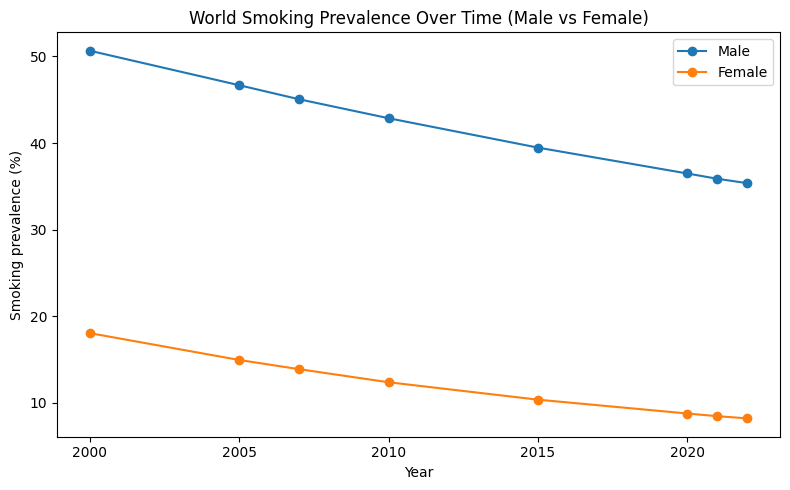

In [109]:
# Plot Graph 4

# Split the world trend into male and female series
years_male = []
rates_male = []
years_female = []
rates_female = []

for d in world_trend_docs:
    y = d["year"]
    g = d["gender"]
    r = d["rate"]
    if g == "male":
        years_male.append(y)
        rates_male.append(r)
    elif g == "female":
        years_female.append(y)
        rates_female.append(r)

# Sort each series by year (MongoDB grouping does not guarantee ordering)
male_series = sorted(zip(years_male, rates_male), key=lambda x: x[0])
female_series = sorted(zip(years_female, rates_female), key=lambda x: x[0])

years_male = [y for y, r in male_series]
rates_male = [r for y, r in male_series]

years_female = [y for y, r in female_series]
rates_female = [r for y, r in female_series]

min_year, max_year = 2000, 2022
years_male_filtered = []
rates_male_filtered = []
years_female_filtered = []
rates_female_filtered = []

for y, r in zip(years_male, rates_male):
    if min_year <= y <= max_year:
        years_male_filtered.append(y)
        rates_male_filtered.append(r)

for y, r in zip(years_female, rates_female):
    if min_year <= y <= max_year:
        years_female_filtered.append(y)
        rates_female_filtered.append(r)

# Plot the time trend
plt.figure(figsize=(8, 5))

plt.plot(years_male_filtered, rates_male_filtered, marker="o", label="Male")
plt.plot(years_female_filtered, rates_female_filtered, marker="o", label="Female")

plt.xlabel("Year")
plt.ylabel("Smoking prevalence (%)")
plt.title("World Smoking Prevalence Over Time (Male vs Female)")
plt.legend()
plt.tight_layout()
plt.show()

####Analysis:
As mentioned above, the global smoking prevalence of both genders is decreasingly steadily. In this graph, we specifically focus on the world smoking prevalence over a period from 2000 to 2020. Now we can clearly see global smoking prevalence of both genders is decreasingly, and male smoking rate decreases slightly faster. And the smoking gap is also decreasing steadily.

### Graph 5-7
All of these graphs focus only on the GII table because here we want to understand the global patterns and long-term trends of gender inequality itself, before relating it to smoking behavior.
These visualizations give us the context needed to later connect GII with smoking gaps.

In [110]:
# Names for non-country aggregates in the GII dataset
DEV_LEVEL_NAMES = {
    "Very High Human Development",
    "High Human Development",
    "Medium Human Development",
    "Low Human Development"
}

REGION_NAMES = {
    "Arab States",
    "East Asia And The Pacific",
    "Europe And Central Asia",
    "Latin America And The Caribbean",
    "South Asia",
    "Sub-Saharan Africa"
}

WORLD_NAME = "World"

In [111]:
def get_gii_docs_for_year_mongo(database, year):
    """
    Obtain gii dataset for a single year.

    For the selected year and indicatorCode == 'gii':
      1. filters by year and indicatorCode,
      2. converts year to int and value to a numeric GII, and keep needed fields
    """
    pipeline = [
        # 1. Keep only records for the selected year and overall GII indicator
        {
            "$match": {
                "year": str(year),      # stored as string in MongoDB
                "indicatorCode": "gii"
            }
        },

        # 2. Convert types and keep only needed fields
        {
            "$project": {
                "_id": 0,
                "isoCode": 1,
                "region": 1,
                "year": {"$toInt": "$year"},
                "gii":  {"$toDouble": "$value"}
            }
        }
    ]

    return list(database["GII_data"].aggregate(pipeline))


# Example: load 2000 and 2022 data
docs_gii_2000 = get_gii_docs_for_year_mongo(database, 2000)
docs_gii_2022 = get_gii_docs_for_year_mongo(database, 2022)

print("Docs 2000:", len(docs_gii_2000))
print("Docs 2022:", len(docs_gii_2022))
print("Example doc:", docs_gii_2022[0])

Docs 2000: 135
Docs 2022: 183
Example doc: {'isoCode': 'AFG', 'region': 'Afghanistan', 'year': 2022, 'gii': 0.665}


In [112]:
def get_gii_trend_for_names_mongo(database, names):
    """
    Get GII time series for a list of names (regions or different development regions).

    1. Filter indicatorCode == 'gii' and region in given names.
    2. Convert 'year' (string) to integer, 'value' (string) to double and rename as 'gii'.
    """

    pipeline = [
        # 1. Filter by indicator and region names
        {
            "$match": {
                "indicatorCode": "gii",
                "region": {"$in": list(names)}
            }
        },

        # 2. Convert types and keep only fields we need
        {
            "$project": {
                "_id": 0,
                "name":  "$region",
                "year":  {"$toInt": "$year"},
                "gii":   {"$toDouble": "$value"}
            }
        }
    ]

    return list(database["GII_data"].aggregate(pipeline))


def build_series_by_name(docs):
    """
    Turn a list of docs {name, year, gii} into a dict:
        { name: {"years": [...], "gii": [...]} }
    with years sorted in ascending order.
    """
    by_name = {}
    for d in docs:
        nm = d["name"]
        yr = d["year"]
        val = d["gii"]
        if nm not in by_name:
            by_name[nm] = {"years": [], "gii": []}
        by_name[nm]["years"].append(yr)
        by_name[nm]["gii"].append(val)

    # sort each series by year
    for nm, series in by_name.items():
        pairs = sorted(zip(series["years"], series["gii"]), key=lambda x: x[0])
        series["years"] = [y for y, v in pairs]
        series["gii"] = [v for y, v in pairs]

    return by_name

### Graph 5: Country-level GII distribution (boxplot)
We draw this boxplot to see how the overall distribution of GII has shifted over time.
It helps us quickly check whether gender inequality has gone down and whether countries have become more similar or more spread out.

Countries 2000: 125
Countries 2022: 172


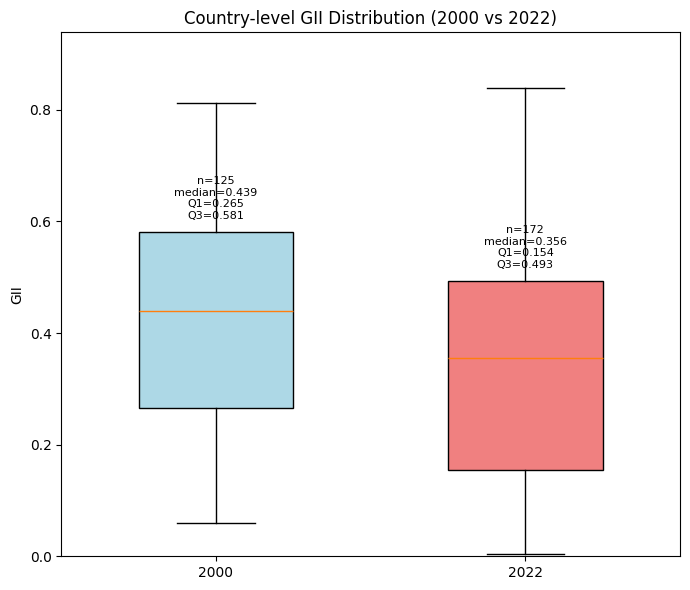

In [113]:
import matplotlib.pyplot as plt
import numpy as np

def collect_country_gii(docs):
    """
    Extract GII values for country-level units only.
    """
    return [d["gii"] for d in docs if is_country_iso(d["isoCode"])]

gii_country_2000 = collect_country_gii(docs_gii_2000)
gii_country_2022 = collect_country_gii(docs_gii_2022)

print("Countries 2000:", len(gii_country_2000))
print("Countries 2022:", len(gii_country_2022))

# ----- Draw boxplot -----
fig, ax = plt.subplots(figsize=(7, 6))

box_data = [gii_country_2000, gii_country_2022]
positions = [0, 1]
labels = ["2000", "2022"]

bp = ax.boxplot(
    box_data,
    positions=positions,
    widths=0.5,
    patch_artist=True,
    showfliers=False  # hide outliers for cleaner appearance
)

colors = ["lightblue", "lightcoral"]
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)

# ----- Annotate key statistics for each box -----
for pos, data in zip(positions, box_data):
    if not data:
        continue
    arr = np.array(data)
    n = len(arr)
    median = np.median(arr)
    q1 = np.percentile(arr, 25)
    q3 = np.percentile(arr, 75)

    # Text annotation slightly above the box
    text = f"n={n}\nmedian={median:.3f}\nQ1={q1:.3f}\nQ3={q3:.3f}"
    ax.text(
        pos,            # x
        q3 + 0.02,      # y (slightly above the upper quartile)
        text,
        ha="center",
        va="bottom",
        fontsize=8
    )

# General formatting
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_ylabel("GII")
ax.set_title("Country-level GII Distribution (2000 vs 2022)")

all_vals = gii_country_2000 + gii_country_2022
if all_vals:
    y_max = max(all_vals)
    ax.set_ylim(0, y_max + 0.1)

plt.tight_layout()
plt.show()

####Analysis:
This graph compares the distribution of the Gender Inequality Index (GII) across countries in 2000 and 2022 using boxplots.
The sample size (n) indicates how many countries had available GII data—125 in 2000 and 172 in 2022—reflecting expanded global coverage in recent years, which is a sign of more and more countries starting to take the gender equality more seriously.

The median represents shows the typical level of gender inequality. It declines from 0.439 in 2000 to 0.356 in 2022, signalling meaningful worldwide progress.

Q1 (the 25th percentile) and Q3 (the 75th percentile) help describe the spread of countries. Both Q1 and Q3 decreases, meaning both the most gender-equal countries and the more unequal countries have become more equal.
Overall, the downward shift of median, Q1, and Q3 shows global reductions in gender inequality over the two decades, though great differences remain among countries.

### Graph 6: Country-level GII distribution (histogram)
This histogram lets us compare how many countries fall into different GII ranges in both 2000 and 2022. And we can compare the GII distribution in two years in order to see the trend, whether the entire global distribution is moving toward lower inequality.


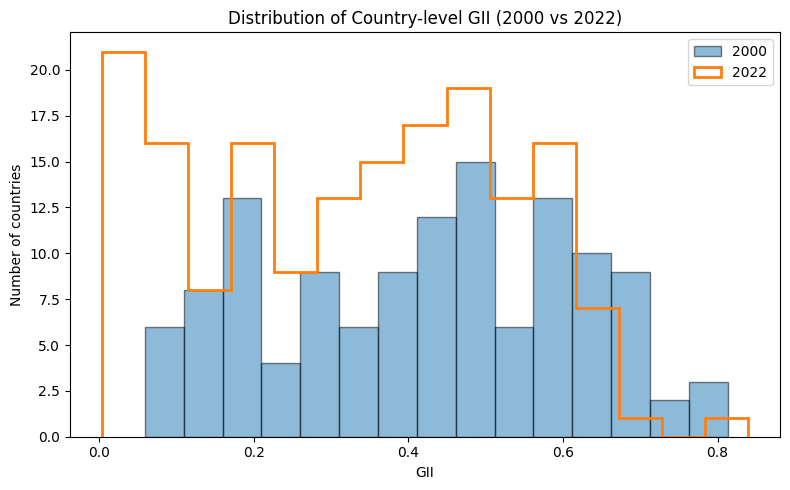

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

all_vals = gii_country_2000 + gii_country_2022
if all_vals:
    # Use the same bins for both years for a fair comparison
    bins = 15

    # Filled histogram for 2000
    plt.hist(
        gii_country_2000,
        bins=bins,
        alpha=0.5,
        edgecolor="black",
        label="2000"
    )

    # Outline histogram for 2022
    plt.hist(
        gii_country_2022,
        bins=bins,
        histtype="step",
        linewidth=2,
        label="2022"
    )

    plt.xlabel("GII")
    plt.ylabel("Number of countries")
    plt.title("Distribution of Country-level GII (2000 vs 2022)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No country-level GII data available.")

####Analysis:
The blue bars represent the distribution of GII in 2000, wihle the orange curve represents the distribution of GII in 2022.
We can clearly see a substantial leftward shift, which indicates the global movement towards lower gender inequality. Notably, in 2000, there were no countries has a GII lower than 0.05. But in 2022, there appear many countries whose GII fall in the range (0, 0.1). Also, in 2022, there were quite a few countries whose GII fall in the high end, but in 2000, there is a sharp decrease.
Overall, this graph shows broad improvement in gender equality across countries over the two decades.



###Graph 7: GII time trends by region
We plot GII trends for major world regions to see whether different parts of the world improve at similar or different speeds.
This shows long-term regional patterns that cannot be seen from single-year comparisons.

A small note: the “regions” in the GII dataset aren’t grouped exactly the same way as the continents in our smoking dataset. But they still represent meaningful large-scale areas, so the trends are still useful for comparing how gender inequality changes across different parts of the world.

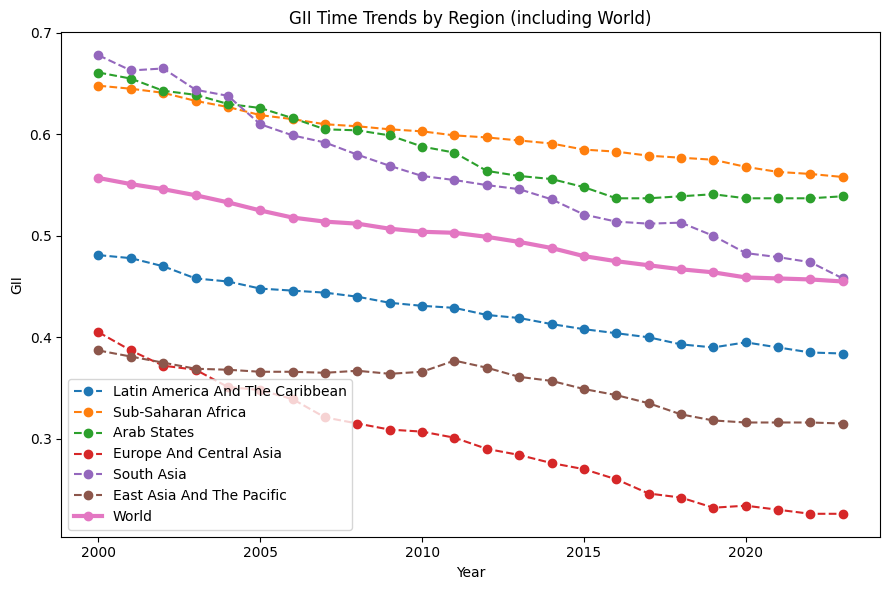

In [115]:
import matplotlib.pyplot as plt

# Build the list of names: regions + World
region_names_with_world = list(REGION_NAMES) + [WORLD_NAME]

# Query MongoDB for time series
docs_regions = get_gii_trend_for_names_mongo(database, region_names_with_world)
series_regions = build_series_by_name(docs_regions)

plt.figure(figsize=(9, 6))

for name in region_names_with_world:
    if name not in series_regions:
        continue
    s = series_regions[name]
    years = s["years"]
    values = s["gii"]

    # Use thicker solid line for World; dashed for regions
    if name == WORLD_NAME:
        plt.plot(
            years, values,
            marker="o",
            linewidth=3,
            label=name
        )
    else:
        plt.plot(
            years, values,
            marker="o",
            linestyle="--",
            label=name
        )

plt.xlabel("Year")
plt.ylabel("GII")
plt.title("GII Time Trends by Region (including World)")
plt.legend()
plt.tight_layout()
plt.show()

####Analysis:
All regions show a clear downward trend in GII over the past two decades, indicating global movement toward gender equality.
South Asia starts with the highest inequality levels, it is consistently improving, showing the fastest rate of decline.
Europe and Central Asia consistently maintain the lowest GII values and continue to improve at a very fast rate.
The rest regions decline at a similar rate.
The World aggregate line also moves downward, confirming that improvements are global.



### Graphs 8-12
This section constructs the core analysis to help us examine how gender inequality relates to smoking behaviors. We must join GII_data and smoking_rates datasets at the country-year
level, so we link documents by (isoCode, year) using an aggregation pipeline in MongoDB.

We retain the following variables in the joined dataset:

    Smoking-related variables:
        • female_smoking  - female smoking prevalence (%)
        • male_smoking    - male smoking prevalence (%)
        • smoking_gap     - male_smoking - female_smoking (our primary target)

    Gender inequality indicators:
        • gii      - Gender Inequality Index (0-1 scale)
        • abr      - adolescent birth rate (per 1,000 females aged 15-19)
        • se_f     - female secondary education attainment (% ages 25+)
        • lfpr_f   - female labor force participation (% ages 15+)
        • pr_f     - proportion of parliamentary seats held by women (%)
      We include female indicators because we assume female plays an key role in the smoking gap.


In [116]:
# Helper function to build joined dataset

def build_joined_docs_for_year_mongo(database, year):
    """
    Build a joined dataset of GII data and smoking data for a single year.

    The output merges:
        • smoking_rates: female_smoking, male_smoking, smoking_gap
        • GII_data: gii, abr, se_f, lfpr_f, pr_f
          - gii: Gender Inequality Index (value)
          - abr: Adolescent Birth Rate (births per 1,000 women ages 15-19)
          - se_f: Population with at least some secondary education, female (% ages 25 and older)
          - lfpr_f: Labour force participation rate, female (% ages 15 and older)
          - pr_f: Share of seats in parliament, female (% held by women)

    Design principles
    -----------------
    • The dataset ensures that each (isoCode, year, gender) and
      (isoCode, year, indicatorCode) is unique because the importer
      created composite _id fields.
      Therefore, the use of `$max + $cond` is NOT for error handling,
      but simply to SELECT the only valid value in each group.
    • smoking_rates.year is stored as an integer;
      GII_data.year is stored as a string → we convert only GII.year
      using `$toInt` to make them match.
    """

    year_int = int(year)

    pipeline = [

        # 1. Filter smoking data by year
        {"$match": {"year": year_int}},

        # 2. Pivot male/female smoking rates into one row per region.
        # In our dataset, each (isoCode, year, gender) is unique,
        # so `$max + $cond` selects the single non-null rate value.
        {
            "$group": {
                "_id": {
                    "isoCode": "$isoCode",
                    "region": "$region"
                },
                "female_smoking": {
                    "$max": {
                        "$cond": [
                            {"$eq": ["$gender", "female"]},
                            "$rate",
                            None
                        ]
                    }
                },
                "male_smoking": {
                    "$max": {
                        "$cond": [
                            {"$eq": ["$gender", "male"]},
                            "$rate",
                            None
                        ]
                    }
                }
            }
        },

        # 3. Build the smoking document with needed fields and compute smoking gap
        {
            "$project": {
                "_id": 0,
                "isoCode": "$_id.isoCode",
                "region": "$_id.region",
                "year": year_int,
                "female_smoking": 1,
                "male_smoking": 1,
                "smoking_gap": {
                    "$subtract": ["$male_smoking", "$female_smoking"]
                }
            }
        },

        # 4. Lookup GII indicators for the same isoCode and year.
        # GII_data.year is a STRING → must convert with $toInt.
        # We only keep 5 indicators: gii, abr, se_f, lfpr_f, pr_f.
        # The inner pipeline pivots multiple indicator rows into one
        # document using the same `$max + $cond` pattern.
        {
            "$lookup": {
                "from": "GII_data",
                "let": {"iso": "$isoCode"},
                "pipeline": [
                    # --- match same iso + year, restrict indicators ---
                    {
                        "$match": {
                            "$expr": {
                                "$and": [
                                    {"$eq": ["$isoCode", "$$iso"]},
                                    {"$eq": [{"$toInt": "$year"}, year_int]}
                                ]
                            },
                            "indicatorCode": {
                                "$in": ["gii", "abr", "se_f", "lfpr_f", "pr_f"]
                            }
                        }
                    },

                    # --- pivot indicator rows into wide format ---
                    {
                        "$group": {
                            "_id": None,
                            "gii": {
                                "$max": {
                                    "$cond": [
                                        {"$eq": ["$indicatorCode", "gii"]},
                                        {"$toDouble": "$value"},
                                        None
                                    ]
                                }
                            },
                            "abr": {
                                "$max": {
                                    "$cond": [
                                        {"$eq": ["$indicatorCode", "abr"]},
                                        {"$toDouble": "$value"},
                                        None
                                    ]
                                }
                            },
                            "se_f": {
                                "$max": {
                                    "$cond": [
                                        {"$eq": ["$indicatorCode", "se_f"]},
                                        {"$toDouble": "$value"},
                                        None
                                    ]
                                }
                            },
                            "lfpr_f": {
                                "$max": {
                                    "$cond": [
                                        {"$eq": ["$indicatorCode", "lfpr_f"]},
                                        {"$toDouble": "$value"},
                                        None
                                    ]
                                }
                            },
                            "pr_f": {
                                "$max": {
                                    "$cond": [
                                        {"$eq": ["$indicatorCode", "pr_f"]},
                                        {"$toDouble": "$value"},
                                        None
                                    ]
                                }
                            }
                        }
                    },

                    # --- return only indicator fields ---
                    {
                        "$project": {
                            "_id": 0,
                            "gii": 1,
                            "abr": 1,
                            "se_f": 1,
                            "lfpr_f": 1,
                            "pr_f": 1
                        }
                    }
                ],
                "as": "gii_info"
            }
        },

        # 5. Unwind to produce an inner-join effect.
        #    Countries without GII data are removed.
        {
            "$unwind": {
                "path": "$gii_info",
                "preserveNullAndEmptyArrays": False
            }
        },

        # 6. Final projection: fully joined dataset
        {
            "$project": {
                "_id": 0,
                "isoCode": 1,
                "region": 1,
                "year": 1,
                "female_smoking": 1,
                "male_smoking": 1,
                "smoking_gap": 1,

                # GII fields
                "gii": "$gii_info.gii",
                "abr": "$gii_info.abr",
                "se_f": "$gii_info.se_f",
                "lfpr_f": "$gii_info.lfpr_f",
                "pr_f": "$gii_info.pr_f",
            }
        }
    ]

    return list(database["smoking_rates"].aggregate(pipeline))


# Example for 2022:
docs_joined_2022 = build_joined_docs_for_year_mongo(database, 2022)
docs_joined_2000 = build_joined_docs_for_year_mongo(database, 2000)
print("Number of joined docs:", len(docs_joined_2022))
print("Number of joined docs:", len(docs_joined_2000))
print(docs_joined_2022[0])

Number of joined docs: 164
Number of joined docs: 164
{'female_smoking': 1.6, 'male_smoking': 45.1, 'isoCode': 'CHN', 'region': 'China', 'smoking_gap': 43.5, 'gii': 0.138, 'abr': 5.463, 'se_f': 68.27756009, 'lfpr_f': 54.6, 'pr_f': 24.94117647}


In [117]:
from scipy.stats import linregress

# Helper function to plot indicator and target
def plot_indicator_vs_target(docs, year, indicator_field, indicator_label,
                             target_field, target_label,
                             title_prefix):
    """
    General-purpose scatter + regression plot:
        x = indicator_field (e.g., gii, abr, se_f, lfpr_f, pr_f)
        y = target_field    (e.g., smoking_gap, female_smoking, male_smoking)
    Includes:
        slope, stderr (standard error)

    Parameters
    ----------
    docs : list of dict
        Output of build_joined_docs_for_year_mongo.
    year : int
        Year for the title.
    indicator_field : str
        Field name for x-axis.
    indicator_label : str
        label for x-axis.
    target_field : str
        Field name for y-axis.
    target_label : str
        label for y-axis.
    title_prefix : str
        Title prefix for the figure.
    """
    x_vals = []
    y_vals = []

    for d in docs:
        x = d.get(indicator_field)
        y = d.get(target_field)
        # gii indicator might not be complete for some countries
        if x is not None:
            x_vals.append(float(x))
            y_vals.append(float(y))

    x = np.array(x_vals)
    y = np.array(y_vals)

    print(f"Year: {year}")
    print(f"{indicator_field} count: {len(x)}")
    print(f"{target_field} count: {len(y)}")

    # ---------- Regression ----------
    res = linregress(x, y)
    slope = res.slope
    intercept = res.intercept
    stderr = res.stderr

    # ---------- Plot ----------
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.7, label="Countries")
    plt.axhline(0, linestyle="--", linewidth=1)

    # Regression line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept

    plt.plot(
        x_line, y_line,
        linewidth=2,
        label=f"slope={slope:.2f}, stderr={stderr:.2f}"
    )

    plt.xlabel(indicator_label)
    plt.ylabel(target_label)
    plt.title(f"{title_prefix} ({year})")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Graph 8: GII vs Smoking Gap (Scatter + Regression), 2000 and 2022

This graph addresses our central research question:

**Does gender inequality correlate with the gender smoking gap?**

Our hypothesis is that countries with higher gender inequality (higher GII values)
tend to exhibit a larger male–female smoking difference  
→ **expected regression slope > 0**.

To observe how this relationship has evolved, we compare two benchmark years:

**2000** (the earliest year with both GII and smoking data) and  
**2022** (the most recent year with both GII and smoking data).

Comparing the regression slopes for these two years allows us to assess whether the influence of gender inequality on smoking differences has strengthened, weakened, or remained stable over the past two decades.

Year: 2000
gii count: 116
smoking_gap count: 116


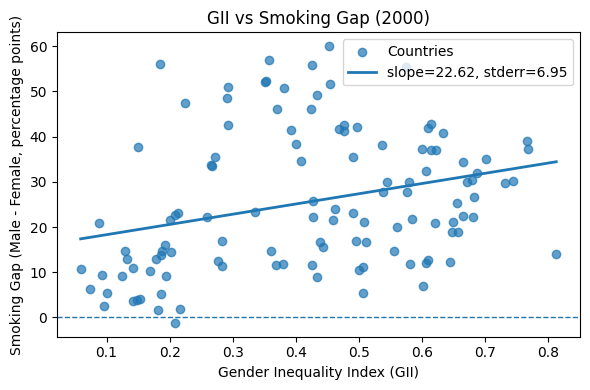

Year: 2022
gii count: 154
smoking_gap count: 154


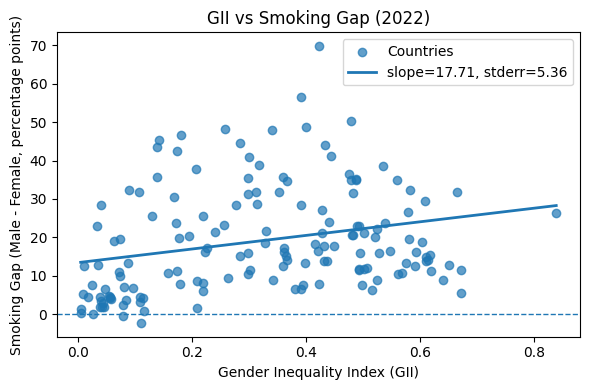

In [118]:
plot_indicator_vs_target(
        docs_joined_2000, 2000,
        indicator_field="gii",
        indicator_label="Gender Inequality Index (GII)",
        target_field="smoking_gap",
        target_label="Smoking Gap (Male - Female, percentage points)",
        title_prefix=f"GII vs Smoking Gap"
    )

plot_indicator_vs_target(
        docs_joined_2022, 2022,
        indicator_field="gii",
        indicator_label="Gender Inequality Index (GII)",
        target_field="smoking_gap",
        target_label="Smoking Gap (Male - Female, percentage points)",
        title_prefix=f"GII vs Smoking Gap"
    )

#### Analysis:
**1. GII has a positive relationship with smoking gap.**

This means that countries with higher gender inequality tend to have larger smoking gap where men smoke significantly more than women.

**2. From 2000 to 2022, the positive association weakened (from 22.6 to 17.7).**

This suggests that the smoking gap has become less sensitive to differences in GII.

**3. The points in 2022 is more concentrated at lower GII values, reflecting global improvements in gender equality.**

### Graph 9: GII vs female/male smoking rate 2000 and 2022
Having observed in Graph 8 that countries with higher gender inequality tend to exhibit larger smoking gaps—and that this association has weakened from 2000 to 2022.

So, we want to examine which side of the gap is contributing to this pattern.
Specifically, we ask:

**Does gender inequality correlate with female smoking and male smoking separately?**

Because the smoking gap is defined as (male – female), decomposing the gap into its two components allows us to identify whether the relationship with GII is primarily driven by higher male prevalence, lower female prevalence, or both.

By comparing the regression slopes for 2000 and 2022, we can assess whether the
influence of gender inequality on smoking behavior has changed differently for women and men over the past two decades.


Year: 2000
gii count: 116
female_smoking count: 116


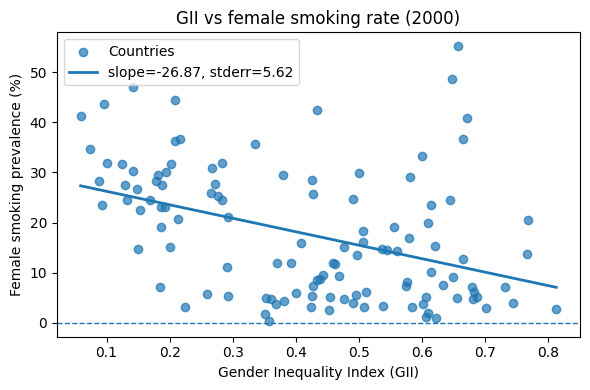

Year: 2000
gii count: 116
male_smoking count: 116


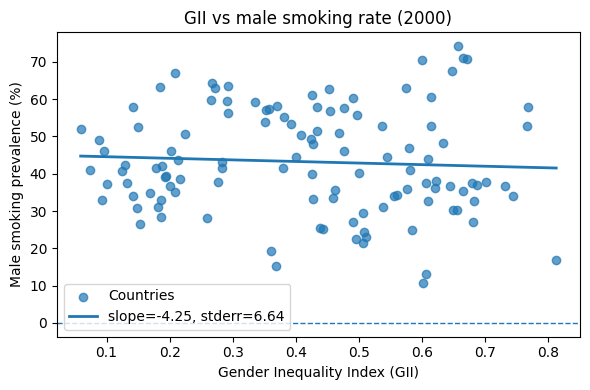

Year: 2022
gii count: 154
female_smoking count: 154


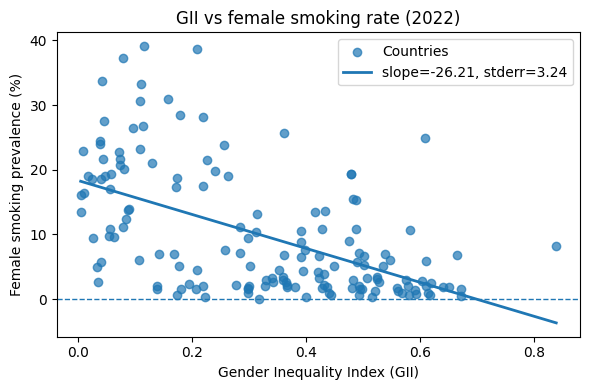

Year: 2022
gii count: 154
male_smoking count: 154


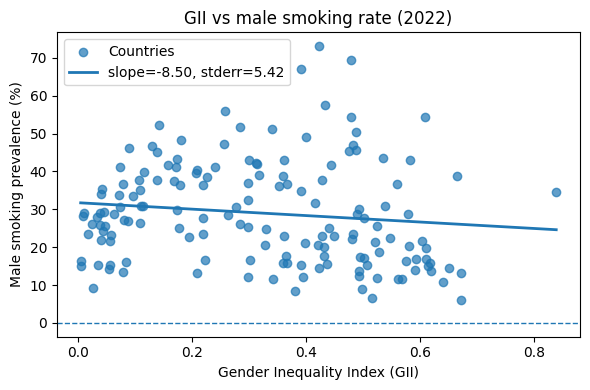

In [119]:
plot_indicator_vs_target(
        docs_joined_2000, 2000,
        indicator_field="gii",
        indicator_label="Gender Inequality Index (GII)",
        target_field="female_smoking",
        target_label="Female smoking prevalence (%)",
        title_prefix=f"GII vs female smoking rate"
    )
plot_indicator_vs_target(
        docs_joined_2000, 2000,
        indicator_field="gii",
        indicator_label="Gender Inequality Index (GII)",
        target_field="male_smoking",
        target_label="Male smoking prevalence (%)",
        title_prefix=f"GII vs male smoking rate"
    )
plot_indicator_vs_target(
        docs_joined_2022, 2022,
        indicator_field="gii",
        indicator_label="Gender Inequality Index (GII)",
        target_field="female_smoking",
        target_label="Female smoking prevalence (%)",
        title_prefix=f"GII vs female smoking rate"
    )
plot_indicator_vs_target(
        docs_joined_2022, 2022,
        indicator_field="gii",
        indicator_label="Gender Inequality Index (GII)",
        target_field="male_smoking",
        target_label="Male smoking prevalence (%)",
        title_prefix=f"GII vs male smoking rate"
    )

#### Analysis:

**1. Female smoking is strongly and consistently negatively associated with GII.**

In both 2000 and 2022, countries with higher gender inequality tend to have much lower female smoking rates, with slopes around -27 in both years.
This relationship is strong, stable, and statistically precise (smaller stderr in 2022).

**2. Male smoking shows only a weak negative association with GII.**

For men, slopes are close to zero (about -4.25 in 2000 and -8.50 in 2022), and the relationship is much noisier.
This suggests that gender inequality has much less influence on male smoking behavior than on female smoking.

**3. Comparing 2000 and 2022 reveals that the female-GII relationship remains strong, while the male-GII relationship stays weak.**

This asymmetry implies that the positive slope we observed earlier for the smoking gap (Graph 8) is driven almost entirely by women:
**as inequality rises, women smoke significantly less, while men smoke only slightly less.**

### Graph 10: Correlation over time (2000-2022)
While the slope analysis shows how strongly changes in GII translate into changes in smoking outcomes, correlation helps answer a related but distinct question:

**How stable is the linear association between gender inequality and smoking behavior over time?**

For each year from 2000 to 2022, we compute the Pearson correlation coefficient between GII and three outcomes—smoking gap, female smoking, and male smoking.
Plotting these correlations as time series allows us to observe whether the strength of the GII–smoking relationship has remained consistent, grown stronger, or weakened across the last two decades.


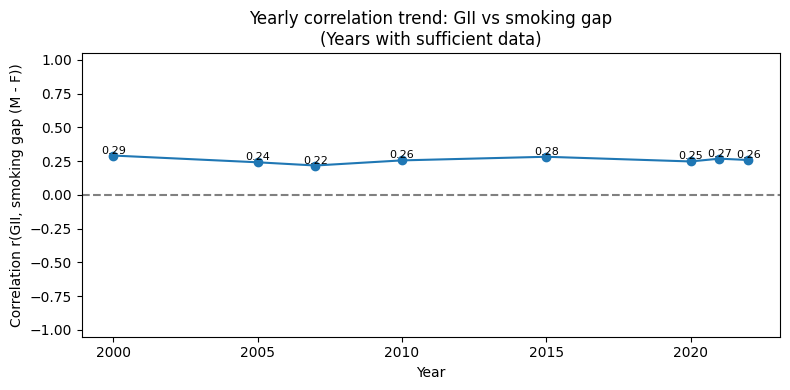

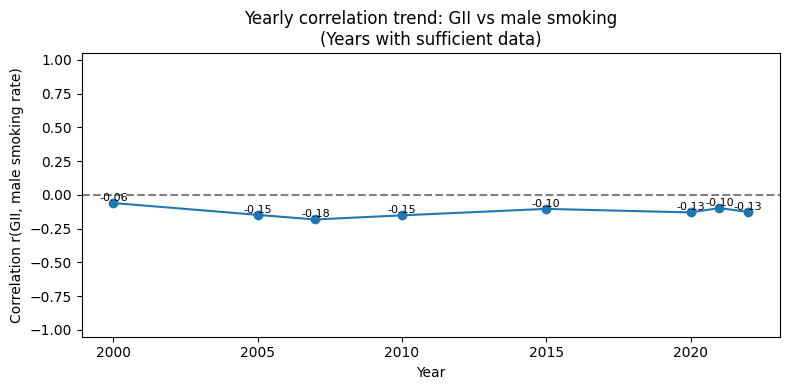

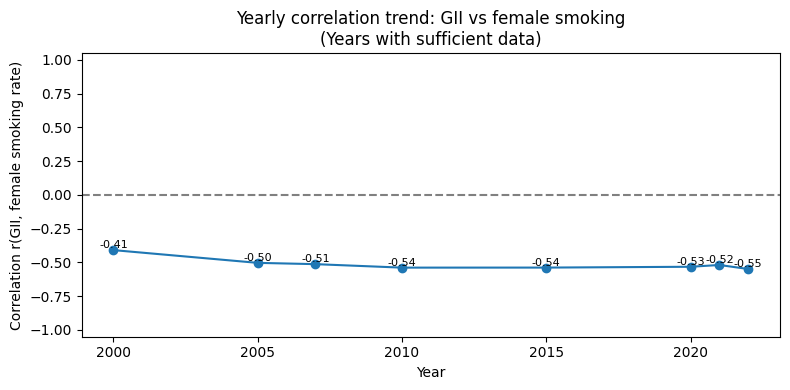

In [120]:
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

def plot_yearly_correlation_trend_mongo(database,
                                        start_year,
                                        end_year,
                                        target_field,
                                        target_label,
                                        title_prefix):
    """
    MongoDB version of yearly correlation trend.

    For each year in [start_year, end_year]:
        1. Use build_joined_docs_for_year_mongo(database, year) to get joined docs
           (smoking + GII) for that year.
        2. Extract all valid (GII, target_field) pairs.
        3. Run linear regression: target_field ~ GII
           and record the Pearson correlation coefficient r.
    Finally, plot r vs year as a time-series line (r in [-1, 1]).
    """

    years = []
    rs = []

    for year in range(start_year, end_year + 1):
        docs = build_joined_docs_for_year_mongo(database, year)

        x_vals = []
        y_vals = []
        for d in docs:
            gii = d.get("gii")
            tgt = d.get(target_field)
            if gii is not None and tgt is not None:
                x_vals.append(float(gii))
                y_vals.append(float(tgt))

        # need at least a few points to make correlation meaningful
        if len(x_vals) < 5:
            continue

        # linregress returns rvalue in addition to slope
        result = linregress(x_vals, y_vals)
        r = result.rvalue   # Pearson correlation coefficient

        years.append(year)
        rs.append(r)

    if not years:
        print(f"No valid years for {target_field} (correlation).")
        return

    # Plot correlation over time
    plt.figure(figsize=(8, 4))
    plt.plot(years, rs, marker="o")
    plt.axhline(0, linestyle="--", color="gray")

    for yr, r in zip(years, rs):
        plt.text(yr, r, f"{r:.2f}", fontsize=8,
                 ha="center", va="bottom")

    plt.xlabel("Year")
    plt.ylabel(f"Correlation r(GII, {target_label})")
    plt.ylim(-1.05, 1.05)  # r ∈ [-1, 1]
    plt.title(f"{title_prefix}\n(Years with sufficient data)")
    plt.tight_layout()
    plt.show()

# smoking gap
plot_yearly_correlation_trend_mongo(
    database,
    2000, 2022,
    "smoking_gap",
    "smoking gap (M - F)",
    "Yearly correlation trend: GII vs smoking gap"
)

# male smoking
plot_yearly_correlation_trend_mongo(
    database,
    2000, 2022,
    "male_smoking",
    "male smoking rate",
    "Yearly correlation trend: GII vs male smoking"
)

# female smoking
plot_yearly_correlation_trend_mongo(
    database,
    2000, 2022,
    "female_smoking",
    "female smoking rate",
    "Yearly correlation trend: GII vs female smoking"
)

#### Analysis
Across all three correlation trends, the values remain fairly stable over time, showing no major upward or downward shift. This means the relationship between GII and smoking behaviors has been persistent rather than evolving dramatically.

More specifically:
1. **GII vs smoking gap stays positive and moderate (0.22-0.29)**, meaning higher gender inequality is consistently associated with a larger difference between male and female smoking.
2. **GII vs male smoking stays near zero,** indicating almost no relationship; male smoking patterns seem unaffected by changes in gender inequality.
3. **GII vs female smoking remains strongly negative (around -0.50),** showing a stable pattern where lower gender inequality is linked to higher female smoking levels.

Therefore, we can see female smoking is more sensitive to social conditions than male smoking. In societies with greater gender equality, women have more autonomy and social visibility, which may lead to lifestyle patterns—including smoking—that are closer to men's.

This may suggest some targeted anti-smoking programs for women in gender-equal societies.


### Graph 11: GII indicators vs female smoking
After observing in Graph 9 that the **negative association between GII and smoking is driven mostly by women**, we next want to examine why gender inequality might relate so strongly to female smoking.

To do this, we choose several GII key components that capture different dimensions of women's social and economic status:
- **Adolescent Birth Rate (abr)**:
births per 1,000 women ages 15-19
- **Female secondary education (se_f)**: Population with at least some secondary education, female (% ages 25 and older)
- **Female labour-force participation (lfpr_f)**: Labour force participation rate, female (% ages 15 and older)
- **Female parliamentary representation (pr_f)**: Share of seats in parliament, female (% held by women)

We assume these indicators might have distinct mechanisms on gender inequality and then influence women's smoking behaviors.

To evaluate how each dimension relates to female smoking, we plot:

**indicator value (x) vs. female smoking prevalence (y) for both 2000 and 2022.**


Year: 2000
abr count: 164
female_smoking count: 164


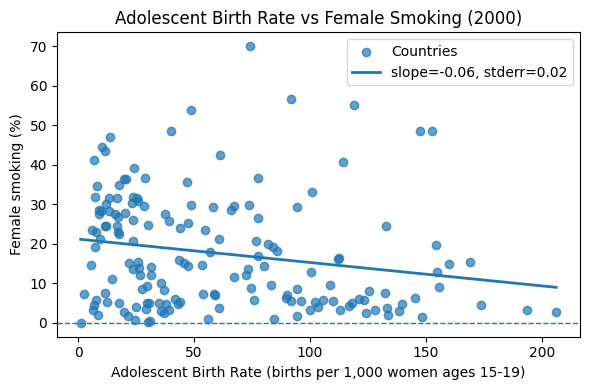

Year: 2022
abr count: 164
female_smoking count: 164


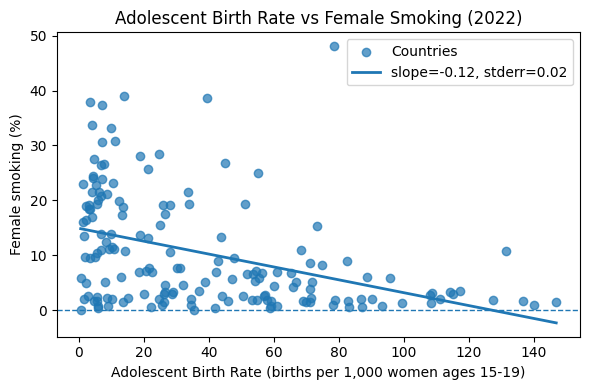

Year: 2000
se_f count: 143
female_smoking count: 143


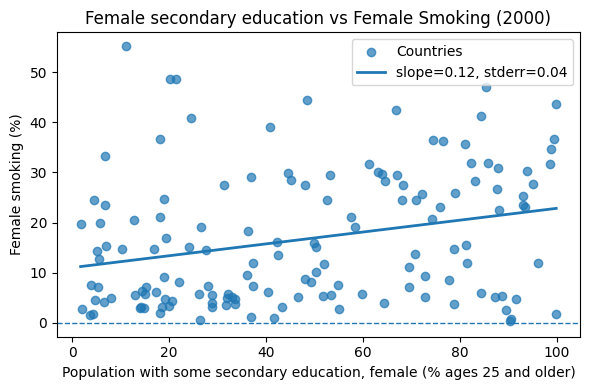

Year: 2022
se_f count: 160
female_smoking count: 160


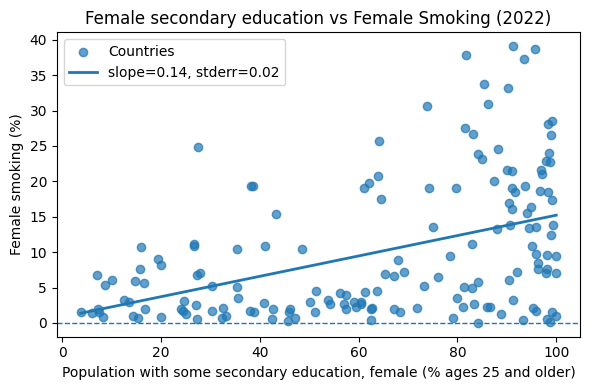

Year: 2000
lfpr_f count: 138
female_smoking count: 138


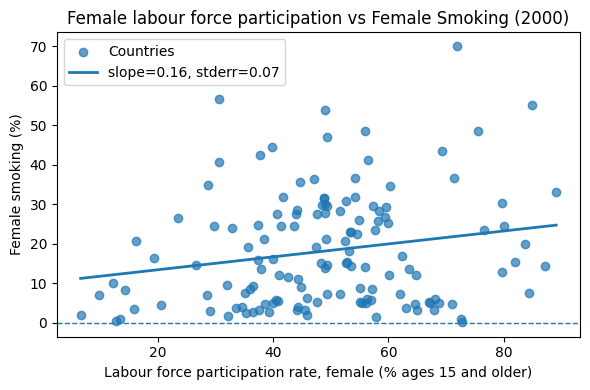

Year: 2022
lfpr_f count: 161
female_smoking count: 161


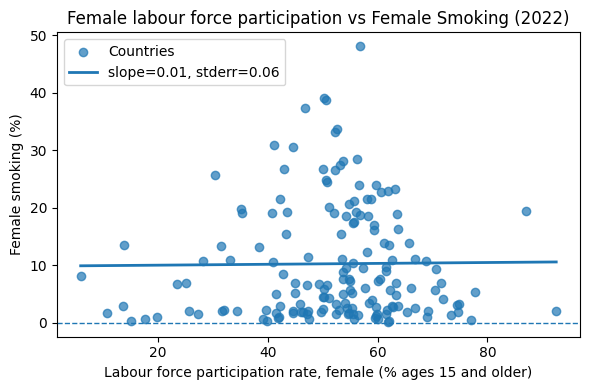

Year: 2000
pr_f count: 149
female_smoking count: 149


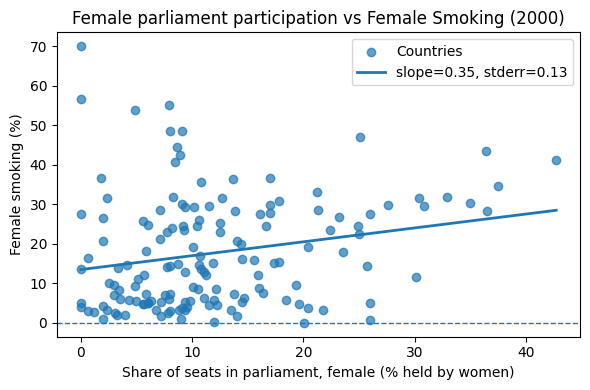

Year: 2022
pr_f count: 164
female_smoking count: 164


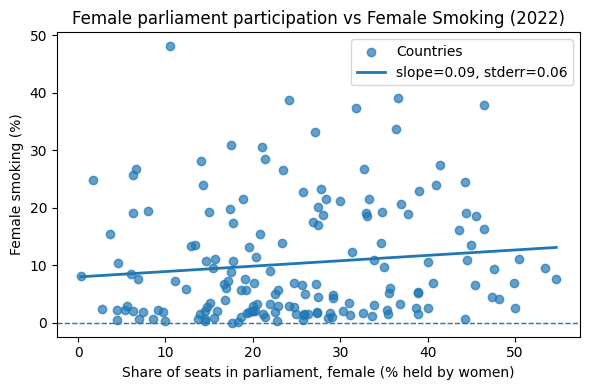

In [121]:
indicator_list = [
    ("abr", ["Adolescent Birth Rate", "Adolescent Birth Rate (births per 1,000 women ages 15-19)"]),
    ("se_f", ["Female secondary education", "Population with some secondary education, female (% ages 25 and older)"]),
    ("lfpr_f", ["Female labour force participation", "Labour force participation rate, female (% ages 15 and older)"]),
    ("pr_f",  ["Female parliament participation", "Share of seats in parliament, female (% held by women)"])
]

for indicator, label in indicator_list:
    # label is a list of indicator's name and detail info
    # 2000
    plot_indicator_vs_target(
        docs_joined_2000, 2000,
        indicator_field=indicator,
        indicator_label=label[1],
        target_field="female_smoking",
        target_label="Female smoking (%)",
        title_prefix=f"{label[0]} vs Female Smoking"
    )

    # 2022
    plot_indicator_vs_target(
        docs_joined_2022, 2022,
        indicator_field=indicator,
        indicator_label=label[1],
        target_field="female_smoking",
        target_label="Female smoking (%)",
        title_prefix=f"{label[0]} vs Female Smoking"
    )

#### Analysis:
**1. adolescent birth rate and female smoking:**

In both 2000 and 2022, adolescent birth rate shows a negative relationship with female smoking. **Countries with high abr — usually more traditional and less gender-equal — have very low female smoking rates, while countries with low abr show a much wider range and, on average, higher female smoking prevalence.**

The stronger negative slope in 2022 suggests that as societies improve women's rights and reduce adolescent births, female smoking becomes more common and more variable. This supports our idea that the stereotype “smoking is a male behavior” is shaped by gender inequality, not biology.

Practically, the results show that countries reducing abr should include gender-sensitive anti-smoking policies, especially for young women, while high-equality countries should design health campaigns that specifically address female smoking patterns.

**2. female secondary education and female smoking:**

The comparison between 2000 and 2022 shows that the exact slope difference is not the key insight. **What matters is that female smoking becomes more structured and more varied in countries with high female education, while female smoking rate in countries with low education goes nearly zero.** This suggests that as women gain education and autonomy, their smoking behavior is no longer tightly restricted by traditional norms, leading to a wider range of choices.

This challenges the stereotype that smoking is mainly associated with “low-education girls.” Our data shows that highly educated women also smoke, possibly influenced by social freedom, workplace stress, and cultural norms. For public health, this means anti-smoking campaigns must not overlook educated women and should include targeted interventions that address the pressures and environments they face.

**3. female labour force participation and female smoking:**

The scatter plots show that the relationship between female labour force participation and female smoking is not linear. Instead, both years display a triangle-shaped pattern: **the highest female smoking rate range appear in countries with mid-level participation (40-60%)**, suggesting that smoking becomes more common in societies undergoing gender-norm transitions. It indicates that tobacco-control efforts should also focus on those in emerging or transitional labour markets where smoking may become a marker of autonomy or modern identity.

**4. female parliament participation and female smoking:**

**Female political representation has very little relationship with female smoking, especially in recent years.** In 2000, the slope is mildly positive, but the points are widely scattered and the pattern is weak. By 2022, the slope becomes almost flat, showing no meaningful association at all.

This suggests that female smoking is not strongly influenced by how many women hold seats in parliament. As global smoking rates decline and health messaging becomes widespread, political empowerment no longer predicts whether women smoke. In practice, this means anti-smoking interventions should focus more on social norms, stress, cultural restrictions, and economic factors, rather than on political representation.



###Graph 12: GII indicators vs smoking gap (male - female)

After examining GII indicator's relationship with female smoking, we also want to look at their relationships with man and women's smoking gap. This motivates our next analysis:

**How does GII indicators relate to the gender smoking gap?**

Year: 2000
abr count: 164
smoking_gap count: 164


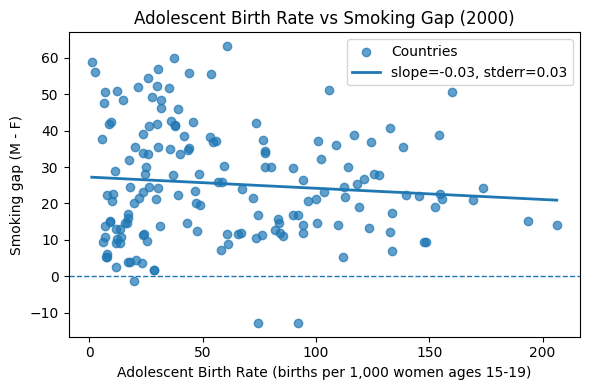

Year: 2022
abr count: 164
smoking_gap count: 164


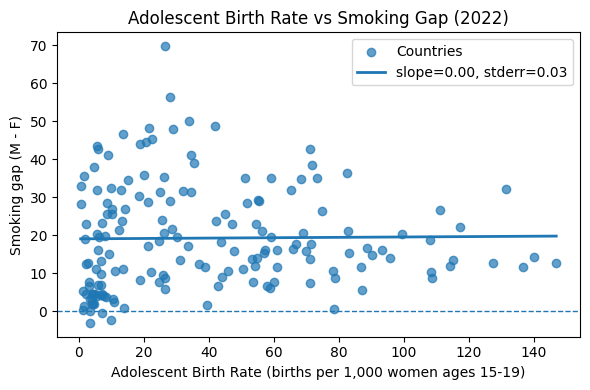

Year: 2000
se_f count: 143
smoking_gap count: 143


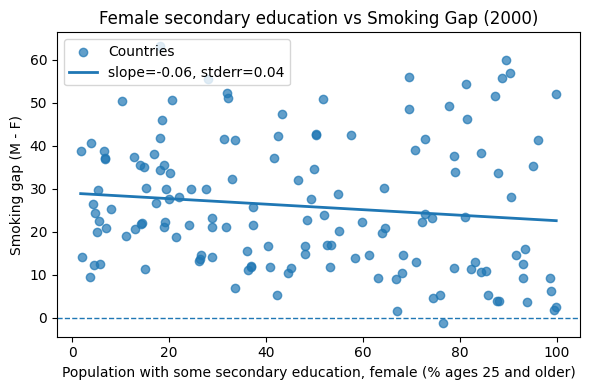

Year: 2022
se_f count: 160
smoking_gap count: 160


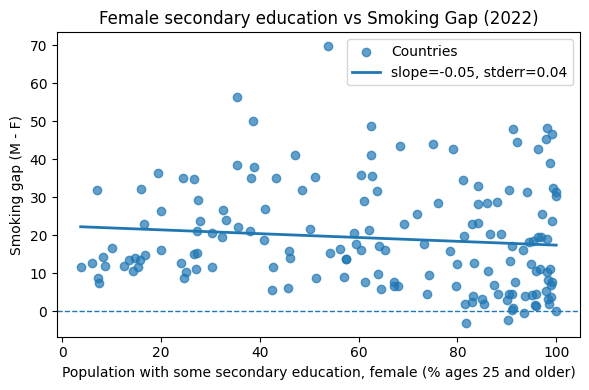

Year: 2000
lfpr_f count: 138
smoking_gap count: 138


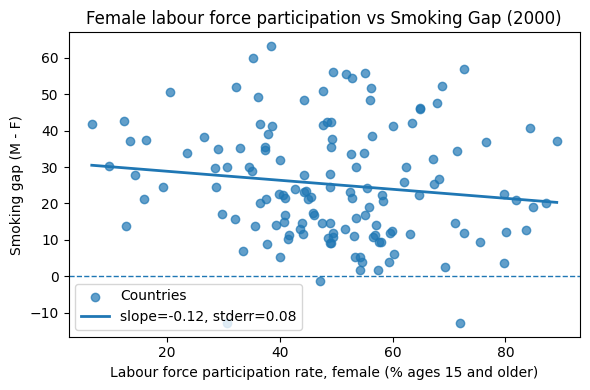

Year: 2022
lfpr_f count: 161
smoking_gap count: 161


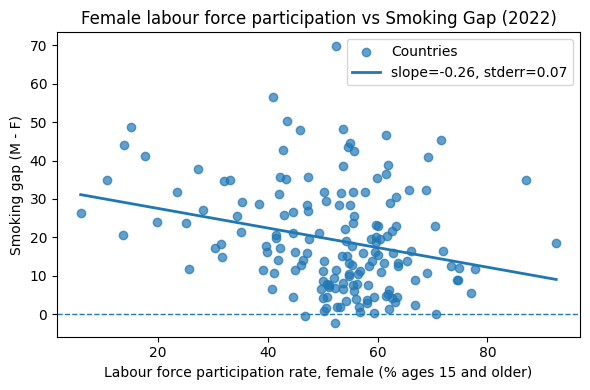

Year: 2000
pr_f count: 149
smoking_gap count: 149


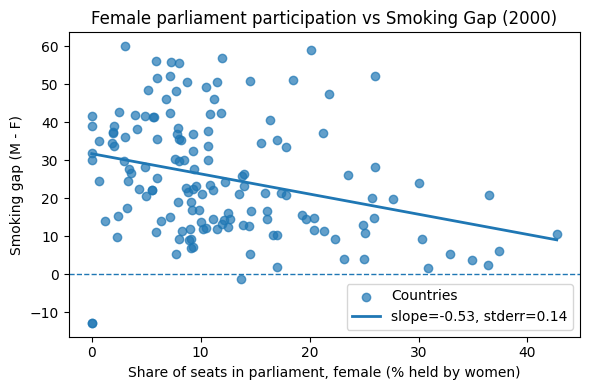

Year: 2022
pr_f count: 164
smoking_gap count: 164


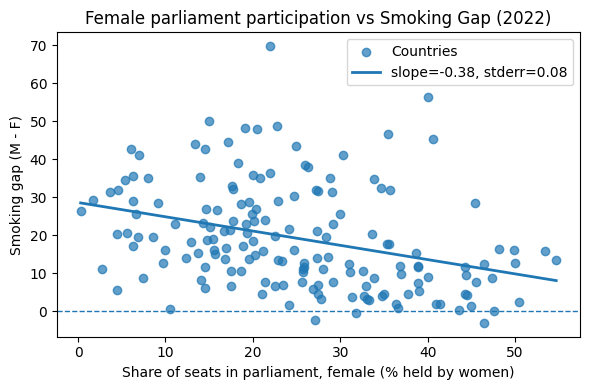

In [122]:
for indicator, label in indicator_list:
    # 2000
    plot_indicator_vs_target(
        docs_joined_2000, 2000,
        indicator_field=indicator,
        indicator_label=label[1],
        target_field="smoking_gap",
        target_label="Smoking gap (M - F)",
        title_prefix=f"{label[0]} vs Smoking Gap"
    )

    # 2022
    plot_indicator_vs_target(
        docs_joined_2022, 2022,
        indicator_field=indicator,
        indicator_label=label[1],
        target_field="smoking_gap",
        target_label="Smoking gap (M - F)",
        title_prefix=f"{label[0]} vs Smoking Gap"
    )

#### Analysis
Across all four indicators, the slopes are very small and mostly negative, and the scatter plots do not show strong or stable patterns. This tells us that individual GII indicators do not meaningfully predict the gender smoking gap, even though some of them strongly relate to female smoking alone.

**1. Adolescent Birth Rate (ABR) → almost no relationship**

Both years show slopes near zero.
High-ABR countries have low female autonomy, but male smoking remains high everywhere, so the gap stays large regardless of ABR.

This means that smoking gap is not driven by teenage reproductive inequality; it reflects broader gender norms that affect male and female smoking differently.

**2. Female secondary education → weak negative relationship**

Higher female education is weakly associated with a slightly smaller smoking gap, because female smoking increases a little while male smoking remains stable.

But the effect is tiny, and the cloud is extremely scattered.

This means that education may change female smoking more than male smoking, but the gap itself is controlled by other social forces (masculinity norms, cultural stigma toward female smoking).

**3. Female labour force participation → modest negative slope, but weak overall**

Countries with higher female workforce participation tend to have slightly smaller smoking gaps — again because female smoking rises a bit while male smoking barely changes.

But the relationship is inconsistent across countries.

This means that labour participation may increase women's autonomy and exposure to smoking environments, but it still does not reshape the gendered nature of smoking at the population level.

**4. Female parliament participation → largest negative slope, but still weak**

This is the only indicator showing a somewhat clearer negative slope:
more women in parliament → smaller smoking gap.

But even here the explanatory power is low, and the scatter remains wide.This means that political empowerment may reflect deeper gender-equality improvements that gradually narrow gender differences in smoking, but the effect is far from strong or direct.

### Graph 13 GII indicators vs Female smoking rate correlation
To verify which indcators have better influence on female smoking rate.
To accomendate the frequency difference, smoking rate is interpolated linearly between the 5 years gap.

Correlation is calculated using Pearson correlation coefficient.

We found these significant correlations: (correlation coeffecients around 0.5)
1. Higher secondary eduaction actually lead more smoking rate, which is around the middle school time. Maybe institutes focusing on teenage health still need to pay attention to female teenage smokers?
2. Adolesence bith rate is negatively related to female smoking rate. This is a subsequent result of low GII in certain areas. If female safety is not well protected, we may not need to pay a lot of attention to their smoking risks.

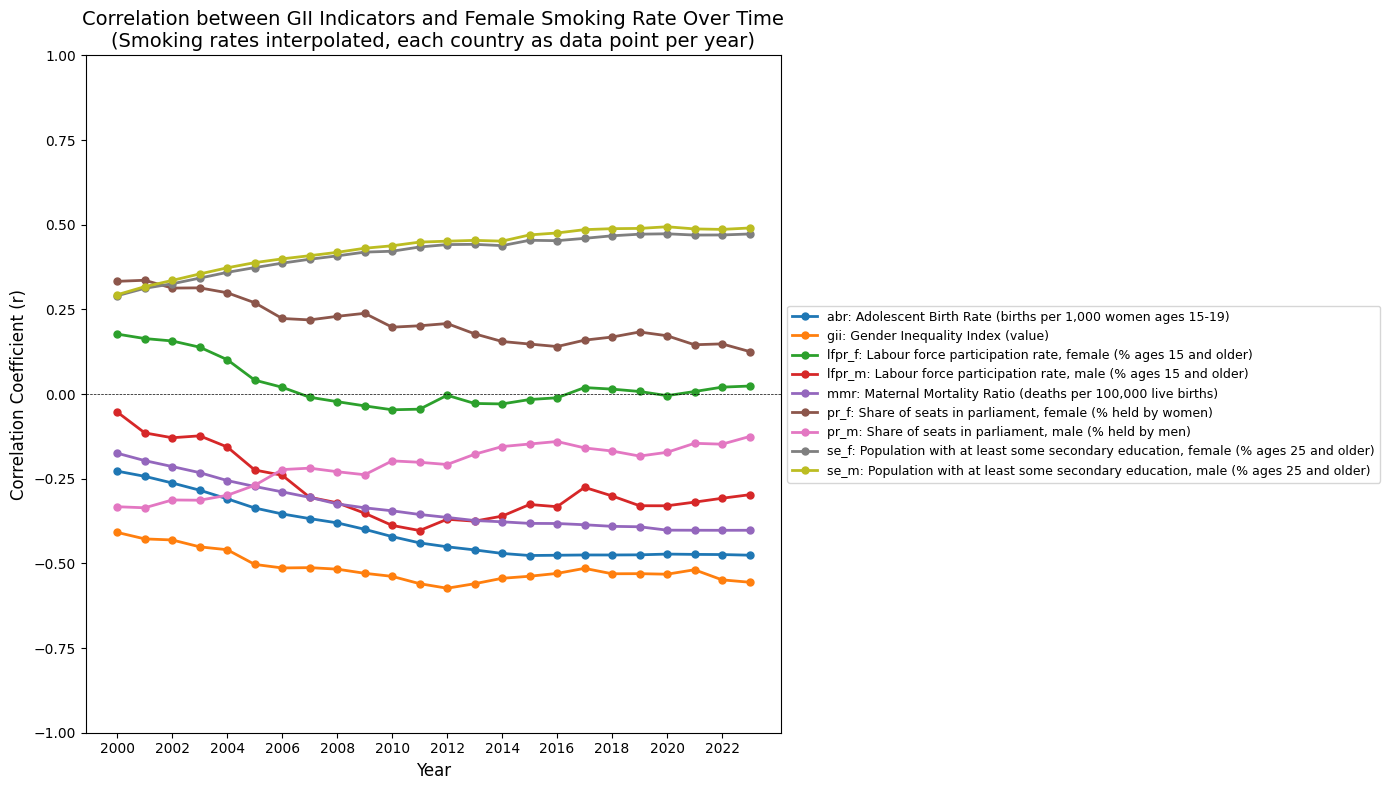

In [123]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

def get_gii_countries_mongo(database):
  # only get the countries with the GII indicator value, as it is the smallest subgroup with all the other indicators
  # get shared countries and ones also hve the gii indicator value
  pipeline = [
      {'$match': {'indicatorCode': 'gii'}},
      {'$group': {'_id': '$isoCode'}},
      {'$lookup': {
          'from': 'smoking_rates',
          'localField': '_id',
          'foreignField': 'isoCode',
          'as': 'has_smoking'
      }},
      {'$match': {'has_smoking': {'$ne': []}}},
      {'$project': {'_id': 1}}
  ]
  result = database["GII_data"].aggregate(pipeline)
  return [doc['_id'] for doc in result]


def get_correlation_data_mongo(database):
  """Get GII indicators and female smoking rates by country and year"""
  gii_countries = get_gii_countries_mongo(database)

  # Get GII data (excluding rank indicators, this is not a valid indicator to check)
  gii_results = list(database["GII_data"].aggregate([
      {'$match': {
          'isoCode': {'$in': gii_countries},
          'indicatorCode': {'$ne': 'gii_rank'}
      }},
      {'$project': {'isoCode': 1, 'indicatorCode': 1, 'indicator': 1, 'year': 1, 'value': 1, '_id': 0}},
      {'$sort': {'year': 1, 'indicatorCode': 1, 'isoCode': 1}}
  ]))

  # Get female smoking data
  smoking_results = list(database["smoking_rates"].aggregate([
      {'$match': {
          'isoCode': {'$in': gii_countries},
          'gender': 'female'
      }},
      {'$project': {'isoCode': 1, 'year': 1, 'rate': 1, '_id': 0}},
      {'$sort': {'isoCode': 1, 'year': 1}}
  ]))

  return gii_results, smoking_results


def draw_correlation_plot(gii_results, smoking_results):
  """Draw line graph showing correlation over time for each GII indicator"""

  # Organize smoking data by country
  smoking_by_country = {}
  for doc in smoking_results:
      iso = doc['isoCode']
      if iso not in smoking_by_country:
          smoking_by_country[iso] = {'years': [], 'rates': []}
      smoking_by_country[iso]['years'].append(float(doc['year']))
      smoking_by_country[iso]['rates'].append(float(doc['rate']))

  # Create interpolation functions for each country
  smoking_interp = {}
  for iso, data in smoking_by_country.items():
      if len(data['years']) >= 2:
          smoking_interp[iso] = interp1d(
              data['years'], data['rates'],
              kind='linear', fill_value='extrapolate'
          )

  # Organize GII data by (indicator, year) -> list of (country, value)
  indicator_names = {}
  gii_by_indicator_year = {}

  for doc in gii_results:
      indicator_names[doc['indicatorCode']] = doc['indicator']
      key = (doc['indicatorCode'], doc['year'])
      if key not in gii_by_indicator_year:
          gii_by_indicator_year[key] = []
      gii_by_indicator_year[key].append((doc['isoCode'], float(doc['value']), float(doc['year'])))

  # Calculate correlation for each indicator and year
  correlations_by_indicator = {code: {'years': [], 'corrs': []} for code in indicator_names.keys()}

  for (indicator_code, year), country_values in gii_by_indicator_year.items():
      gii_values = []
      smoking_values = []

      for iso, value, yr in country_values:
          if iso in smoking_interp:
              interpolated_smoking = float(smoking_interp[iso](yr))
              gii_values.append(value)
              smoking_values.append(interpolated_smoking)

      if len(gii_values) > 2:
          corr = np.corrcoef(gii_values, smoking_values)[0, 1]
          correlations_by_indicator[indicator_code]['years'].append(year)
          correlations_by_indicator[indicator_code]['corrs'].append(corr)

  # Sort by year for each indicator
  for code in correlations_by_indicator:
      data = correlations_by_indicator[code]
      sorted_pairs = sorted(zip(data['years'], data['corrs']))
      data['years'] = [p[0] for p in sorted_pairs]
      data['corrs'] = [p[1] for p in sorted_pairs]

  # Draw line graph
  fig, ax = plt.subplots(figsize=(14, 8))

  colors = plt.cm.tab10.colors

  for idx, (indicator_code, indicator_name) in enumerate(indicator_names.items()):
      data = correlations_by_indicator[indicator_code]
      ax.plot(data['years'], data['corrs'],
              color=colors[idx % len(colors)],
              marker='o', markersize=5, linewidth=2,
              label=f'{indicator_code}: {indicator_name}')

  ax.axhline(y=0, color='black', linewidth=0.5, linestyle='--')
  ax.set_xlabel('Year', fontsize=12)
  ax.set_ylabel('Correlation Coefficient (r)', fontsize=12)
  ax.set_title('Correlation between GII Indicators and Female Smoking Rate Over Time\n(Smoking rates interpolated, each country as data point per year)', fontsize=14)
  ax.set_ylim(-1, 1)

  all_years = set()
  for data in correlations_by_indicator.values():
      all_years.update(data['years'])
  all_years = sorted(all_years)
  ax.set_xticks(all_years[::2])  # Show every 2nd year
  ax.set_xticklabels([int(y) for y in all_years[::2]])

  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
  plt.tight_layout()
  plt.show()

  return correlations_by_indicator, indicator_names


# Run the analysis
gii_results, smoking_results = get_correlation_data_mongo(database)
correlations_by_indicator, indicator_names = draw_correlation_plot(gii_results, smoking_results)

In [124]:
client.close()
print("MongoDB connection closed.")

MongoDB connection closed.


# Actions
Based on our findings, we propose three actionable directions:

1.	Gender-equal countries should implement targeted anti-smoking programs for women, because female smoking rises rapidly when equality improves.

2.	Countries reducing adolescent birth rates should integrate smoking prevention into youth and women's health programs, as female smoking becomes more variable in these societies.

3.	Public health campaigns should avoid assuming female smoking is limited to low-education groups; educated women may smoke due to workplace stress, cultural freedom, or social identity.